In [1]:
!nvidia-smi

Mon Jul 27 02:50:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np 
import random
import os
import glob
import copy
from tqdm import tqdm as tqdm
from torchsummary import summary

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# train class samples 
print('Normal Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/NORMAL | wc -l
print('Pneumonia Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/PNEUMONIA | wc -l

Normal Samples in Training Data
1342
Pneumonia Samples in Training Data
3876


In [5]:
# Validation samples
print('Normal Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/NORMAL | wc -l
print('Pneumonia Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/PNEUMONIA | wc -l

Normal Samples in Validation Data
9
Pneumonia Samples in Validation Data
9


In [6]:
# Testing samples
print('Normal Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/NORMAL | wc -l
print('Pneumonia Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/PNEUMONIA | wc -l

Normal Samples in Testing Data
235
Pneumonia Samples in Testing Data
391


In [7]:
# Copying to Non DP data(train, val and test) to local to process/run faster during training & inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/train ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/val ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/test ./

In [8]:
!ls -lrt

total 20
drwxr-xr-x 1 root root 4096 Jul 10 16:29 sample_data
drwx------ 4 root root 4096 Jul 27 02:50 drive
drwx------ 4 root root 4096 Jul 27 02:58 train
drwx------ 4 root root 4096 Jul 27 03:17 val
drwx------ 4 root root 4096 Jul 27 03:18 test


In [9]:
!ls -l ./train/NORMAL | wc -l

!ls -l ./train/PNEUMONIA | wc -l

1342
3876


In [10]:
!ls -l ./val/NORMAL | wc -l

!ls -l ./val/PNEUMONIA | wc -l

9
9


In [11]:
!ls -l ./test/NORMAL | wc -l

!ls -l ./test/PNEUMONIA | wc -l

235
391


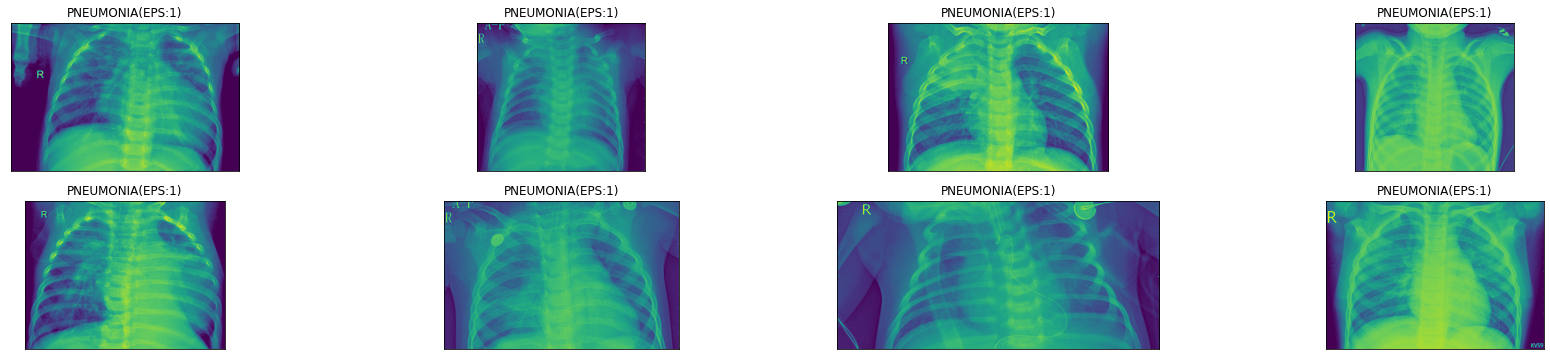

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 PNEUMONIA images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/PNEUMONIA")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/PNEUMONIA/" + img)
    plt.imshow(im)
    ax.set_title('PNEUMONIA(EPS:1)')

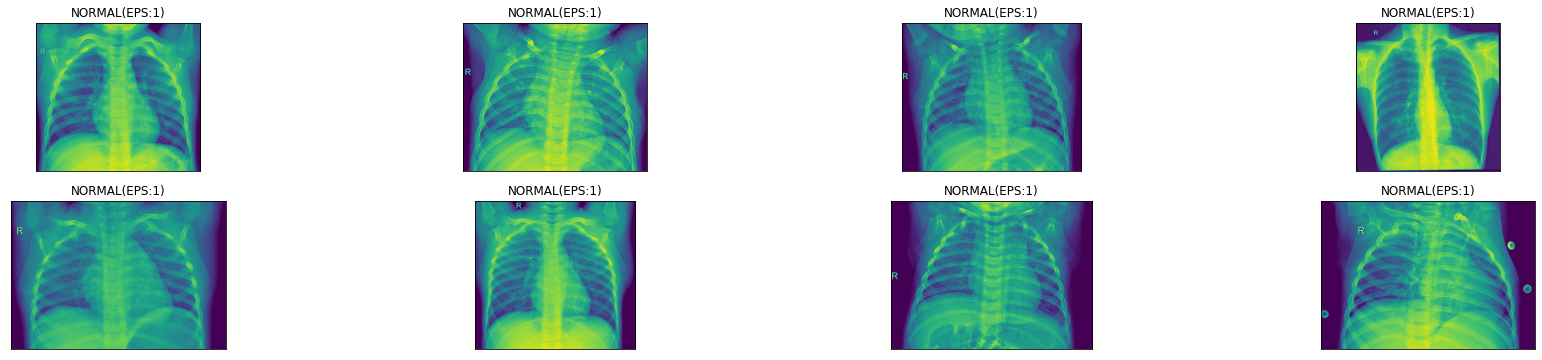

In [13]:
fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 NORMAL images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/NORMAL")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/NORMAL/" + img)
    plt.imshow(im)
    ax.set_title('NORMAL(EPS:1)')

In [14]:
class ChestXRay(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target
       

In [15]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ChestXRay('./train/', transform=train_transforms)
val_dataset = ChestXRay('./val/', transform=train_transforms)
test_dataset = ChestXRay('./test/', transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [27]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        #m.affine = False
        #m.track_running_stats = False
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [28]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [29]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    model.apply(deactivate_batchnorm)
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 32
    S = 1
    z = 5.002 # n=5218, batch_size=128, noise_multiplier=5.002, epochs=50, delta=1e-4. This gives DP-SGD with sampling rate = 2.45% and noise_multiplier = 5.002 iterated over 2039 steps satisfies differential privacy with eps = 0.994 and delta = 0.0001.
              # The optimal RDP order is 20.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [30]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    model.apply(deactivate_batchnorm)
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [31]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [32]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0
train batch [0/41]: loss 0.6756365895271301

1it [00:08,  8.35s/it]

train batch [1/41]: loss 0.6512285470962524

2it [00:16,  8.29s/it]

train batch [2/41]: loss 0.6512684226036072

3it [00:24,  8.30s/it]

train batch [3/41]: loss 0.656372606754303

4it [00:33,  8.36s/it]

train batch [4/41]: loss 0.6332546472549438

5it [00:41,  8.32s/it]

train batch [5/41]: loss 0.5917180776596069

6it [00:49,  8.23s/it]

train batch [6/41]: loss 0.6045843958854675

7it [00:57,  8.26s/it]

train batch [7/41]: loss 0.5308588743209839

8it [01:06,  8.24s/it]

train batch [8/41]: loss 0.5371934175491333

9it [01:14,  8.25s/it]

train batch [9/41]: loss 0.5193736553192139

10it [01:22,  8.20s/it]

train batch [10/41]: loss 0.4861774146556854

11it [01:30,  8.17s/it]

train batch [11/41]: loss 0.4762709438800812

12it [01:38,  8.15s/it]

train batch [12/41]: loss 0.5654507875442505

13it [01:46,  8.19s/it]

train batch [13/41]: loss 0.4784736931324005

14it [01:55,  8.20s/it]

train batch [14/41]: loss 0.4635116457939148

15it [02:03,  8.20s/it]

train batch [15/41]: loss 0.5146536827087402

16it [02:11,  8.23s/it]

train batch [16/41]: loss 0.45082831382751465

17it [02:19,  8.20s/it]

train batch [17/41]: loss 0.533481240272522

18it [02:28,  8.26s/it]

train batch [18/41]: loss 0.4225533604621887

19it [02:36,  8.22s/it]

train batch [19/41]: loss 0.4335341453552246

20it [02:44,  8.25s/it]

train batch [20/41]: loss 0.4288076162338257

21it [02:52,  8.23s/it]

train batch [21/41]: loss 0.403877317905426

22it [03:00,  8.18s/it]

train batch [22/41]: loss 0.4774671196937561

23it [03:09,  8.21s/it]

train batch [23/41]: loss 0.43271294236183167

24it [03:17,  8.22s/it]

train batch [24/41]: loss 0.43433061242103577

25it [03:25,  8.25s/it]

train batch [25/41]: loss 0.4565209150314331

26it [03:34,  8.26s/it]

train batch [26/41]: loss 0.3571721315383911

27it [03:42,  8.23s/it]

train batch [27/41]: loss 0.4450642764568329

28it [03:50,  8.24s/it]

train batch [28/41]: loss 0.41030317544937134

29it [03:58,  8.16s/it]

train batch [29/41]: loss 0.3727267384529114

30it [04:06,  8.17s/it]

train batch [30/41]: loss 0.354129433631897

31it [04:14,  8.22s/it]

train batch [31/41]: loss 0.4020000696182251

32it [04:23,  8.25s/it]

train batch [32/41]: loss 0.43206843733787537

33it [04:31,  8.28s/it]

train batch [33/41]: loss 0.3920353055000305

34it [04:39,  8.25s/it]

train batch [34/41]: loss 0.3976515233516693

35it [04:47,  8.22s/it]

train batch [35/41]: loss 0.3386353850364685

36it [04:56,  8.17s/it]

train batch [36/41]: loss 0.3369372487068176

37it [05:04,  8.24s/it]

train batch [37/41]: loss 0.33762145042419434

38it [05:12,  8.22s/it]

train batch [38/41]: loss 0.40514707565307617

39it [05:20,  8.24s/it]

train batch [39/41]: loss 0.4063902497291565

40it [05:29,  8.24s/it]

train batch [40/41]: loss 0.4477672278881073

41it [05:35,  8.18s/it]

val batch [1/4]: loss 0.9756596088409424

test batch [4/5]: loss 0.3135620653629303

0it [00:00, ?it/s]


Train loss: 0.4718485605425951, Train accuracy: 0.7710889577865601
Val loss: 0.8359296694397926, Val accuracy: 0.625
Test loss: 0.5084697902202606, Test accuracy: 0.7628205418586731

=============== Epoch: 1
train batch [0/41]: loss 0.359565794467926

1it [00:08,  8.36s/it]

train batch [1/41]: loss 0.35683828592300415

2it [00:16,  8.24s/it]

train batch [2/41]: loss 0.37521421909332275

3it [00:24,  8.24s/it]

train batch [3/41]: loss 0.36167219281196594

4it [00:32,  8.27s/it]

train batch [4/41]: loss 0.35240834951400757

5it [00:41,  8.29s/it]

train batch [5/41]: loss 0.3377014398574829

6it [00:49,  8.29s/it]

train batch [6/41]: loss 0.38067176938056946

7it [00:57,  8.32s/it]

train batch [7/41]: loss 0.32940059900283813

8it [01:06,  8.26s/it]

train batch [8/41]: loss 0.3402901291847229

9it [01:14,  8.25s/it]

train batch [9/41]: loss 0.36029744148254395

10it [01:22,  8.25s/it]

train batch [10/41]: loss 0.30469343066215515

11it [01:30,  8.18s/it]

train batch [11/41]: loss 0.30224382877349854

12it [01:38,  8.19s/it]

train batch [12/41]: loss 0.34449324011802673

13it [01:46,  8.17s/it]

train batch [13/41]: loss 0.3667774796485901

14it [01:55,  8.25s/it]

train batch [14/41]: loss 0.36415931582450867

15it [02:03,  8.35s/it]

train batch [15/41]: loss 0.3201022446155548

16it [02:12,  8.32s/it]

train batch [16/41]: loss 0.32594579458236694

17it [02:20,  8.38s/it]

train batch [17/41]: loss 0.3441925048828125

18it [02:28,  8.31s/it]

train batch [18/41]: loss 0.2826899290084839

19it [02:36,  8.25s/it]

train batch [19/41]: loss 0.37504178285598755

20it [02:45,  8.23s/it]

train batch [20/41]: loss 0.2878701388835907

21it [02:53,  8.20s/it]

train batch [21/41]: loss 0.40796852111816406

22it [03:01,  8.17s/it]

train batch [22/41]: loss 0.28314459323883057

23it [03:09,  8.11s/it]

train batch [23/41]: loss 0.33173468708992004

24it [03:17,  8.10s/it]

train batch [24/41]: loss 0.3277365565299988

25it [03:25,  8.11s/it]

train batch [25/41]: loss 0.3299890458583832

26it [03:33,  8.21s/it]

train batch [26/41]: loss 0.31226277351379395

27it [03:42,  8.22s/it]

train batch [27/41]: loss 0.22991664707660675

28it [03:50,  8.16s/it]

train batch [28/41]: loss 0.34355419874191284

29it [03:58,  8.23s/it]

train batch [29/41]: loss 0.2795950770378113

30it [04:06,  8.22s/it]

train batch [30/41]: loss 0.33274948596954346

31it [04:15,  8.24s/it]

train batch [31/41]: loss 0.4519060254096985

32it [04:23,  8.23s/it]

train batch [32/41]: loss 0.3305085003376007

33it [04:31,  8.19s/it]

train batch [33/41]: loss 0.47102048993110657

34it [04:39,  8.23s/it]

train batch [34/41]: loss 0.281048059463501

35it [04:48,  8.25s/it]

train batch [35/41]: loss 0.40424007177352905

36it [04:56,  8.34s/it]

train batch [36/41]: loss 0.37510454654693604

37it [05:04,  8.26s/it]

train batch [37/41]: loss 0.2988285720348358

38it [05:12,  8.20s/it]

train batch [38/41]: loss 0.37233489751815796

39it [05:21,  8.25s/it]

train batch [39/41]: loss 0.368472158908844

40it [05:29,  8.20s/it]

train batch [40/41]: loss 0.4404009282588959

41it [05:35,  8.18s/it]

val batch [1/4]: loss 2.3005378246307373

test batch [4/5]: loss 0.17007853090763092

0it [00:00, ?it/s]


Train loss: 0.34499476959065695, Train accuracy: 0.8483511805534363
Val loss: 1.5094689168035984, Val accuracy: 0.625
Test loss: 0.5487602621316909, Test accuracy: 0.7628205418586731

=============== Epoch: 2
train batch [0/41]: loss 0.3263280987739563

1it [00:08,  8.28s/it]

train batch [1/41]: loss 0.32984796166419983

2it [00:16,  8.22s/it]

train batch [2/41]: loss 0.3076953589916229

3it [00:24,  8.21s/it]

train batch [3/41]: loss 0.333132266998291

4it [00:32,  8.22s/it]

train batch [4/41]: loss 0.3277917206287384

5it [00:40,  8.21s/it]

train batch [5/41]: loss 0.39792776107788086

6it [00:49,  8.20s/it]

train batch [6/41]: loss 0.28283852338790894

7it [00:57,  8.27s/it]

train batch [7/41]: loss 0.35442686080932617

8it [01:05,  8.31s/it]

train batch [8/41]: loss 0.2859954833984375

9it [01:14,  8.29s/it]

train batch [9/41]: loss 0.30307722091674805

10it [01:22,  8.28s/it]

train batch [10/41]: loss 0.25794723629951477

11it [01:30,  8.25s/it]

train batch [11/41]: loss 0.3297344148159027

12it [01:38,  8.23s/it]

train batch [12/41]: loss 0.3169340491294861

13it [01:47,  8.22s/it]

train batch [13/41]: loss 0.32750803232192993

14it [01:55,  8.25s/it]

train batch [14/41]: loss 0.31163936853408813

15it [02:03,  8.25s/it]

train batch [15/41]: loss 0.20961837470531464

16it [02:11,  8.28s/it]

train batch [16/41]: loss 0.296928346157074

17it [02:20,  8.29s/it]

train batch [17/41]: loss 0.25646090507507324

18it [02:28,  8.29s/it]

train batch [18/41]: loss 0.2507343590259552

19it [02:36,  8.24s/it]

train batch [19/41]: loss 0.3301616311073303

20it [02:44,  8.24s/it]

train batch [20/41]: loss 0.3362422585487366

21it [02:53,  8.22s/it]

train batch [21/41]: loss 0.2839874029159546

22it [03:01,  8.23s/it]

train batch [22/41]: loss 0.3095049262046814

23it [03:09,  8.27s/it]

train batch [23/41]: loss 0.30297571420669556

24it [03:17,  8.25s/it]

train batch [24/41]: loss 0.2694603502750397

25it [03:25,  8.19s/it]

train batch [25/41]: loss 0.2838243246078491

26it [03:34,  8.18s/it]

train batch [26/41]: loss 0.5167198777198792

27it [03:42,  8.23s/it]

train batch [27/41]: loss 0.26804399490356445

28it [03:50,  8.23s/it]

train batch [28/41]: loss 0.2917160391807556

29it [03:58,  8.24s/it]

train batch [29/41]: loss 0.290189266204834

30it [04:07,  8.22s/it]

train batch [30/41]: loss 0.27436691522598267

31it [04:15,  8.20s/it]

train batch [31/41]: loss 0.2618620693683624

32it [04:23,  8.23s/it]

train batch [32/41]: loss 0.28775712847709656

33it [04:31,  8.26s/it]

train batch [33/41]: loss 0.29156574606895447

34it [04:40,  8.27s/it]

train batch [34/41]: loss 0.33323681354522705

35it [04:48,  8.22s/it]

train batch [35/41]: loss 0.3263930082321167

36it [04:56,  8.19s/it]

train batch [36/41]: loss 0.3245534896850586

37it [05:04,  8.16s/it]

train batch [37/41]: loss 0.21709097921848297

38it [05:12,  8.18s/it]

train batch [38/41]: loss 0.3346715569496155

39it [05:20,  8.18s/it]

train batch [39/41]: loss 0.2560710608959198

40it [05:29,  8.19s/it]

train batch [40/41]: loss 0.38052594661712646

41it [05:35,  8.18s/it]

val batch [1/4]: loss 1.8263440132141113

test batch [4/5]: loss 0.16168563067913055

0it [00:00, ?it/s]


Train loss: 0.30676797831930763, Train accuracy: 0.8711656332015991
Val loss: 1.5228863134980202, Val accuracy: 0.625
Test loss: 0.5174582034349442, Test accuracy: 0.8028846383094788

=============== Epoch: 3
train batch [0/41]: loss 0.3698485493659973

1it [00:08,  8.04s/it]

train batch [1/41]: loss 0.28042951226234436

2it [00:16,  8.13s/it]

train batch [2/41]: loss 0.2790035605430603

3it [00:24,  8.14s/it]

train batch [3/41]: loss 0.2549905478954315

4it [00:33,  8.24s/it]

train batch [4/41]: loss 0.23459923267364502

5it [00:41,  8.26s/it]

train batch [5/41]: loss 0.24922803044319153

6it [00:49,  8.27s/it]

train batch [6/41]: loss 0.2562805414199829

7it [00:57,  8.21s/it]

train batch [7/41]: loss 0.2989516258239746

8it [01:06,  8.26s/it]

train batch [8/41]: loss 0.2326146960258484

9it [01:14,  8.22s/it]

train batch [9/41]: loss 0.21675029397010803

10it [01:22,  8.14s/it]

train batch [10/41]: loss 0.3870510458946228

11it [01:30,  8.21s/it]

train batch [11/41]: loss 0.3889573812484741

12it [01:38,  8.23s/it]

train batch [12/41]: loss 0.2420760691165924

13it [01:47,  8.23s/it]

train batch [13/41]: loss 0.22979667782783508

14it [01:55,  8.23s/it]

train batch [14/41]: loss 0.14019730687141418

15it [02:03,  8.20s/it]

train batch [15/41]: loss 0.4096629023551941

16it [02:11,  8.23s/it]

train batch [16/41]: loss 0.31279802322387695

17it [02:19,  8.21s/it]

train batch [17/41]: loss 0.2391674965620041

18it [02:28,  8.21s/it]

train batch [18/41]: loss 0.3385355472564697

19it [02:36,  8.21s/it]

train batch [19/41]: loss 0.21966443955898285

20it [02:44,  8.20s/it]

train batch [20/41]: loss 0.1711737960577011

21it [02:52,  8.16s/it]

train batch [21/41]: loss 0.2628577947616577

22it [03:00,  8.22s/it]

train batch [22/41]: loss 0.2937619090080261

23it [03:09,  8.23s/it]

train batch [23/41]: loss 0.25999969244003296

24it [03:17,  8.27s/it]

train batch [24/41]: loss 0.30389171838760376

25it [03:25,  8.23s/it]

train batch [25/41]: loss 0.24124674499034882

26it [03:33,  8.24s/it]

train batch [26/41]: loss 0.2732809782028198

27it [03:42,  8.20s/it]

train batch [27/41]: loss 0.3493785560131073

28it [03:50,  8.19s/it]

train batch [28/41]: loss 0.28047358989715576

29it [03:58,  8.21s/it]

train batch [29/41]: loss 0.46772611141204834

30it [04:06,  8.31s/it]

train batch [30/41]: loss 0.2713448107242584

31it [04:15,  8.32s/it]

train batch [31/41]: loss 0.24960777163505554

32it [04:23,  8.26s/it]

train batch [32/41]: loss 0.21549126505851746

33it [04:31,  8.26s/it]

train batch [33/41]: loss 0.26442664861679077

34it [04:40,  8.31s/it]

train batch [34/41]: loss 0.3062557578086853

35it [04:48,  8.33s/it]

train batch [35/41]: loss 0.2545407712459564

36it [04:56,  8.24s/it]

train batch [36/41]: loss 0.22790338099002838

37it [05:04,  8.18s/it]

train batch [37/41]: loss 0.21908172965049744

38it [05:12,  8.14s/it]

train batch [38/41]: loss 0.3269358277320862

39it [05:20,  8.19s/it]

train batch [39/41]: loss 0.22889398038387299

40it [05:29,  8.21s/it]

train batch [40/41]: loss 0.3165128529071808

41it [05:35,  8.18s/it]

val batch [1/4]: loss 3.596250534057617

test batch [4/5]: loss 0.08026014268398285

0it [00:00, ?it/s]


Train loss: 0.27720461349661757, Train accuracy: 0.8817101120948792
Val loss: 2.0869750306010246, Val accuracy: 0.5
Test loss: 0.5977012678980828, Test accuracy: 0.7660256624221802

=============== Epoch: 4
train batch [0/41]: loss 0.40159404277801514

1it [00:08,  8.15s/it]

train batch [1/41]: loss 0.2745886445045471

2it [00:16,  8.22s/it]

train batch [2/41]: loss 0.383957177400589

3it [00:24,  8.21s/it]

train batch [3/41]: loss 0.3655250072479248

4it [00:32,  8.16s/it]

train batch [4/41]: loss 0.25645121932029724

5it [00:41,  8.22s/it]

train batch [5/41]: loss 0.23524421453475952

6it [00:49,  8.20s/it]

train batch [6/41]: loss 0.33638280630111694

7it [00:57,  8.20s/it]

train batch [7/41]: loss 0.24581360816955566

8it [01:05,  8.21s/it]

train batch [8/41]: loss 0.2856927216053009

9it [01:13,  8.20s/it]

train batch [9/41]: loss 0.4392644166946411

10it [01:22,  8.22s/it]

train batch [10/41]: loss 0.23488269746303558

11it [01:30,  8.21s/it]

train batch [11/41]: loss 0.2545090913772583

12it [01:38,  8.22s/it]

train batch [12/41]: loss 0.3504796028137207

13it [01:46,  8.25s/it]

train batch [13/41]: loss 0.22933506965637207

14it [01:55,  8.26s/it]

train batch [14/41]: loss 0.26470398902893066

15it [02:03,  8.24s/it]

train batch [15/41]: loss 0.3318740129470825

16it [02:11,  8.21s/it]

train batch [16/41]: loss 0.2024696320295334

17it [02:19,  8.20s/it]

train batch [17/41]: loss 0.28438830375671387

18it [02:27,  8.21s/it]

train batch [18/41]: loss 0.19108739495277405

19it [02:36,  8.18s/it]

train batch [19/41]: loss 0.3017936646938324

20it [02:44,  8.16s/it]

train batch [20/41]: loss 0.26759037375450134

21it [02:52,  8.17s/it]

train batch [21/41]: loss 0.21323919296264648

22it [03:00,  8.12s/it]

train batch [22/41]: loss 0.4005827307701111

23it [03:08,  8.18s/it]

train batch [23/41]: loss 0.18482741713523865

24it [03:16,  8.13s/it]

train batch [24/41]: loss 0.31379249691963196

25it [03:25,  8.21s/it]

train batch [25/41]: loss 0.34952372312545776

26it [03:33,  8.26s/it]

train batch [26/41]: loss 0.2309930920600891

27it [03:41,  8.18s/it]

train batch [27/41]: loss 0.536215603351593

28it [03:49,  8.21s/it]

train batch [28/41]: loss 0.38632214069366455

29it [03:58,  8.25s/it]

train batch [29/41]: loss 0.17894071340560913

30it [04:06,  8.25s/it]

train batch [30/41]: loss 0.28401434421539307

31it [04:14,  8.26s/it]

train batch [31/41]: loss 0.32972607016563416

32it [04:22,  8.27s/it]

train batch [32/41]: loss 0.31175029277801514

33it [04:31,  8.23s/it]

train batch [33/41]: loss 0.2973247468471527

34it [04:39,  8.21s/it]

train batch [34/41]: loss 0.32898443937301636

35it [04:47,  8.21s/it]

train batch [35/41]: loss 0.27514249086380005

36it [04:55,  8.23s/it]

train batch [36/41]: loss 0.23730221390724182

37it [05:03,  8.20s/it]

train batch [37/41]: loss 0.22744616866111755

38it [05:12,  8.25s/it]

train batch [38/41]: loss 0.14141115546226501

39it [05:20,  8.26s/it]

train batch [39/41]: loss 0.2064097821712494

40it [05:28,  8.33s/it]

train batch [40/41]: loss 0.27912867069244385

41it [05:35,  8.18s/it]

val batch [0/4]: loss 3.3876876831054688

test batch [4/5]: loss 0.2570316195487976

0it [00:00, ?it/s]


Train loss: 0.28904158785575773, Train accuracy: 0.8811349272727966
Val loss: 1.4757962375879288, Val accuracy: 0.625
Test loss: 0.4667726159095764, Test accuracy: 0.8429487347602844

=============== Epoch: 5
train batch [0/41]: loss 0.19705381989479065

1it [00:08,  8.34s/it]

train batch [1/41]: loss 0.2231484055519104

2it [00:16,  8.30s/it]

train batch [2/41]: loss 0.3035046458244324

3it [00:24,  8.32s/it]

train batch [3/41]: loss 0.2983282208442688

4it [00:33,  8.29s/it]

train batch [4/41]: loss 0.18007466197013855

5it [00:41,  8.24s/it]

train batch [5/41]: loss 0.28089621663093567

6it [00:49,  8.24s/it]

train batch [6/41]: loss 0.17170676589012146

7it [00:57,  8.12s/it]

train batch [7/41]: loss 0.32905876636505127

8it [01:05,  8.18s/it]

train batch [8/41]: loss 0.32166552543640137

9it [01:14,  8.25s/it]

train batch [9/41]: loss 0.29091739654541016

10it [01:22,  8.27s/it]

train batch [10/41]: loss 0.5071452856063843

11it [01:30,  8.26s/it]

train batch [11/41]: loss 0.20009340345859528

12it [01:38,  8.19s/it]

train batch [12/41]: loss 0.4509970545768738

13it [01:46,  8.17s/it]

train batch [13/41]: loss 0.2696508765220642

14it [01:55,  8.23s/it]

train batch [14/41]: loss 0.27730175852775574

15it [02:03,  8.23s/it]

train batch [15/41]: loss 0.297393262386322

16it [02:11,  8.26s/it]

train batch [16/41]: loss 0.38077062368392944

17it [02:20,  8.32s/it]

train batch [17/41]: loss 0.21714983880519867

18it [02:28,  8.29s/it]

train batch [18/41]: loss 0.2838001847267151

19it [02:36,  8.32s/it]

train batch [19/41]: loss 0.29351574182510376

20it [02:44,  8.21s/it]

train batch [20/41]: loss 0.21689660847187042

21it [02:53,  8.23s/it]

train batch [21/41]: loss 0.29667139053344727

22it [03:01,  8.24s/it]

train batch [22/41]: loss 0.31141310930252075

23it [03:09,  8.23s/it]

train batch [23/41]: loss 0.3207924962043762

24it [03:17,  8.21s/it]

train batch [24/41]: loss 0.30827540159225464

25it [03:25,  8.17s/it]

train batch [25/41]: loss 0.48718637228012085

26it [03:34,  8.24s/it]

train batch [26/41]: loss 0.3109416365623474

27it [03:42,  8.26s/it]

train batch [27/41]: loss 0.2886110544204712

28it [03:50,  8.23s/it]

train batch [28/41]: loss 0.27847784757614136

29it [03:58,  8.26s/it]

train batch [29/41]: loss 0.2566980719566345

30it [04:07,  8.22s/it]

train batch [30/41]: loss 0.5486940145492554

31it [04:15,  8.25s/it]

train batch [31/41]: loss 0.2582346796989441

32it [04:23,  8.27s/it]

train batch [32/41]: loss 0.3176942467689514

33it [04:32,  8.31s/it]

train batch [33/41]: loss 0.3240506052970886

34it [04:40,  8.31s/it]

train batch [34/41]: loss 0.23506206274032593

35it [04:48,  8.25s/it]

train batch [35/41]: loss 0.3644866347312927

36it [04:56,  8.20s/it]

train batch [36/41]: loss 0.274960458278656

37it [05:04,  8.22s/it]

train batch [37/41]: loss 0.24786461889743805

38it [05:13,  8.24s/it]

train batch [38/41]: loss 0.49810245633125305

39it [05:21,  8.24s/it]

train batch [39/41]: loss 0.2271445095539093

40it [05:29,  8.16s/it]

train batch [40/41]: loss 0.3318362832069397

41it [05:35,  8.19s/it]

val batch [0/4]: loss 9.340742111206055

test batch [4/5]: loss 0.041713181883096695

0it [00:00, ?it/s]


Train loss: 0.3043479759518693, Train accuracy: 0.887269914150238
Val loss: 3.7514693588018417, Val accuracy: 0.5
Test loss: 1.0929049499332906, Test accuracy: 0.7403846383094788

=============== Epoch: 6
train batch [0/41]: loss 0.5627171397209167

1it [00:08,  8.32s/it]

train batch [1/41]: loss 0.47515949606895447

2it [00:16,  8.32s/it]

train batch [2/41]: loss 0.29941830039024353

3it [00:24,  8.31s/it]

train batch [3/41]: loss 0.24247559905052185

4it [00:33,  8.31s/it]

train batch [4/41]: loss 0.4189489483833313

5it [00:41,  8.30s/it]

train batch [5/41]: loss 0.35139694809913635

6it [00:49,  8.31s/it]

train batch [6/41]: loss 0.19173592329025269

7it [00:57,  8.21s/it]

train batch [7/41]: loss 0.5499641299247742

8it [01:05,  8.15s/it]

train batch [8/41]: loss 0.45755624771118164

9it [01:14,  8.19s/it]

train batch [9/41]: loss 0.28653502464294434

10it [01:22,  8.18s/it]

train batch [10/41]: loss 0.22564560174942017

11it [01:30,  8.24s/it]

train batch [11/41]: loss 0.26252901554107666

12it [01:38,  8.22s/it]

train batch [12/41]: loss 0.2546302080154419

13it [01:47,  8.21s/it]

train batch [13/41]: loss 0.30144965648651123

14it [01:55,  8.25s/it]

train batch [14/41]: loss 0.34790173172950745

15it [02:03,  8.21s/it]

train batch [15/41]: loss 0.2063663750886917

16it [02:11,  8.26s/it]

train batch [16/41]: loss 0.3613031804561615

17it [02:20,  8.25s/it]

train batch [17/41]: loss 0.3054754137992859

18it [02:28,  8.22s/it]

train batch [18/41]: loss 0.5193895101547241

19it [02:36,  8.22s/it]

train batch [19/41]: loss 0.37537744641304016

20it [02:44,  8.27s/it]

train batch [20/41]: loss 0.4417388439178467

21it [02:53,  8.27s/it]

train batch [21/41]: loss 0.45490726828575134

22it [03:01,  8.29s/it]

train batch [22/41]: loss 0.4898056089878082

23it [03:09,  8.29s/it]

train batch [23/41]: loss 0.40588635206222534

24it [03:17,  8.25s/it]

train batch [24/41]: loss 0.3991222083568573

25it [03:25,  8.21s/it]

train batch [25/41]: loss 0.334489643573761

26it [03:34,  8.21s/it]

train batch [26/41]: loss 0.3230802118778229

27it [03:42,  8.22s/it]

train batch [27/41]: loss 0.24861592054367065

28it [03:50,  8.20s/it]

train batch [28/41]: loss 0.4216339588165283

29it [03:58,  8.19s/it]

train batch [29/41]: loss 0.1948111355304718

30it [04:06,  8.18s/it]

train batch [30/41]: loss 0.5320615768432617

31it [04:15,  8.18s/it]

train batch [31/41]: loss 0.22439749538898468

32it [04:23,  8.18s/it]

train batch [32/41]: loss 0.4615635275840759

33it [04:31,  8.16s/it]

train batch [33/41]: loss 0.460779070854187

34it [04:39,  8.16s/it]

train batch [34/41]: loss 0.48340702056884766

35it [04:48,  8.26s/it]

train batch [35/41]: loss 0.38065701723098755

36it [04:56,  8.26s/it]

train batch [36/41]: loss 0.4946591258049011

37it [05:04,  8.26s/it]

train batch [37/41]: loss 0.22754190862178802

38it [05:12,  8.19s/it]

train batch [38/41]: loss 0.2491762638092041

39it [05:20,  8.14s/it]

train batch [39/41]: loss 0.35076451301574707

40it [05:28,  8.15s/it]

train batch [40/41]: loss 0.6325581669807434

41it [05:35,  8.17s/it]

val batch [1/4]: loss 3.547290086746216

test batch [4/5]: loss 0.1836957186460495

0it [00:00, ?it/s]


Train loss: 0.3709178741385297, Train accuracy: 0.8773006200790405
Val loss: 1.8962583597749472, Val accuracy: 0.625
Test loss: 0.6323737144470215, Test accuracy: 0.8205128312110901

=============== Epoch: 7
train batch [0/41]: loss 0.27169427275657654

1it [00:08,  8.13s/it]

train batch [1/41]: loss 0.4193938970565796

2it [00:16,  8.08s/it]

train batch [2/41]: loss 0.888468861579895

3it [00:24,  8.14s/it]

train batch [3/41]: loss 0.258041650056839

4it [00:32,  8.17s/it]

train batch [4/41]: loss 0.4221590459346771

5it [00:40,  8.22s/it]

train batch [5/41]: loss 0.24969007074832916

6it [00:49,  8.23s/it]

train batch [6/41]: loss 0.3463316857814789

7it [00:57,  8.20s/it]

train batch [7/41]: loss 0.40022778511047363

8it [01:05,  8.19s/it]

train batch [8/41]: loss 0.3885202705860138

9it [01:13,  8.13s/it]

train batch [9/41]: loss 0.2715243101119995

10it [01:21,  8.15s/it]

train batch [10/41]: loss 0.39324527978897095

11it [01:29,  8.14s/it]

train batch [11/41]: loss 0.49639758467674255

12it [01:38,  8.21s/it]

train batch [12/41]: loss 0.37088051438331604

13it [01:46,  8.27s/it]

train batch [13/41]: loss 0.33154749870300293

14it [01:54,  8.24s/it]

train batch [14/41]: loss 0.35592928528785706

15it [02:03,  8.28s/it]

train batch [15/41]: loss 0.37689921259880066

16it [02:11,  8.26s/it]

train batch [16/41]: loss 0.46467891335487366

17it [02:19,  8.27s/it]

train batch [17/41]: loss 0.2169576734304428

18it [02:28,  8.30s/it]

train batch [18/41]: loss 0.2766515612602234

19it [02:36,  8.29s/it]

train batch [19/41]: loss 0.2829928994178772

20it [02:44,  8.25s/it]

train batch [20/41]: loss 0.298406720161438

21it [02:52,  8.24s/it]

train batch [21/41]: loss 0.34480345249176025

22it [03:01,  8.29s/it]

train batch [22/41]: loss 0.3427775502204895

23it [03:09,  8.31s/it]

train batch [23/41]: loss 0.3658217489719391

24it [03:17,  8.28s/it]

train batch [24/41]: loss 0.358538419008255

25it [03:25,  8.30s/it]

train batch [25/41]: loss 0.3281618356704712

26it [03:34,  8.28s/it]

train batch [26/41]: loss 0.3927699327468872

27it [03:42,  8.23s/it]

train batch [27/41]: loss 0.6195047497749329

28it [03:50,  8.19s/it]

train batch [28/41]: loss 0.4099830985069275

29it [03:58,  8.17s/it]

train batch [29/41]: loss 0.23055541515350342

30it [04:07,  8.27s/it]

train batch [30/41]: loss 0.5706260204315186

31it [04:15,  8.24s/it]

train batch [31/41]: loss 0.320293664932251

32it [04:23,  8.23s/it]

train batch [32/41]: loss 0.43670159578323364

33it [04:31,  8.22s/it]

train batch [33/41]: loss 0.19059713184833527

34it [04:39,  8.23s/it]

train batch [34/41]: loss 0.21767207980155945

35it [04:47,  8.18s/it]

train batch [35/41]: loss 0.2060622274875641

36it [04:56,  8.18s/it]

train batch [36/41]: loss 0.2817980647087097

37it [05:04,  8.23s/it]

train batch [37/41]: loss 0.49738532304763794

38it [05:12,  8.23s/it]

train batch [38/41]: loss 0.2710750997066498

39it [05:20,  8.24s/it]

train batch [39/41]: loss 0.24694973230361938

40it [05:29,  8.22s/it]

train batch [40/41]: loss 0.3165663480758667

41it [05:35,  8.18s/it]

val batch [1/4]: loss 2.073887825012207

test batch [4/5]: loss 0.35839375853538513

0it [00:00, ?it/s]


Train loss: 0.3592507980945634, Train accuracy: 0.8742331266403198
Val loss: 1.4497474543750286, Val accuracy: 0.6875
Test loss: 0.5670571565628052, Test accuracy: 0.817307710647583

=============== Epoch: 8
train batch [0/41]: loss 0.24073749780654907

1it [00:08,  8.21s/it]

train batch [1/41]: loss 0.2748226523399353

2it [00:16,  8.20s/it]

train batch [2/41]: loss 0.2640147805213928

3it [00:24,  8.24s/it]

train batch [3/41]: loss 0.3424113392829895

4it [00:32,  8.21s/it]

train batch [4/41]: loss 0.7360752820968628

5it [00:41,  8.26s/it]

train batch [5/41]: loss 0.3149501085281372

6it [00:49,  8.23s/it]

train batch [6/41]: loss 0.66456538438797

7it [00:57,  8.20s/it]

train batch [7/41]: loss 0.26812607049942017

8it [01:05,  8.23s/it]

train batch [8/41]: loss 0.26128244400024414

9it [01:14,  8.22s/it]

train batch [9/41]: loss 0.2773885726928711

10it [01:22,  8.21s/it]

train batch [10/41]: loss 0.31886187195777893

11it [01:30,  8.26s/it]

train batch [11/41]: loss 0.4523419141769409

12it [01:38,  8.27s/it]

train batch [12/41]: loss 0.18392877280712128

13it [01:47,  8.24s/it]

train batch [13/41]: loss 0.3131757378578186

14it [01:55,  8.30s/it]

train batch [14/41]: loss 0.31264907121658325

15it [02:03,  8.30s/it]

train batch [15/41]: loss 0.349997878074646

16it [02:12,  8.27s/it]

train batch [16/41]: loss 0.3189631998538971

17it [02:20,  8.24s/it]

train batch [17/41]: loss 0.37630218267440796

18it [02:28,  8.25s/it]

train batch [18/41]: loss 0.3420771658420563

19it [02:36,  8.20s/it]

train batch [19/41]: loss 0.15991905331611633

20it [02:44,  8.15s/it]

train batch [20/41]: loss 0.3031509220600128

21it [02:52,  8.15s/it]

train batch [21/41]: loss 0.3895007371902466

22it [03:00,  8.13s/it]

train batch [22/41]: loss 0.4283045828342438

23it [03:09,  8.18s/it]

train batch [23/41]: loss 0.4974689483642578

24it [03:17,  8.21s/it]

train batch [24/41]: loss 0.30226439237594604

25it [03:25,  8.18s/it]

train batch [25/41]: loss 0.3594416379928589

26it [03:33,  8.17s/it]

train batch [26/41]: loss 0.39913123846054077

27it [03:41,  8.18s/it]

train batch [27/41]: loss 0.5745625495910645

28it [03:49,  8.17s/it]

train batch [28/41]: loss 0.3270922303199768

29it [03:58,  8.19s/it]

train batch [29/41]: loss 0.45207923650741577

30it [04:06,  8.19s/it]

train batch [30/41]: loss 0.23963773250579834

31it [04:14,  8.22s/it]

train batch [31/41]: loss 0.33092132210731506

32it [04:22,  8.18s/it]

train batch [32/41]: loss 0.257766455411911

33it [04:31,  8.22s/it]

train batch [33/41]: loss 0.24187037348747253

34it [04:39,  8.26s/it]

train batch [34/41]: loss 0.263622522354126

35it [04:47,  8.27s/it]

train batch [35/41]: loss 0.2286219298839569

36it [04:56,  8.27s/it]

train batch [36/41]: loss 0.27310627698898315

37it [05:04,  8.28s/it]

train batch [37/41]: loss 0.1697605848312378

38it [05:12,  8.24s/it]

train batch [38/41]: loss 0.6134645342826843

39it [05:20,  8.25s/it]

train batch [39/41]: loss 0.47430968284606934

40it [05:28,  8.23s/it]

train batch [40/41]: loss 0.33598440885543823

41it [05:35,  8.17s/it]

val batch [1/4]: loss 3.0845279693603516

test batch [4/5]: loss 0.2725999057292938

0it [00:00, ?it/s]


Train loss: 0.347186663892211, Train accuracy: 0.8916794061660767
Val loss: 2.2132906578481197, Val accuracy: 0.625
Test loss: 0.6813679039478302, Test accuracy: 0.8237179517745972

=============== Epoch: 9
train batch [0/41]: loss 0.15853379666805267

1it [00:08,  8.07s/it]

train batch [1/41]: loss 0.4283708930015564

2it [00:16,  8.13s/it]

train batch [2/41]: loss 0.4221712350845337

3it [00:24,  8.17s/it]

train batch [3/41]: loss 0.34924787282943726

4it [00:32,  8.22s/it]

train batch [4/41]: loss 0.42720505595207214

5it [00:41,  8.21s/it]

train batch [5/41]: loss 0.3616829514503479

6it [00:49,  8.22s/it]

train batch [6/41]: loss 0.3005966246128082

7it [00:57,  8.22s/it]

train batch [7/41]: loss 0.31868642568588257

8it [01:05,  8.25s/it]

train batch [8/41]: loss 0.30488115549087524

9it [01:14,  8.30s/it]

train batch [9/41]: loss 0.5041853785514832

10it [01:22,  8.26s/it]

train batch [10/41]: loss 0.40449759364128113

11it [01:30,  8.20s/it]

train batch [11/41]: loss 0.45149004459381104

12it [01:38,  8.20s/it]

train batch [12/41]: loss 0.21937045454978943

13it [01:47,  8.23s/it]

train batch [13/41]: loss 0.22008287906646729

14it [01:55,  8.20s/it]

train batch [14/41]: loss 0.22083039581775665

15it [02:03,  8.23s/it]

train batch [15/41]: loss 0.24547411501407623

16it [02:11,  8.23s/it]

train batch [16/41]: loss 0.3418351411819458

17it [02:20,  8.26s/it]

train batch [17/41]: loss 0.5586035847663879

18it [02:28,  8.24s/it]

train batch [18/41]: loss 0.39309176802635193

19it [02:36,  8.23s/it]

train batch [19/41]: loss 0.18768775463104248

20it [02:44,  8.18s/it]

train batch [20/41]: loss 0.3638384938240051

21it [02:52,  8.20s/it]

train batch [21/41]: loss 0.3711836338043213

22it [03:01,  8.25s/it]

train batch [22/41]: loss 0.34851717948913574

23it [03:09,  8.24s/it]

train batch [23/41]: loss 0.25896909832954407

24it [03:17,  8.20s/it]

train batch [24/41]: loss 0.4167654514312744

25it [03:25,  8.26s/it]

train batch [25/41]: loss 0.378097265958786

26it [03:34,  8.26s/it]

train batch [26/41]: loss 0.2945100963115692

27it [03:42,  8.21s/it]

train batch [27/41]: loss 0.37252193689346313

28it [03:50,  8.18s/it]

train batch [28/41]: loss 0.43010956048965454

29it [03:58,  8.15s/it]

train batch [29/41]: loss 0.21943527460098267

30it [04:06,  8.21s/it]

train batch [30/41]: loss 0.3498707115650177

31it [04:15,  8.23s/it]

train batch [31/41]: loss 0.2602424621582031

32it [04:23,  8.16s/it]

train batch [32/41]: loss 0.28872570395469666

33it [04:31,  8.26s/it]

train batch [33/41]: loss 0.35277849435806274

34it [04:39,  8.22s/it]

train batch [34/41]: loss 0.13123005628585815

35it [04:47,  8.23s/it]

train batch [35/41]: loss 0.21753758192062378

36it [04:56,  8.20s/it]

train batch [36/41]: loss 0.30955666303634644

37it [05:04,  8.16s/it]

train batch [37/41]: loss 0.2859894037246704

38it [05:12,  8.20s/it]

train batch [38/41]: loss 0.3677660822868347

39it [05:20,  8.21s/it]

train batch [39/41]: loss 0.3411783277988434

40it [05:28,  8.16s/it]

train batch [40/41]: loss 0.23415248095989227

41it [05:35,  8.17s/it]

val batch [1/4]: loss 1.7090089321136475

test batch [4/5]: loss 0.48056066036224365

0it [00:00, ?it/s]


Train loss: 0.3271097857050779, Train accuracy: 0.8981978297233582
Val loss: 1.2927524019032717, Val accuracy: 0.625
Test loss: 0.6219649612903595, Test accuracy: 0.8253205418586731

=============== Epoch: 10
train batch [0/41]: loss 0.5211487412452698

1it [00:08,  8.07s/it]

train batch [1/41]: loss 0.3294520974159241

2it [00:16,  8.11s/it]

train batch [2/41]: loss 0.544187068939209

3it [00:24,  8.15s/it]

train batch [3/41]: loss 0.2720918655395508

4it [00:32,  8.14s/it]

train batch [4/41]: loss 0.36690178513526917

5it [00:41,  8.21s/it]

train batch [5/41]: loss 0.3381910026073456

6it [00:49,  8.21s/it]

train batch [6/41]: loss 0.2537669837474823

7it [00:57,  8.19s/it]

train batch [7/41]: loss 0.27862489223480225

8it [01:05,  8.19s/it]

train batch [8/41]: loss 0.43642228841781616

9it [01:14,  8.27s/it]

train batch [9/41]: loss 0.5201784372329712

10it [01:22,  8.23s/it]

train batch [10/41]: loss 0.27904316782951355

11it [01:30,  8.25s/it]

train batch [11/41]: loss 0.26387983560562134

12it [01:38,  8.23s/it]

train batch [12/41]: loss 0.3263873755931854

13it [01:46,  8.26s/it]

train batch [13/41]: loss 0.35965627431869507

14it [01:55,  8.26s/it]

train batch [14/41]: loss 0.6363124251365662

15it [02:03,  8.21s/it]

train batch [15/41]: loss 0.4596431851387024

16it [02:11,  8.26s/it]

train batch [16/41]: loss 0.45332071185112

17it [02:19,  8.24s/it]

train batch [17/41]: loss 0.2387566715478897

18it [02:28,  8.29s/it]

train batch [18/41]: loss 0.284177303314209

19it [02:36,  8.30s/it]

train batch [19/41]: loss 0.4527146816253662

20it [02:44,  8.23s/it]

train batch [20/41]: loss 0.32417935132980347

21it [02:52,  8.21s/it]

train batch [21/41]: loss 0.29111048579216003

22it [03:01,  8.21s/it]

train batch [22/41]: loss 0.15951308608055115

23it [03:09,  8.23s/it]

train batch [23/41]: loss 0.7368524074554443

24it [03:17,  8.20s/it]

train batch [24/41]: loss 0.23061831295490265

25it [03:25,  8.22s/it]

train batch [25/41]: loss 0.7996896505355835

26it [03:34,  8.27s/it]

train batch [26/41]: loss 0.36230361461639404

27it [03:42,  8.23s/it]

train batch [27/41]: loss 0.7440527081489563

28it [03:50,  8.19s/it]

train batch [28/41]: loss 0.30229732394218445

29it [03:58,  8.13s/it]

train batch [29/41]: loss 0.39358261227607727

30it [04:06,  8.18s/it]

train batch [30/41]: loss 0.27236565947532654

31it [04:14,  8.22s/it]

train batch [31/41]: loss 0.37948718667030334

32it [04:23,  8.23s/it]

train batch [32/41]: loss 0.36477386951446533

33it [04:31,  8.21s/it]

train batch [33/41]: loss 0.25071489810943604

34it [04:39,  8.21s/it]

train batch [34/41]: loss 0.20584321022033691

35it [04:47,  8.18s/it]

train batch [35/41]: loss 0.3784794509410858

36it [04:55,  8.14s/it]

train batch [36/41]: loss 0.2641579806804657

37it [05:04,  8.20s/it]

train batch [37/41]: loss 0.4224544167518616

38it [05:12,  8.16s/it]

train batch [38/41]: loss 0.25776273012161255

39it [05:20,  8.21s/it]

train batch [39/41]: loss 0.12108340114355087

40it [05:28,  8.20s/it]

train batch [40/41]: loss 0.3984980583190918

41it [05:34,  8.17s/it]

val batch [1/4]: loss 4.130221366882324

test batch [4/5]: loss 0.2517344653606415

0it [00:00, ?it/s]


Train loss: 0.37255310376242895, Train accuracy: 0.8901456594467163
Val loss: 2.7035426683723927, Val accuracy: 0.625
Test loss: 0.73753881752491, Test accuracy: 0.8205128312110901

=============== Epoch: 11
train batch [0/41]: loss 0.18220901489257812

1it [00:08,  8.39s/it]

train batch [1/41]: loss 0.4295606017112732

2it [00:16,  8.33s/it]

train batch [2/41]: loss 0.20417450368404388

3it [00:24,  8.27s/it]

train batch [3/41]: loss 0.34357208013534546

4it [00:33,  8.28s/it]

train batch [4/41]: loss 0.2927860617637634

5it [00:41,  8.28s/it]

train batch [5/41]: loss 0.3715382218360901

6it [00:49,  8.33s/it]

train batch [6/41]: loss 0.23114721477031708

7it [00:58,  8.32s/it]

train batch [7/41]: loss 0.15807731449604034

8it [01:06,  8.31s/it]

train batch [8/41]: loss 0.3758965730667114

9it [01:14,  8.35s/it]

train batch [9/41]: loss 0.458207905292511

10it [01:23,  8.34s/it]

train batch [10/41]: loss 0.27755114436149597

11it [01:31,  8.32s/it]

train batch [11/41]: loss 0.526398241519928

12it [01:39,  8.28s/it]

train batch [12/41]: loss 0.29071399569511414

13it [01:47,  8.24s/it]

train batch [13/41]: loss 0.25602495670318604

14it [01:55,  8.21s/it]

train batch [14/41]: loss 0.35090023279190063

15it [02:04,  8.21s/it]

train batch [15/41]: loss 0.22476038336753845

16it [02:12,  8.17s/it]

train batch [16/41]: loss 0.2162933200597763

17it [02:20,  8.09s/it]

train batch [17/41]: loss 0.39105159044265747

18it [02:28,  8.14s/it]

train batch [18/41]: loss 0.33698976039886475

19it [02:36,  8.20s/it]

train batch [19/41]: loss 0.4224221706390381

20it [02:44,  8.19s/it]

train batch [20/41]: loss 0.4760932922363281

21it [02:52,  8.19s/it]

train batch [21/41]: loss 0.32492905855178833

22it [03:01,  8.18s/it]

train batch [22/41]: loss 0.7651402950286865

23it [03:09,  8.12s/it]

train batch [23/41]: loss 0.31355640292167664

24it [03:17,  8.13s/it]

train batch [24/41]: loss 0.4921354353427887

25it [03:25,  8.19s/it]

train batch [25/41]: loss 0.5368069410324097

26it [03:33,  8.24s/it]

train batch [26/41]: loss 0.16077929735183716

27it [03:42,  8.22s/it]

train batch [27/41]: loss 0.43671897053718567

28it [03:50,  8.21s/it]

train batch [28/41]: loss 0.27299848198890686

29it [03:58,  8.28s/it]

train batch [29/41]: loss 0.25343722105026245

30it [04:07,  8.27s/it]

train batch [30/41]: loss 0.8884553909301758

31it [04:15,  8.24s/it]

train batch [31/41]: loss 0.5533846616744995

32it [04:23,  8.19s/it]

train batch [32/41]: loss 0.39559632539749146

33it [04:31,  8.19s/it]

train batch [33/41]: loss 0.23375536501407623

34it [04:39,  8.13s/it]

train batch [34/41]: loss 0.41222864389419556

35it [04:47,  8.18s/it]

train batch [35/41]: loss 0.2947787344455719

36it [04:55,  8.17s/it]

train batch [36/41]: loss 0.2650377154350281

37it [05:04,  8.24s/it]

train batch [37/41]: loss 0.20655038952827454

38it [05:12,  8.20s/it]

train batch [38/41]: loss 0.24079342186450958

39it [05:20,  8.21s/it]

train batch [39/41]: loss 0.312576562166214

40it [05:28,  8.18s/it]

train batch [40/41]: loss 0.8411930799484253

41it [05:35,  8.17s/it]

val batch [1/4]: loss 1.8394527435302734

test batch [4/5]: loss 0.258409708738327

0it [00:00, ?it/s]


Train loss: 0.3662736815650289, Train accuracy: 0.899156391620636
Val loss: 1.438340025022626, Val accuracy: 0.625
Test loss: 0.6527159035205841, Test accuracy: 0.8381410241127014

=============== Epoch: 12
train batch [0/41]: loss 0.2377896010875702

1it [00:08,  8.19s/it]

train batch [1/41]: loss 0.18570268154144287

2it [00:16,  8.24s/it]

train batch [2/41]: loss 0.3673495650291443

3it [00:24,  8.20s/it]

train batch [3/41]: loss 0.41602396965026855

4it [00:32,  8.21s/it]

train batch [4/41]: loss 0.2662851810455322

5it [00:40,  8.14s/it]

train batch [5/41]: loss 0.4617345929145813

6it [00:49,  8.16s/it]

train batch [6/41]: loss 0.5159419775009155

7it [00:57,  8.16s/it]

train batch [7/41]: loss 0.4585191011428833

8it [01:05,  8.22s/it]

train batch [8/41]: loss 0.9603939056396484

9it [01:13,  8.21s/it]

train batch [9/41]: loss 0.272151917219162

10it [01:21,  8.21s/it]

train batch [10/41]: loss 0.388499915599823

11it [01:30,  8.23s/it]

train batch [11/41]: loss 0.3738288879394531

12it [01:38,  8.22s/it]

train batch [12/41]: loss 0.6163201332092285

13it [01:46,  8.20s/it]

train batch [13/41]: loss 0.28064894676208496

14it [01:54,  8.13s/it]

train batch [14/41]: loss 0.6582342386245728

15it [02:02,  8.16s/it]

train batch [15/41]: loss 0.3678938150405884

16it [02:11,  8.21s/it]

train batch [16/41]: loss 0.370334267616272

17it [02:19,  8.23s/it]

train batch [17/41]: loss 0.39573171734809875

18it [02:27,  8.21s/it]

train batch [18/41]: loss 0.26132816076278687

19it [02:35,  8.20s/it]

train batch [19/41]: loss 0.20790672302246094

20it [02:43,  8.16s/it]

train batch [20/41]: loss 0.4674310088157654

21it [02:51,  8.12s/it]

train batch [21/41]: loss 0.22825998067855835

22it [03:00,  8.16s/it]

train batch [22/41]: loss 0.2958748936653137

23it [03:08,  8.19s/it]

train batch [23/41]: loss 0.14512422680854797

24it [03:16,  8.27s/it]

train batch [24/41]: loss 1.204458475112915

25it [03:25,  8.28s/it]

train batch [25/41]: loss 0.3000240921974182

26it [03:33,  8.20s/it]

train batch [26/41]: loss 0.41514983773231506

27it [03:41,  8.21s/it]

train batch [27/41]: loss 0.7554550766944885

28it [03:49,  8.31s/it]

train batch [28/41]: loss 0.9566666483879089

29it [03:58,  8.32s/it]

train batch [29/41]: loss 0.2953202426433563

30it [04:06,  8.29s/it]

train batch [30/41]: loss 1.4711781740188599

31it [04:14,  8.29s/it]

train batch [31/41]: loss 0.34091538190841675

32it [04:22,  8.23s/it]

train batch [32/41]: loss 0.9681633710861206

33it [04:31,  8.25s/it]

train batch [33/41]: loss 0.5998427867889404

34it [04:39,  8.23s/it]

train batch [34/41]: loss 0.8874045610427856

35it [04:47,  8.21s/it]

train batch [35/41]: loss 0.6432024836540222

36it [04:55,  8.19s/it]

train batch [36/41]: loss 0.7025014162063599

37it [05:03,  8.22s/it]

train batch [37/41]: loss 0.27675169706344604

38it [05:12,  8.26s/it]

train batch [38/41]: loss 0.7068496942520142

39it [05:20,  8.28s/it]

train batch [39/41]: loss 0.667069673538208

40it [05:28,  8.24s/it]

train batch [40/41]: loss 0.5180809497833252

41it [05:35,  8.17s/it]

val batch [1/4]: loss 4.410099029541016

test batch [4/5]: loss 0.18621119856834412

0it [00:00, ?it/s]


Train loss: 0.5099596112239652, Train accuracy: 0.8713573217391968
Val loss: 2.5817742608487606, Val accuracy: 0.6875
Test loss: 0.9997134447097779, Test accuracy: 0.8092948794364929

=============== Epoch: 13
train batch [0/41]: loss 0.572910487651825

1it [00:08,  8.25s/it]

train batch [1/41]: loss 0.5534060001373291

2it [00:16,  8.26s/it]

train batch [2/41]: loss 0.5357635021209717

3it [00:24,  8.24s/it]

train batch [3/41]: loss 0.5303314924240112

4it [00:33,  8.25s/it]

train batch [4/41]: loss 0.4912228584289551

5it [00:41,  8.28s/it]

train batch [5/41]: loss 0.5329790115356445

6it [00:49,  8.24s/it]

train batch [6/41]: loss 0.2836712598800659

7it [00:57,  8.23s/it]

train batch [7/41]: loss 0.3932689130306244

8it [01:05,  8.17s/it]

train batch [8/41]: loss 1.0594346523284912

9it [01:14,  8.22s/it]

train batch [9/41]: loss 0.5870598554611206

10it [01:22,  8.18s/it]

train batch [10/41]: loss 0.16619163751602173

11it [01:30,  8.18s/it]

train batch [11/41]: loss 0.5943398475646973

12it [01:38,  8.21s/it]

train batch [12/41]: loss 0.42450568079948425

13it [01:47,  8.27s/it]

train batch [13/41]: loss 0.3553112745285034

14it [01:55,  8.23s/it]

train batch [14/41]: loss 0.23801197111606598

15it [02:03,  8.26s/it]

train batch [15/41]: loss 0.36775654554367065

16it [02:11,  8.22s/it]

train batch [16/41]: loss 0.5316044092178345

17it [02:19,  8.19s/it]

train batch [17/41]: loss 0.49416840076446533

18it [02:28,  8.21s/it]

train batch [18/41]: loss 0.37815842032432556

19it [02:36,  8.16s/it]

train batch [19/41]: loss 0.28694406151771545

20it [02:44,  8.16s/it]

train batch [20/41]: loss 0.8893030285835266

21it [02:52,  8.16s/it]

train batch [21/41]: loss 0.490800142288208

22it [03:00,  8.23s/it]

train batch [22/41]: loss 0.4577549993991852

23it [03:08,  8.19s/it]

train batch [23/41]: loss 0.6827001571655273

24it [03:17,  8.18s/it]

train batch [24/41]: loss 0.41792038083076477

25it [03:25,  8.15s/it]

train batch [25/41]: loss 0.2744404971599579

26it [03:33,  8.23s/it]

train batch [26/41]: loss 0.22685301303863525

27it [03:41,  8.21s/it]

train batch [27/41]: loss 0.8947080969810486

28it [03:49,  8.23s/it]

train batch [28/41]: loss 0.49944525957107544

29it [03:58,  8.26s/it]

train batch [29/41]: loss 0.4018160104751587

30it [04:06,  8.32s/it]

train batch [30/41]: loss 0.4184265732765198

31it [04:15,  8.31s/it]

train batch [31/41]: loss 0.15720462799072266

32it [04:23,  8.22s/it]

train batch [32/41]: loss 0.5804876089096069

33it [04:31,  8.24s/it]

train batch [33/41]: loss 0.15329855680465698

34it [04:39,  8.16s/it]

train batch [34/41]: loss 0.7039544582366943

35it [04:47,  8.12s/it]

train batch [35/41]: loss 0.5835320949554443

36it [04:55,  8.16s/it]

train batch [36/41]: loss 0.6919606924057007

37it [05:03,  8.16s/it]

train batch [37/41]: loss 0.6423524618148804

38it [05:11,  8.18s/it]

train batch [38/41]: loss 0.3075025677680969

39it [05:19,  8.12s/it]

train batch [39/41]: loss 0.609489381313324

40it [05:28,  8.17s/it]

train batch [40/41]: loss 0.7116521596908569

41it [05:34,  8.16s/it]

val batch [1/4]: loss 1.0020887851715088

test batch [4/5]: loss 0.9540266990661621

0it [00:00, ?it/s]


Train loss: 0.4920156743468308, Train accuracy: 0.8899539709091187
Val loss: 1.0073789898306131, Val accuracy: 0.6875
Test loss: 0.993737518787384, Test accuracy: 0.8012820482254028

=============== Epoch: 14
train batch [0/41]: loss 0.8660308122634888

1it [00:08,  8.12s/it]

train batch [1/41]: loss 1.919089913368225

2it [00:16,  8.18s/it]

train batch [2/41]: loss 0.22800374031066895

3it [00:24,  8.20s/it]

train batch [3/41]: loss 0.17771416902542114

4it [00:32,  8.21s/it]

train batch [4/41]: loss 0.37388747930526733

5it [00:41,  8.22s/it]

train batch [5/41]: loss 0.5649607181549072

6it [00:49,  8.28s/it]

train batch [6/41]: loss 0.3699743151664734

7it [00:57,  8.23s/it]

train batch [7/41]: loss 0.36138319969177246

8it [01:06,  8.27s/it]

train batch [8/41]: loss 0.6450798511505127

9it [01:14,  8.27s/it]

train batch [9/41]: loss 1.1338605880737305

10it [01:22,  8.24s/it]

train batch [10/41]: loss 0.6872189044952393

11it [01:30,  8.23s/it]

train batch [11/41]: loss 1.8307554721832275

12it [01:38,  8.20s/it]

train batch [12/41]: loss 0.5265385508537292

13it [01:46,  8.18s/it]

train batch [13/41]: loss 0.3302614390850067

14it [01:55,  8.18s/it]

train batch [14/41]: loss 0.565662682056427

15it [02:03,  8.25s/it]

train batch [15/41]: loss 0.3315661549568176

16it [02:11,  8.16s/it]

train batch [16/41]: loss 0.26950693130493164

17it [02:19,  8.22s/it]

train batch [17/41]: loss 0.40650102496147156

18it [02:27,  8.19s/it]

train batch [18/41]: loss 0.276283323764801

19it [02:36,  8.16s/it]

train batch [19/41]: loss 0.6289982199668884

20it [02:44,  8.20s/it]

train batch [20/41]: loss 1.196392297744751

21it [02:52,  8.20s/it]

train batch [21/41]: loss 0.589007556438446

22it [03:00,  8.16s/it]

train batch [22/41]: loss 0.35570618510246277

23it [03:08,  8.12s/it]

train batch [23/41]: loss 0.5352497696876526

24it [03:16,  8.11s/it]

train batch [24/41]: loss 0.30762994289398193

25it [03:24,  8.13s/it]

train batch [25/41]: loss 0.4327426552772522

26it [03:33,  8.13s/it]

train batch [26/41]: loss 1.5186874866485596

27it [03:41,  8.23s/it]

train batch [27/41]: loss 1.0346941947937012

28it [03:49,  8.25s/it]

train batch [28/41]: loss 0.9149314165115356

29it [03:58,  8.25s/it]

train batch [29/41]: loss 0.3532974421977997

30it [04:06,  8.24s/it]

train batch [30/41]: loss 0.3509531021118164

31it [04:14,  8.17s/it]

train batch [31/41]: loss 0.968970000743866

32it [04:22,  8.16s/it]

train batch [32/41]: loss 0.4224863052368164

33it [04:30,  8.14s/it]

train batch [33/41]: loss 1.0167739391326904

34it [04:38,  8.21s/it]

train batch [34/41]: loss 0.8592662811279297

35it [04:46,  8.15s/it]

train batch [35/41]: loss 2.325205087661743

36it [04:55,  8.16s/it]

train batch [36/41]: loss 0.37510251998901367

37it [05:03,  8.17s/it]

train batch [37/41]: loss 0.484369158744812

38it [05:11,  8.16s/it]

train batch [38/41]: loss 0.292507141828537

39it [05:19,  8.18s/it]

train batch [39/41]: loss 0.5402719378471375

40it [05:27,  8.20s/it]

train batch [40/41]: loss 0.717252254486084

41it [05:34,  8.16s/it]

val batch [1/4]: loss 1.4655169248580933

test batch [4/5]: loss 0.6649981737136841

0it [00:00, ?it/s]


Train loss: 0.6849945031288194, Train accuracy: 0.8657975196838379
Val loss: 1.2540118396282196, Val accuracy: 0.5625
Test loss: 0.7246654987335205, Test accuracy: 0.8157051205635071

=============== Epoch: 15
train batch [0/41]: loss 0.5410099029541016

1it [00:08,  8.46s/it]

train batch [1/41]: loss 0.27955856919288635

2it [00:16,  8.40s/it]

train batch [2/41]: loss 0.3929114043712616

3it [00:24,  8.34s/it]

train batch [3/41]: loss 0.5756423473358154

4it [00:33,  8.35s/it]

train batch [4/41]: loss 3.045048236846924

5it [00:41,  8.35s/it]

train batch [5/41]: loss 1.602440595626831

6it [00:49,  8.29s/it]

train batch [6/41]: loss 0.4762745797634125

7it [00:57,  8.27s/it]

train batch [7/41]: loss 0.8465981483459473

8it [01:06,  8.26s/it]

train batch [8/41]: loss 1.384468913078308

9it [01:14,  8.21s/it]

train batch [9/41]: loss 1.1265923976898193

10it [01:22,  8.21s/it]

train batch [10/41]: loss 0.20877838134765625

11it [01:30,  8.19s/it]

train batch [11/41]: loss 0.32545000314712524

12it [01:38,  8.21s/it]

train batch [12/41]: loss 0.37004321813583374

13it [01:47,  8.19s/it]

train batch [13/41]: loss 0.5622947812080383

14it [01:55,  8.22s/it]

train batch [14/41]: loss 1.091965675354004

15it [02:03,  8.16s/it]

train batch [15/41]: loss 0.6195017099380493

16it [02:11,  8.19s/it]

train batch [16/41]: loss 0.8159427642822266

17it [02:19,  8.13s/it]

train batch [17/41]: loss 0.8569143414497375

18it [02:28,  8.21s/it]

train batch [18/41]: loss 0.7468420267105103

19it [02:36,  8.22s/it]

train batch [19/41]: loss 0.5050573945045471

20it [02:44,  8.16s/it]

train batch [20/41]: loss 0.343564510345459

21it [02:52,  8.22s/it]

train batch [21/41]: loss 0.638953447341919

22it [03:00,  8.21s/it]

train batch [22/41]: loss 0.43585821986198425

23it [03:08,  8.12s/it]

train batch [23/41]: loss 1.1571979522705078

24it [03:17,  8.18s/it]

train batch [24/41]: loss 0.4024006426334381

25it [03:25,  8.18s/it]

train batch [25/41]: loss 0.5949609279632568

26it [03:33,  8.22s/it]

train batch [26/41]: loss 0.9281315207481384

27it [03:41,  8.21s/it]

train batch [27/41]: loss 0.8117760419845581

28it [03:50,  8.23s/it]

train batch [28/41]: loss 0.5372257232666016

29it [03:58,  8.24s/it]

train batch [29/41]: loss 1.1654303073883057

30it [04:06,  8.25s/it]

train batch [30/41]: loss 0.8377280235290527

31it [04:14,  8.24s/it]

train batch [31/41]: loss 0.5817921757698059

32it [04:23,  8.27s/it]

train batch [32/41]: loss 0.9931824207305908

33it [04:31,  8.20s/it]

train batch [33/41]: loss 0.9544663429260254

34it [04:39,  8.20s/it]

train batch [34/41]: loss 1.6094499826431274

35it [04:47,  8.22s/it]

train batch [35/41]: loss 3.332059383392334

36it [04:55,  8.25s/it]

train batch [36/41]: loss 0.3660430312156677

37it [05:04,  8.25s/it]

train batch [37/41]: loss 0.28661811351776123

38it [05:12,  8.20s/it]

train batch [38/41]: loss 0.671176552772522

39it [05:20,  8.17s/it]

train batch [39/41]: loss 1.562393069267273

40it [05:28,  8.16s/it]

train batch [40/41]: loss 0.6380202770233154

41it [05:34,  8.16s/it]

val batch [1/4]: loss 0.2712823152542114

test batch [4/5]: loss 0.8566723465919495

0it [00:00, ?it/s]


Train loss: 0.8590674167726098, Train accuracy: 0.8464340567588806
Val loss: 0.9244429767131805, Val accuracy: 0.8125
Test loss: 1.2650053262710572, Test accuracy: 0.7980769276618958

=============== Epoch: 16
train batch [0/41]: loss 0.7975689768791199

1it [00:08,  8.12s/it]

train batch [1/41]: loss 0.7134466171264648

2it [00:16,  8.11s/it]

train batch [2/41]: loss 0.6841813325881958

3it [00:24,  8.12s/it]

train batch [3/41]: loss 1.36190927028656

4it [00:32,  8.13s/it]

train batch [4/41]: loss 0.8195627331733704

5it [00:40,  8.13s/it]

train batch [5/41]: loss 0.2892442047595978

6it [00:48,  8.18s/it]

train batch [6/41]: loss 0.44371896982192993

7it [00:57,  8.21s/it]

train batch [7/41]: loss 0.4919896721839905

8it [01:05,  8.17s/it]

train batch [8/41]: loss 0.6729151010513306

9it [01:13,  8.16s/it]

train batch [9/41]: loss 0.37050989270210266

10it [01:21,  8.16s/it]

train batch [10/41]: loss 0.24329471588134766

11it [01:29,  8.19s/it]

train batch [11/41]: loss 0.292266309261322

12it [01:38,  8.20s/it]

train batch [12/41]: loss 1.0587446689605713

13it [01:46,  8.15s/it]

train batch [13/41]: loss 0.41616421937942505

14it [01:54,  8.19s/it]

train batch [14/41]: loss 0.37335866689682007

15it [02:02,  8.17s/it]

train batch [15/41]: loss 1.490309715270996

16it [02:10,  8.18s/it]

train batch [16/41]: loss 1.7279460430145264

17it [02:18,  8.19s/it]

train batch [17/41]: loss 1.008439064025879

18it [02:27,  8.24s/it]

train batch [18/41]: loss 1.7251981496810913

19it [02:35,  8.23s/it]

train batch [19/41]: loss 0.22893430292606354

20it [02:43,  8.25s/it]

train batch [20/41]: loss 0.4518277049064636

21it [02:52,  8.30s/it]

train batch [21/41]: loss 0.3041476011276245

22it [03:00,  8.24s/it]

train batch [22/41]: loss 0.34736186265945435

23it [03:08,  8.22s/it]

train batch [23/41]: loss 0.9794683456420898

24it [03:16,  8.19s/it]

train batch [24/41]: loss 0.6678783297538757

25it [03:24,  8.18s/it]

train batch [25/41]: loss 2.1975014209747314

26it [03:33,  8.20s/it]

train batch [26/41]: loss 0.9760152101516724

27it [03:41,  8.22s/it]

train batch [27/41]: loss 0.9760023355484009

28it [03:49,  8.28s/it]

train batch [28/41]: loss 0.35251301527023315

29it [03:57,  8.20s/it]

train batch [29/41]: loss 0.2126738429069519

30it [04:05,  8.21s/it]

train batch [30/41]: loss 0.30643269419670105

31it [04:14,  8.20s/it]

train batch [31/41]: loss 0.08673059940338135

32it [04:22,  8.29s/it]

train batch [32/41]: loss 0.5003619194030762

33it [04:30,  8.26s/it]

train batch [33/41]: loss 0.31494563817977905

34it [04:39,  8.25s/it]

train batch [34/41]: loss 0.35377877950668335

35it [04:47,  8.27s/it]

train batch [35/41]: loss 0.3741815984249115

36it [04:55,  8.26s/it]

train batch [36/41]: loss 0.20352818071842194

37it [05:03,  8.21s/it]

train batch [37/41]: loss 0.3489640951156616

38it [05:11,  8.15s/it]

train batch [38/41]: loss 1.8406014442443848

39it [05:19,  8.18s/it]

train batch [39/41]: loss 0.36838579177856445

40it [05:28,  8.20s/it]

train batch [40/41]: loss 1.8135604858398438

41it [05:34,  8.16s/it]

val batch [1/4]: loss 12.6588773727417

test batch [4/5]: loss 0.012148190289735794

0it [00:00, ?it/s]


Train loss: 0.711867398968557, Train accuracy: 0.8671395778656006
Val loss: 4.8130209892988205, Val accuracy: 0.5
Test loss: 1.720634182356298, Test accuracy: 0.6875

=============== Epoch: 17
train batch [0/41]: loss 1.0275566577911377

1it [00:08,  8.38s/it]

train batch [1/41]: loss 3.6437644958496094

2it [00:16,  8.32s/it]

train batch [2/41]: loss 0.5929925441741943

3it [00:24,  8.33s/it]

train batch [3/41]: loss 0.3234650194644928

4it [00:33,  8.30s/it]

train batch [4/41]: loss 0.7362978458404541

5it [00:41,  8.25s/it]

train batch [5/41]: loss 1.4425594806671143

6it [00:49,  8.16s/it]

train batch [6/41]: loss 0.9759668111801147

7it [00:57,  8.16s/it]

train batch [7/41]: loss 1.0068721771240234

8it [01:05,  8.17s/it]

train batch [8/41]: loss 2.322451114654541

9it [01:13,  8.19s/it]

train batch [9/41]: loss 0.6287150979042053

10it [01:22,  8.25s/it]

train batch [10/41]: loss 0.4572124481201172

11it [01:30,  8.19s/it]

train batch [11/41]: loss 0.7514961957931519

12it [01:38,  8.22s/it]

train batch [12/41]: loss 0.8255326151847839

13it [01:46,  8.19s/it]

train batch [13/41]: loss 1.0574283599853516

14it [01:54,  8.14s/it]

train batch [14/41]: loss 0.8281110525131226

15it [02:02,  8.17s/it]

train batch [15/41]: loss 0.9967643618583679

16it [02:11,  8.18s/it]

train batch [16/41]: loss 0.5771239995956421

17it [02:19,  8.17s/it]

train batch [17/41]: loss 0.9212973713874817

18it [02:27,  8.17s/it]

train batch [18/41]: loss 1.3248305320739746

19it [02:35,  8.14s/it]

train batch [19/41]: loss 0.5232324600219727

20it [02:43,  8.11s/it]

train batch [20/41]: loss 1.3496129512786865

21it [02:51,  8.10s/it]

train batch [21/41]: loss 0.4226502776145935

22it [02:59,  8.13s/it]

train batch [22/41]: loss 0.5163034796714783

23it [03:08,  8.14s/it]

train batch [23/41]: loss 0.2880028486251831

24it [03:16,  8.12s/it]

train batch [24/41]: loss 1.4679328203201294

25it [03:24,  8.20s/it]

train batch [25/41]: loss 1.0519790649414062

26it [03:32,  8.25s/it]

train batch [26/41]: loss 1.0831371545791626

27it [03:40,  8.20s/it]

train batch [27/41]: loss 0.5040194392204285

28it [03:49,  8.21s/it]

train batch [28/41]: loss 0.8429969549179077

29it [03:57,  8.24s/it]

train batch [29/41]: loss 0.7058761119842529

30it [04:05,  8.15s/it]

train batch [30/41]: loss 1.9705479145050049

31it [04:13,  8.21s/it]

train batch [31/41]: loss 0.5834965705871582

32it [04:22,  8.28s/it]

train batch [32/41]: loss 0.6379402875900269

33it [04:30,  8.29s/it]

train batch [33/41]: loss 0.299339234828949

34it [04:38,  8.26s/it]

train batch [34/41]: loss 1.353149175643921

35it [04:47,  8.29s/it]

train batch [35/41]: loss 0.42361846566200256

36it [04:55,  8.25s/it]

train batch [36/41]: loss 1.1530672311782837

37it [05:03,  8.20s/it]

train batch [37/41]: loss 0.5136966109275818

38it [05:11,  8.21s/it]

train batch [38/41]: loss 1.0808192491531372

39it [05:19,  8.23s/it]

train batch [39/41]: loss 0.7106977701187134

40it [05:28,  8.24s/it]

train batch [40/41]: loss 0.6823998689651489

41it [05:34,  8.16s/it]

val batch [1/4]: loss 15.785489082336426

test batch [4/5]: loss 0.1937744915485382

0it [00:00, ?it/s]


Train loss: 0.941584249095219, Train accuracy: 0.8217024207115173
Val loss: 8.935283824801445, Val accuracy: 0.5
Test loss: 2.18061044216156, Test accuracy: 0.7628205418586731

=============== Epoch: 18
train batch [0/41]: loss 0.6056228876113892

1it [00:08,  8.10s/it]

train batch [1/41]: loss 0.3250165581703186

2it [00:16,  8.09s/it]

train batch [2/41]: loss 0.8012254238128662

3it [00:24,  8.15s/it]

train batch [3/41]: loss 0.3362134099006653

4it [00:32,  8.19s/it]

train batch [4/41]: loss 0.6763608455657959

5it [00:40,  8.20s/it]

train batch [5/41]: loss 0.44647160172462463

6it [00:49,  8.16s/it]

train batch [6/41]: loss 0.632959246635437

7it [00:57,  8.20s/it]

train batch [7/41]: loss 0.8386621475219727

8it [01:05,  8.16s/it]

train batch [8/41]: loss 0.457285612821579

9it [01:13,  8.16s/it]

train batch [9/41]: loss 0.4356594681739807

10it [01:21,  8.22s/it]

train batch [10/41]: loss 0.3053286671638489

11it [01:30,  8.25s/it]

train batch [11/41]: loss 0.9333277344703674

12it [01:38,  8.28s/it]

train batch [12/41]: loss 1.3519076108932495

13it [01:46,  8.24s/it]

train batch [13/41]: loss 0.4537374675273895

14it [01:54,  8.20s/it]

train batch [14/41]: loss 0.5470366477966309

15it [02:02,  8.16s/it]

train batch [15/41]: loss 0.5980165004730225

16it [02:11,  8.22s/it]

train batch [16/41]: loss 1.4737948179244995

17it [02:19,  8.26s/it]

train batch [17/41]: loss 1.71047043800354

18it [02:27,  8.17s/it]

train batch [18/41]: loss 0.4528324007987976

19it [02:35,  8.10s/it]

train batch [19/41]: loss 0.951802670955658

20it [02:43,  8.11s/it]

train batch [20/41]: loss 0.6527625322341919

21it [02:52,  8.19s/it]

train batch [21/41]: loss 0.3557271659374237

22it [03:00,  8.16s/it]

train batch [22/41]: loss 0.2803690433502197

23it [03:08,  8.19s/it]

train batch [23/41]: loss 0.56013023853302

24it [03:16,  8.25s/it]

train batch [24/41]: loss 0.5680753588676453

25it [03:25,  8.26s/it]

train batch [25/41]: loss 2.1997604370117188

26it [03:33,  8.34s/it]

train batch [26/41]: loss 0.268575519323349

27it [03:41,  8.32s/it]

train batch [27/41]: loss 0.7505630254745483

28it [03:50,  8.33s/it]

train batch [28/41]: loss 1.5721702575683594

29it [03:58,  8.39s/it]

train batch [29/41]: loss 0.6123579740524292

30it [04:06,  8.31s/it]

train batch [30/41]: loss 0.46435919404029846

31it [04:14,  8.24s/it]

train batch [31/41]: loss 0.5790659785270691

32it [04:23,  8.24s/it]

train batch [32/41]: loss 1.649049162864685

33it [04:31,  8.23s/it]

train batch [33/41]: loss 0.6082605123519897

34it [04:39,  8.22s/it]

train batch [34/41]: loss 0.8385111093521118

35it [04:47,  8.16s/it]

train batch [35/41]: loss 0.5819514989852905

36it [04:55,  8.16s/it]

train batch [36/41]: loss 0.865965723991394

37it [05:04,  8.21s/it]

train batch [37/41]: loss 1.460047721862793

38it [05:12,  8.19s/it]

train batch [38/41]: loss 4.28409481048584

39it [05:20,  8.15s/it]

train batch [39/41]: loss 1.1362786293029785

40it [05:28,  8.15s/it]

train batch [40/41]: loss 1.5174797773361206

41it [05:34,  8.17s/it]

val batch [1/4]: loss 6.217019081115723

test batch [4/5]: loss 1.0216429233551025

0it [00:00, ?it/s]


Train loss: 0.88144604825392, Train accuracy: 0.8286042809486389
Val loss: 2.5580230429768562, Val accuracy: 0.625
Test loss: 1.1238032102584838, Test accuracy: 0.75

=============== Epoch: 19
train batch [0/41]: loss 0.7628294825553894

1it [00:08,  8.41s/it]

train batch [1/41]: loss 0.42736178636550903

2it [00:16,  8.34s/it]

train batch [2/41]: loss 0.5781844258308411

3it [00:24,  8.31s/it]

train batch [3/41]: loss 3.283592939376831

4it [00:33,  8.35s/it]

train batch [4/41]: loss 0.45122677087783813

5it [00:41,  8.32s/it]

train batch [5/41]: loss 0.9069070816040039

6it [00:49,  8.31s/it]

train batch [6/41]: loss 0.3110438585281372

7it [00:58,  8.32s/it]

train batch [7/41]: loss 0.4693058133125305

8it [01:06,  8.29s/it]

train batch [8/41]: loss 0.5912520885467529

9it [01:14,  8.21s/it]

train batch [9/41]: loss 1.0693597793579102

10it [01:22,  8.25s/it]

train batch [10/41]: loss 0.5010344982147217

11it [01:30,  8.22s/it]

train batch [11/41]: loss 0.50531005859375

12it [01:39,  8.24s/it]

train batch [12/41]: loss 0.648655116558075

13it [01:47,  8.16s/it]

train batch [13/41]: loss 0.5069293975830078

14it [01:55,  8.21s/it]

train batch [14/41]: loss 0.8524127006530762

15it [02:04,  8.33s/it]

train batch [15/41]: loss 1.0849604606628418

16it [02:12,  8.32s/it]

train batch [16/41]: loss 1.70765221118927

17it [02:20,  8.32s/it]

train batch [17/41]: loss 2.092580795288086

18it [02:28,  8.30s/it]

train batch [18/41]: loss 0.9187696576118469

19it [02:37,  8.29s/it]

train batch [19/41]: loss 1.1897552013397217

20it [02:45,  8.25s/it]

train batch [20/41]: loss 0.5700002312660217

21it [02:53,  8.22s/it]

train batch [21/41]: loss 1.3016037940979004

22it [03:02,  8.31s/it]

train batch [22/41]: loss 1.476194143295288

23it [03:10,  8.30s/it]

train batch [23/41]: loss 1.2325797080993652

24it [03:18,  8.23s/it]

train batch [24/41]: loss 0.41421908140182495

25it [03:26,  8.26s/it]

train batch [25/41]: loss 0.3934948742389679

26it [03:34,  8.23s/it]

train batch [26/41]: loss 0.34502196311950684

27it [03:43,  8.21s/it]

train batch [27/41]: loss 0.985148012638092

28it [03:51,  8.21s/it]

train batch [28/41]: loss 1.0113344192504883

29it [03:59,  8.20s/it]

train batch [29/41]: loss 0.20107531547546387

30it [04:07,  8.16s/it]

train batch [30/41]: loss 0.8250600099563599

31it [04:15,  8.14s/it]

train batch [31/41]: loss 0.5459184646606445

32it [04:23,  8.15s/it]

train batch [32/41]: loss 0.5462314486503601

33it [04:31,  8.13s/it]

train batch [33/41]: loss 0.7916935682296753

34it [04:40,  8.16s/it]

train batch [34/41]: loss 0.8818964958190918

35it [04:48,  8.17s/it]

train batch [35/41]: loss 1.0836942195892334

36it [04:56,  8.14s/it]

train batch [36/41]: loss 0.5077193975448608

37it [05:04,  8.17s/it]

train batch [37/41]: loss 0.6588969826698303

38it [05:12,  8.10s/it]

train batch [38/41]: loss 0.6979482173919678

39it [05:20,  8.07s/it]

train batch [39/41]: loss 1.0392221212387085

40it [05:28,  8.08s/it]

train batch [40/41]: loss 0.7646816968917847

41it [05:34,  8.17s/it]

val batch [1/4]: loss 7.139571189880371

test batch [4/5]: loss 0.15228483080863953

0it [00:00, ?it/s]


Train loss: 0.856896542194413, Train accuracy: 0.8343558311462402
Val loss: 2.4794593155384064, Val accuracy: 0.5625
Test loss: 1.2017070680856705, Test accuracy: 0.7532051205635071

=============== Epoch: 20
train batch [0/41]: loss 0.9504086375236511

1it [00:08,  8.33s/it]

train batch [1/41]: loss 1.7970699071884155

2it [00:16,  8.26s/it]

train batch [2/41]: loss 0.879604697227478

3it [00:24,  8.22s/it]

train batch [3/41]: loss 0.5201377272605896

4it [00:32,  8.18s/it]

train batch [4/41]: loss 0.4837244153022766

5it [00:40,  8.20s/it]

train batch [5/41]: loss 0.5340977311134338

6it [00:48,  8.16s/it]

train batch [6/41]: loss 0.5120956897735596

7it [00:57,  8.24s/it]

train batch [7/41]: loss 0.8051406145095825

8it [01:05,  8.21s/it]

train batch [8/41]: loss 0.36480361223220825

9it [01:13,  8.22s/it]

train batch [9/41]: loss 0.4927891790866852

10it [01:21,  8.18s/it]

train batch [10/41]: loss 0.3087797164916992

11it [01:30,  8.20s/it]

train batch [11/41]: loss 1.221082091331482

12it [01:38,  8.20s/it]

train batch [12/41]: loss 0.6008772850036621

13it [01:46,  8.13s/it]

train batch [13/41]: loss 0.7413551211357117

14it [01:54,  8.19s/it]

train batch [14/41]: loss 0.8369121551513672

15it [02:02,  8.22s/it]

train batch [15/41]: loss 1.0478966236114502

16it [02:11,  8.28s/it]

train batch [16/41]: loss 0.618254542350769

17it [02:19,  8.24s/it]

train batch [17/41]: loss 0.6815023422241211

18it [02:27,  8.22s/it]

train batch [18/41]: loss 0.5909839868545532

19it [02:35,  8.17s/it]

train batch [19/41]: loss 1.418474555015564

20it [02:43,  8.15s/it]

train batch [20/41]: loss 0.9401875734329224

21it [02:52,  8.23s/it]

train batch [21/41]: loss 1.9962518215179443

22it [03:00,  8.18s/it]

train batch [22/41]: loss 1.0511584281921387

23it [03:08,  8.22s/it]

train batch [23/41]: loss 0.9444206953048706

24it [03:16,  8.23s/it]

train batch [24/41]: loss 0.5677041411399841

25it [03:24,  8.21s/it]

train batch [25/41]: loss 1.0454174280166626

26it [03:33,  8.20s/it]

train batch [26/41]: loss 0.5391641855239868

27it [03:41,  8.24s/it]

train batch [27/41]: loss 1.6098687648773193

28it [03:49,  8.20s/it]

train batch [28/41]: loss 0.6812353134155273

29it [03:57,  8.16s/it]

train batch [29/41]: loss 0.642426609992981

30it [04:05,  8.15s/it]

train batch [30/41]: loss 0.9790037870407104

31it [04:14,  8.22s/it]

train batch [31/41]: loss 0.720186173915863

32it [04:22,  8.21s/it]

train batch [32/41]: loss 1.5325871706008911

33it [04:30,  8.18s/it]

train batch [33/41]: loss 0.2862001359462738

34it [04:38,  8.22s/it]

train batch [34/41]: loss 0.32638415694236755

35it [04:47,  8.28s/it]

train batch [35/41]: loss 0.5621888637542725

36it [04:55,  8.32s/it]

train batch [36/41]: loss 0.8585484027862549

37it [05:03,  8.32s/it]

train batch [37/41]: loss 0.5509438514709473

38it [05:12,  8.30s/it]

train batch [38/41]: loss 0.9773166179656982

39it [05:20,  8.26s/it]

train batch [39/41]: loss 0.43057483434677124

40it [05:28,  8.25s/it]

train batch [40/41]: loss 0.8988381624221802

41it [05:34,  8.17s/it]

val batch [1/4]: loss 15.456949234008789

test batch [4/5]: loss 0.11940604448318481

0it [00:00, ?it/s]


Train loss: 0.8182096968336803, Train accuracy: 0.8562116622924805
Val loss: 7.1172343492507935, Val accuracy: 0.5625
Test loss: 2.9374590650200845, Test accuracy: 0.7179487347602844

=============== Epoch: 21
train batch [0/41]: loss 1.0269829034805298

1it [00:08,  8.17s/it]

train batch [1/41]: loss 0.5587309002876282

2it [00:16,  8.13s/it]

train batch [2/41]: loss 0.856438398361206

3it [00:24,  8.12s/it]

train batch [3/41]: loss 0.7577909827232361

4it [00:32,  8.15s/it]

train batch [4/41]: loss 0.6470679044723511

5it [00:40,  8.18s/it]

train batch [5/41]: loss 0.6142235398292542

6it [00:49,  8.21s/it]

train batch [6/41]: loss 0.6782010793685913

7it [00:57,  8.14s/it]

train batch [7/41]: loss 0.6738759279251099

8it [01:05,  8.12s/it]

train batch [8/41]: loss 1.6294622421264648

9it [01:13,  8.13s/it]

train batch [9/41]: loss 0.987006664276123

10it [01:21,  8.16s/it]

train batch [10/41]: loss 1.2462410926818848

11it [01:29,  8.15s/it]

train batch [11/41]: loss 0.6193381547927856

12it [01:38,  8.25s/it]

train batch [12/41]: loss 0.624579668045044

13it [01:46,  8.23s/it]

train batch [13/41]: loss 1.0999433994293213

14it [01:54,  8.22s/it]

train batch [14/41]: loss 1.3753575086593628

15it [02:02,  8.22s/it]

train batch [15/41]: loss 0.8054133653640747

16it [02:10,  8.16s/it]

train batch [16/41]: loss 1.0203027725219727

17it [02:18,  8.19s/it]

train batch [17/41]: loss 1.1262153387069702

18it [02:27,  8.15s/it]

train batch [18/41]: loss 0.9087269306182861

19it [02:35,  8.13s/it]

train batch [19/41]: loss 0.6725550889968872

20it [02:43,  8.15s/it]

train batch [20/41]: loss 1.1349549293518066

21it [02:51,  8.15s/it]

train batch [21/41]: loss 1.8165143728256226

22it [02:59,  8.23s/it]

train batch [22/41]: loss 0.9256951808929443

23it [03:08,  8.30s/it]

train batch [23/41]: loss 0.8184677362442017

24it [03:16,  8.24s/it]

train batch [24/41]: loss 0.44841817021369934

25it [03:24,  8.18s/it]

train batch [25/41]: loss 1.0341383218765259

26it [03:32,  8.19s/it]

train batch [26/41]: loss 0.7874933481216431

27it [03:41,  8.23s/it]

train batch [27/41]: loss 0.8624871969223022

28it [03:49,  8.22s/it]

train batch [28/41]: loss 1.0097614526748657

29it [03:57,  8.21s/it]

train batch [29/41]: loss 1.7660813331604004

30it [04:05,  8.27s/it]

train batch [30/41]: loss 0.5245664119720459

31it [04:14,  8.26s/it]

train batch [31/41]: loss 0.9772787690162659

32it [04:22,  8.22s/it]

train batch [32/41]: loss 0.9220923781394958

33it [04:30,  8.24s/it]

train batch [33/41]: loss 0.5736786127090454

34it [04:38,  8.26s/it]

train batch [34/41]: loss 0.8166590929031372

35it [04:46,  8.23s/it]

train batch [35/41]: loss 1.1081905364990234

36it [04:55,  8.22s/it]

train batch [36/41]: loss 1.598524570465088

37it [05:03,  8.27s/it]

train batch [37/41]: loss 1.0617191791534424

38it [05:11,  8.28s/it]

train batch [38/41]: loss 0.9725178480148315

39it [05:19,  8.24s/it]

train batch [39/41]: loss 0.9753950238227844

40it [05:28,  8.24s/it]

train batch [40/41]: loss 0.7348737716674805

41it [05:34,  8.16s/it]

val batch [1/4]: loss 5.702319145202637

test batch [4/5]: loss 0.7368399500846863

0it [00:00, ?it/s]


Train loss: 0.946291759973619, Train accuracy: 0.8600459694862366
Val loss: 3.831547498703003, Val accuracy: 0.5
Test loss: 2.002193820476532, Test accuracy: 0.7884615659713745

=============== Epoch: 22
train batch [0/41]: loss 0.8442449569702148

1it [00:08,  8.03s/it]

train batch [1/41]: loss 1.8619153499603271

2it [00:16,  8.08s/it]

train batch [2/41]: loss 1.1279042959213257

3it [00:24,  8.16s/it]

train batch [3/41]: loss 2.457564353942871

4it [00:32,  8.20s/it]

train batch [4/41]: loss 0.7151488065719604

5it [00:41,  8.21s/it]

train batch [5/41]: loss 0.9070293307304382

6it [00:49,  8.21s/it]

train batch [6/41]: loss 1.2216565608978271

7it [00:57,  8.17s/it]

train batch [7/41]: loss 0.7436343431472778

8it [01:05,  8.18s/it]

train batch [8/41]: loss 2.9127767086029053

9it [01:13,  8.22s/it]

train batch [9/41]: loss 1.1461293697357178

10it [01:22,  8.23s/it]

train batch [10/41]: loss 1.1994379758834839

11it [01:30,  8.21s/it]

train batch [11/41]: loss 1.7456427812576294

12it [01:38,  8.26s/it]

train batch [12/41]: loss 0.9029707312583923

13it [01:46,  8.27s/it]

train batch [13/41]: loss 1.6620500087738037

14it [01:54,  8.19s/it]

train batch [14/41]: loss 0.6103386878967285

15it [02:03,  8.19s/it]

train batch [15/41]: loss 0.7972012758255005

16it [02:11,  8.27s/it]

train batch [16/41]: loss 0.8900018334388733

17it [02:19,  8.24s/it]

train batch [17/41]: loss 2.0759472846984863

18it [02:28,  8.33s/it]

train batch [18/41]: loss 1.2728381156921387

19it [02:36,  8.31s/it]

train batch [19/41]: loss 1.0746570825576782

20it [02:44,  8.25s/it]

train batch [20/41]: loss 1.2589001655578613

21it [02:52,  8.24s/it]

train batch [21/41]: loss 5.120702266693115

22it [03:01,  8.27s/it]

train batch [22/41]: loss 0.7865021824836731

23it [03:09,  8.24s/it]

train batch [23/41]: loss 0.8966308236122131

24it [03:17,  8.22s/it]

train batch [24/41]: loss 8.219300270080566

25it [03:25,  8.23s/it]

train batch [25/41]: loss 2.2792890071868896

26it [03:34,  8.21s/it]

train batch [26/41]: loss 0.49675339460372925

27it [03:42,  8.18s/it]

train batch [27/41]: loss 1.3095064163208008

28it [03:50,  8.17s/it]

train batch [28/41]: loss 1.1206907033920288

29it [03:58,  8.12s/it]

train batch [29/41]: loss 1.3752882480621338

30it [04:06,  8.09s/it]

train batch [30/41]: loss 1.5734682083129883

31it [04:14,  8.13s/it]

train batch [31/41]: loss 0.9719124436378479

32it [04:22,  8.16s/it]

train batch [32/41]: loss 2.1562371253967285

33it [04:31,  8.19s/it]

train batch [33/41]: loss 1.6130197048187256

34it [04:39,  8.19s/it]

train batch [34/41]: loss 2.384016990661621

35it [04:47,  8.17s/it]

train batch [35/41]: loss 1.615293264389038

36it [04:55,  8.17s/it]

train batch [36/41]: loss 1.7676819562911987

37it [05:03,  8.13s/it]

train batch [37/41]: loss 1.1519546508789062

38it [05:11,  8.20s/it]

train batch [38/41]: loss 2.9435367584228516

39it [05:20,  8.21s/it]

train batch [39/41]: loss 2.5072882175445557

40it [05:28,  8.25s/it]

train batch [40/41]: loss 2.063849449157715

41it [05:34,  8.16s/it]

val batch [1/4]: loss 13.4718656539917

test batch [4/5]: loss 0.018638858571648598

0it [00:00, ?it/s]


Train loss: 1.701973467338376, Train accuracy: 0.8224692940711975
Val loss: 6.004868030548096, Val accuracy: 0.5625
Test loss: 4.712940406240523, Test accuracy: 0.6602564454078674

=============== Epoch: 23
train batch [0/41]: loss 1.5300003290176392

1it [00:08,  8.20s/it]

train batch [1/41]: loss 4.830355644226074

2it [00:16,  8.15s/it]

train batch [2/41]: loss 3.739576816558838

3it [00:24,  8.20s/it]

train batch [3/41]: loss 0.9107489585876465

4it [00:32,  8.21s/it]

train batch [4/41]: loss 0.5236622095108032

5it [00:40,  8.18s/it]

train batch [5/41]: loss 0.6476535797119141

6it [00:49,  8.25s/it]

train batch [6/41]: loss 0.7105188965797424

7it [00:57,  8.21s/it]

train batch [7/41]: loss 1.3099956512451172

8it [01:05,  8.23s/it]

train batch [8/41]: loss 2.316281318664551

9it [01:13,  8.19s/it]

train batch [9/41]: loss 2.9351954460144043

10it [01:21,  8.17s/it]

train batch [10/41]: loss 0.7566583752632141

11it [01:30,  8.22s/it]

train batch [11/41]: loss 2.244798183441162

12it [01:38,  8.22s/it]

train batch [12/41]: loss 0.8717724084854126

13it [01:46,  8.23s/it]

train batch [13/41]: loss 2.8072729110717773

14it [01:54,  8.17s/it]

train batch [14/41]: loss 1.0434045791625977

15it [02:02,  8.19s/it]

train batch [15/41]: loss 1.3361759185791016

16it [02:11,  8.24s/it]

train batch [16/41]: loss 3.2818074226379395

17it [02:19,  8.25s/it]

train batch [17/41]: loss 2.6458442211151123

18it [02:28,  8.31s/it]

train batch [18/41]: loss 0.9944462776184082

19it [02:36,  8.22s/it]

train batch [19/41]: loss 2.4248318672180176

20it [02:44,  8.26s/it]

train batch [20/41]: loss 1.5721337795257568

21it [02:52,  8.31s/it]

train batch [21/41]: loss 2.385495662689209

22it [03:00,  8.22s/it]

train batch [22/41]: loss 1.160231113433838

23it [03:08,  8.19s/it]

train batch [23/41]: loss 1.6320037841796875

24it [03:17,  8.17s/it]

train batch [24/41]: loss 1.168529748916626

25it [03:25,  8.14s/it]

train batch [25/41]: loss 2.5071635246276855

26it [03:33,  8.17s/it]

train batch [26/41]: loss 4.82598352432251

27it [03:41,  8.19s/it]

train batch [27/41]: loss 2.880476951599121

28it [03:49,  8.16s/it]

train batch [28/41]: loss 2.649111747741699

29it [03:57,  8.14s/it]

train batch [29/41]: loss 5.693086624145508

30it [04:05,  8.11s/it]

train batch [30/41]: loss 0.7086727619171143

31it [04:14,  8.16s/it]

train batch [31/41]: loss 2.2549567222595215

32it [04:22,  8.18s/it]

train batch [32/41]: loss 5.439565658569336

33it [04:30,  8.15s/it]

train batch [33/41]: loss 2.7596774101257324

34it [04:38,  8.24s/it]

train batch [34/41]: loss 2.1829519271850586

35it [04:47,  8.23s/it]

train batch [35/41]: loss 1.9744172096252441

36it [04:55,  8.22s/it]

train batch [36/41]: loss 1.8821061849594116

37it [05:03,  8.21s/it]

train batch [37/41]: loss 4.360745429992676

38it [05:12,  8.30s/it]

train batch [38/41]: loss 2.405519723892212

39it [05:20,  8.28s/it]

train batch [39/41]: loss 0.9058735370635986

40it [05:28,  8.23s/it]

train batch [40/41]: loss 1.7538479566574097

41it [05:34,  8.16s/it]

val batch [1/4]: loss 9.893752098083496

test batch [4/5]: loss 2.752842664718628

0it [00:00, ?it/s]


Train loss: 2.218623225281878, Train accuracy: 0.8305214643478394
Val loss: 9.900454699993134, Val accuracy: 0.625
Test loss: 3.4217498779296873, Test accuracy: 0.8092948794364929

=============== Epoch: 24
train batch [0/41]: loss 1.7993521690368652

1it [00:08,  8.02s/it]

train batch [1/41]: loss 1.7127633094787598

2it [00:16,  8.09s/it]

train batch [2/41]: loss 2.0628976821899414

3it [00:24,  8.10s/it]

train batch [3/41]: loss 2.264693260192871

4it [00:32,  8.12s/it]

train batch [4/41]: loss 0.9302177429199219

5it [00:41,  8.27s/it]

train batch [5/41]: loss 1.6085584163665771

6it [00:49,  8.20s/it]

train batch [6/41]: loss 1.679569125175476

7it [00:57,  8.21s/it]

train batch [7/41]: loss 2.0807456970214844

8it [01:05,  8.28s/it]

train batch [8/41]: loss 2.03314471244812

9it [01:14,  8.34s/it]

train batch [9/41]: loss 1.278610110282898

10it [01:22,  8.30s/it]

train batch [10/41]: loss 1.8113017082214355

11it [01:30,  8.26s/it]

train batch [11/41]: loss 2.2889976501464844

12it [01:38,  8.25s/it]

train batch [12/41]: loss 1.612009048461914

13it [01:47,  8.27s/it]

train batch [13/41]: loss 0.7580795884132385

14it [01:55,  8.23s/it]

train batch [14/41]: loss 1.8014299869537354

15it [02:03,  8.23s/it]

train batch [15/41]: loss 0.9640560746192932

16it [02:11,  8.17s/it]

train batch [16/41]: loss 3.4371259212493896

17it [02:19,  8.13s/it]

train batch [17/41]: loss 1.2504339218139648

18it [02:27,  8.13s/it]

train batch [18/41]: loss 1.9222838878631592

19it [02:36,  8.16s/it]

train batch [19/41]: loss 2.146233558654785

20it [02:44,  8.16s/it]

train batch [20/41]: loss 4.850384712219238

21it [02:52,  8.17s/it]

train batch [21/41]: loss 1.5207527875900269

22it [03:00,  8.17s/it]

train batch [22/41]: loss 1.6483471393585205

23it [03:08,  8.20s/it]

train batch [23/41]: loss 2.184941291809082

24it [03:17,  8.26s/it]

train batch [24/41]: loss 4.849365234375

25it [03:25,  8.24s/it]

train batch [25/41]: loss 3.4497013092041016

26it [03:33,  8.20s/it]

train batch [26/41]: loss 1.5730922222137451

27it [03:41,  8.22s/it]

train batch [27/41]: loss 2.262892246246338

28it [03:49,  8.17s/it]

train batch [28/41]: loss 1.4952547550201416

29it [03:58,  8.20s/it]

train batch [29/41]: loss 1.927004098892212

30it [04:06,  8.21s/it]

train batch [30/41]: loss 2.7249369621276855

31it [04:14,  8.25s/it]

train batch [31/41]: loss 2.309234619140625

32it [04:23,  8.25s/it]

train batch [32/41]: loss 4.100971221923828

33it [04:31,  8.27s/it]

train batch [33/41]: loss 2.2823407649993896

34it [04:39,  8.23s/it]

train batch [34/41]: loss 1.6902711391448975

35it [04:47,  8.22s/it]

train batch [35/41]: loss 2.0744495391845703

36it [04:55,  8.18s/it]

train batch [36/41]: loss 1.995025873184204

37it [05:03,  8.17s/it]

train batch [37/41]: loss 1.377338171005249

38it [05:12,  8.21s/it]

train batch [38/41]: loss 1.7172664403915405

39it [05:20,  8.21s/it]

train batch [39/41]: loss 1.313936471939087

40it [05:28,  8.16s/it]

train batch [40/41]: loss 4.217238426208496

41it [05:34,  8.16s/it]

val batch [0/4]: loss 17.09677505493164

test batch [4/5]: loss 1.0984543561935425

0it [00:00, ?it/s]


Train loss: 2.1221280010735115, Train accuracy: 0.8491180539131165
Val loss: 6.269543468952179, Val accuracy: 0.625
Test loss: 2.9482486486434936, Test accuracy: 0.7820512652397156

=============== Epoch: 25
train batch [0/41]: loss 0.7348642349243164

1it [00:08,  8.18s/it]

train batch [1/41]: loss 1.6658191680908203

2it [00:16,  8.19s/it]

train batch [2/41]: loss 2.7115554809570312

3it [00:24,  8.20s/it]

train batch [3/41]: loss 1.6999096870422363

4it [00:32,  8.23s/it]

train batch [4/41]: loss 1.3058080673217773

5it [00:41,  8.20s/it]

train batch [5/41]: loss 1.156653642654419

6it [00:49,  8.25s/it]

train batch [6/41]: loss 0.5069355964660645

7it [00:57,  8.15s/it]

train batch [7/41]: loss 1.6955738067626953

8it [01:05,  8.23s/it]

train batch [8/41]: loss 1.7073200941085815

9it [01:13,  8.17s/it]

train batch [9/41]: loss 1.2175511121749878

10it [01:21,  8.18s/it]

train batch [10/41]: loss 1.597646951675415

11it [01:30,  8.15s/it]

train batch [11/41]: loss 0.9628347754478455

12it [01:38,  8.25s/it]

train batch [12/41]: loss 0.4596450626850128

13it [01:46,  8.24s/it]

train batch [13/41]: loss 0.6430268287658691

14it [01:55,  8.25s/it]

train batch [14/41]: loss 1.5219537019729614

15it [02:03,  8.22s/it]

train batch [15/41]: loss 0.6603478789329529

16it [02:11,  8.16s/it]

train batch [16/41]: loss 0.9217416048049927

17it [02:19,  8.19s/it]

train batch [17/41]: loss 2.6953697204589844

18it [02:27,  8.16s/it]

train batch [18/41]: loss 0.9939902424812317

19it [02:35,  8.20s/it]

train batch [19/41]: loss 1.648514747619629

20it [02:43,  8.17s/it]

train batch [20/41]: loss 2.49896502494812

21it [02:52,  8.21s/it]

train batch [21/41]: loss 1.3042598962783813

22it [03:00,  8.19s/it]

train batch [22/41]: loss 1.805713415145874

23it [03:08,  8.20s/it]

train batch [23/41]: loss 4.683266639709473

24it [03:16,  8.17s/it]

train batch [24/41]: loss 1.107488989830017

25it [03:25,  8.24s/it]

train batch [25/41]: loss 1.957398772239685

26it [03:33,  8.21s/it]

train batch [26/41]: loss 2.0453999042510986

27it [03:41,  8.17s/it]

train batch [27/41]: loss 1.280371904373169

28it [03:49,  8.18s/it]

train batch [28/41]: loss 1.3705079555511475

29it [03:57,  8.18s/it]

train batch [29/41]: loss 2.0126166343688965

30it [04:05,  8.20s/it]

train batch [30/41]: loss 2.1399941444396973

31it [04:14,  8.24s/it]

train batch [31/41]: loss 1.3795968294143677

32it [04:22,  8.20s/it]

train batch [32/41]: loss 1.4990622997283936

33it [04:30,  8.21s/it]

train batch [33/41]: loss 0.4787992835044861

34it [04:38,  8.22s/it]

train batch [34/41]: loss 1.3857320547103882

35it [04:47,  8.21s/it]

train batch [35/41]: loss 1.288832664489746

36it [04:55,  8.24s/it]

train batch [36/41]: loss 2.6491541862487793

37it [05:03,  8.26s/it]

train batch [37/41]: loss 1.281508445739746

38it [05:11,  8.24s/it]

train batch [38/41]: loss 1.1777901649475098

39it [05:20,  8.21s/it]

train batch [39/41]: loss 2.396684169769287

40it [05:28,  8.16s/it]

train batch [40/41]: loss 0.998893141746521

41it [05:34,  8.16s/it]

val batch [1/4]: loss 6.400036334991455

test batch [4/5]: loss 0.24936237931251526

0it [00:00, ?it/s]


Train loss: 1.5426609574294672, Train accuracy: 0.8705904483795166
Val loss: 3.735931620001793, Val accuracy: 0.75
Test loss: 2.9315960139036177, Test accuracy: 0.7179487347602844

=============== Epoch: 26
train batch [0/41]: loss 1.489383339881897

1it [00:08,  8.13s/it]

train batch [1/41]: loss 1.8618900775909424

2it [00:16,  8.17s/it]

train batch [2/41]: loss 2.3865747451782227

3it [00:24,  8.19s/it]

train batch [3/41]: loss 2.057039260864258

4it [00:32,  8.17s/it]

train batch [4/41]: loss 0.70384681224823

5it [00:40,  8.16s/it]

train batch [5/41]: loss 1.521075963973999

6it [00:49,  8.21s/it]

train batch [6/41]: loss 1.2612524032592773

7it [00:57,  8.24s/it]

train batch [7/41]: loss 0.9398071765899658

8it [01:05,  8.21s/it]

train batch [8/41]: loss 2.5406877994537354

9it [01:14,  8.28s/it]

train batch [9/41]: loss 0.7517948150634766

10it [01:22,  8.29s/it]

train batch [10/41]: loss 1.4786697626113892

11it [01:30,  8.30s/it]

train batch [11/41]: loss 1.7272619009017944

12it [01:38,  8.25s/it]

train batch [12/41]: loss 1.88362455368042

13it [01:47,  8.21s/it]

train batch [13/41]: loss 2.090528726577759

14it [01:55,  8.21s/it]

train batch [14/41]: loss 1.5703296661376953

15it [02:03,  8.18s/it]

train batch [15/41]: loss 1.0132907629013062

16it [02:11,  8.26s/it]

train batch [16/41]: loss 0.9622489213943481

17it [02:19,  8.20s/it]

train batch [17/41]: loss 2.610255241394043

18it [02:28,  8.20s/it]

train batch [18/41]: loss 2.8755574226379395

19it [02:36,  8.18s/it]

train batch [19/41]: loss 1.7409988641738892

20it [02:44,  8.17s/it]

train batch [20/41]: loss 1.696195125579834

21it [02:52,  8.17s/it]

train batch [21/41]: loss 1.3061115741729736

22it [03:00,  8.17s/it]

train batch [22/41]: loss 2.151305675506592

23it [03:08,  8.17s/it]

train batch [23/41]: loss 0.7947289943695068

24it [03:16,  8.17s/it]

train batch [24/41]: loss 3.496723175048828

25it [03:25,  8.16s/it]

train batch [25/41]: loss 1.0895839929580688

26it [03:33,  8.17s/it]

train batch [26/41]: loss 1.5215590000152588

27it [03:41,  8.17s/it]

train batch [27/41]: loss 0.9721413254737854

28it [03:49,  8.21s/it]

train batch [28/41]: loss 1.1945356130599976

29it [03:57,  8.18s/it]

train batch [29/41]: loss 2.2091615200042725

30it [04:06,  8.23s/it]

train batch [30/41]: loss 1.2166426181793213

31it [04:14,  8.25s/it]

train batch [31/41]: loss 1.0969704389572144

32it [04:22,  8.28s/it]

train batch [32/41]: loss 1.227928638458252

33it [04:30,  8.20s/it]

train batch [33/41]: loss 1.8980227708816528

34it [04:39,  8.25s/it]

train batch [34/41]: loss 1.563805103302002

35it [04:47,  8.17s/it]

train batch [35/41]: loss 1.4985039234161377

36it [04:55,  8.14s/it]

train batch [36/41]: loss 2.1507768630981445

37it [05:03,  8.18s/it]

train batch [37/41]: loss 1.2204225063323975

38it [05:12,  8.24s/it]

train batch [38/41]: loss 3.6281044483184814

39it [05:20,  8.21s/it]

train batch [39/41]: loss 2.7137036323547363

40it [05:28,  8.26s/it]

train batch [40/41]: loss 2.9343440532684326

41it [05:34,  8.16s/it]

val batch [1/4]: loss 0.9988381862640381

test batch [4/5]: loss 1.1471294164657593

0it [00:00, ?it/s]


Train loss: 1.732863155806937, Train accuracy: 0.8376150131225586
Val loss: 5.25977548956871, Val accuracy: 0.6875
Test loss: 3.300013279914856, Test accuracy: 0.7868589758872986

=============== Epoch: 27
train batch [0/41]: loss 1.1816160678863525

1it [00:08,  8.31s/it]

train batch [1/41]: loss 2.9755499362945557

2it [00:16,  8.30s/it]

train batch [2/41]: loss 1.0741381645202637

3it [00:24,  8.26s/it]

train batch [3/41]: loss 5.5161967277526855

4it [00:33,  8.27s/it]

train batch [4/41]: loss 4.391073226928711

5it [00:41,  8.23s/it]

train batch [5/41]: loss 1.2882466316223145

6it [00:49,  8.25s/it]

train batch [6/41]: loss 1.7931524515151978

7it [00:57,  8.17s/it]

train batch [7/41]: loss 4.694947242736816

8it [01:05,  8.25s/it]

train batch [8/41]: loss 5.593719482421875

9it [01:14,  8.28s/it]

train batch [9/41]: loss 6.845085144042969

10it [01:22,  8.30s/it]

train batch [10/41]: loss 2.4297268390655518

11it [01:30,  8.29s/it]

train batch [11/41]: loss 2.385270595550537

12it [01:39,  8.33s/it]

train batch [12/41]: loss 1.9318841695785522

13it [01:47,  8.30s/it]

train batch [13/41]: loss 1.9105827808380127

14it [01:55,  8.24s/it]

train batch [14/41]: loss 2.737978458404541

15it [02:03,  8.19s/it]

train batch [15/41]: loss 1.604990005493164

16it [02:11,  8.20s/it]

train batch [16/41]: loss 2.3487462997436523

17it [02:20,  8.23s/it]

train batch [17/41]: loss 1.2866921424865723

18it [02:28,  8.23s/it]

train batch [18/41]: loss 1.7975022792816162

19it [02:36,  8.26s/it]

train batch [19/41]: loss 1.608713984489441

20it [02:45,  8.25s/it]

train batch [20/41]: loss 1.3142364025115967

21it [02:53,  8.25s/it]

train batch [21/41]: loss 2.2243082523345947

22it [03:01,  8.21s/it]

train batch [22/41]: loss 1.8431769609451294

23it [03:09,  8.22s/it]

train batch [23/41]: loss 1.8840413093566895

24it [03:17,  8.19s/it]

train batch [24/41]: loss 3.1440775394439697

25it [03:25,  8.20s/it]

train batch [25/41]: loss 1.6245019435882568

26it [03:33,  8.14s/it]

train batch [26/41]: loss 2.5867652893066406

27it [03:42,  8.17s/it]

train batch [27/41]: loss 2.264335870742798

28it [03:50,  8.18s/it]

train batch [28/41]: loss 3.2640721797943115

29it [03:58,  8.14s/it]

train batch [29/41]: loss 1.6115862131118774

30it [04:06,  8.14s/it]

train batch [30/41]: loss 1.9435100555419922

31it [04:14,  8.19s/it]

train batch [31/41]: loss 1.2430698871612549

32it [04:23,  8.20s/it]

train batch [32/41]: loss 2.6574625968933105

33it [04:31,  8.24s/it]

train batch [33/41]: loss 2.623384475708008

34it [04:39,  8.17s/it]

train batch [34/41]: loss 2.1655075550079346

35it [04:47,  8.22s/it]

train batch [35/41]: loss 2.1131134033203125

36it [04:56,  8.22s/it]

train batch [36/41]: loss 1.7101755142211914

37it [05:04,  8.17s/it]

train batch [37/41]: loss 7.115627288818359

38it [05:12,  8.15s/it]

train batch [38/41]: loss 1.8804967403411865

39it [05:20,  8.15s/it]

train batch [39/41]: loss 1.885453701019287

40it [05:28,  8.10s/it]

train batch [40/41]: loss 1.8123139142990112

41it [05:34,  8.16s/it]

val batch [0/4]: loss 7.421478271484375

test batch [4/5]: loss 3.932784080505371

0it [00:00, ?it/s]


Train loss: 2.544073942230969, Train accuracy: 0.8203604221343994
Val loss: 5.9128289222717285, Val accuracy: 0.4375
Test loss: 3.690943956375122, Test accuracy: 0.6842948794364929

=============== Epoch: 28
train batch [0/41]: loss 2.5022315979003906

1it [00:08,  8.01s/it]

train batch [1/41]: loss 4.193114280700684

2it [00:16,  8.09s/it]

train batch [2/41]: loss 1.544708013534546

3it [00:24,  8.14s/it]

train batch [3/41]: loss 2.349443197250366

4it [00:32,  8.13s/it]

train batch [4/41]: loss 3.169856548309326

5it [00:40,  8.16s/it]

train batch [5/41]: loss 6.429693222045898

6it [00:49,  8.20s/it]

train batch [6/41]: loss 1.8189542293548584

7it [00:57,  8.19s/it]

train batch [7/41]: loss 4.257569313049316

8it [01:05,  8.24s/it]

train batch [8/41]: loss 4.358028411865234

9it [01:13,  8.17s/it]

train batch [9/41]: loss 3.087796449661255

10it [01:21,  8.10s/it]

train batch [10/41]: loss 2.093834400177002

11it [01:29,  8.15s/it]

train batch [11/41]: loss 2.806760787963867

12it [01:38,  8.20s/it]

train batch [12/41]: loss 7.290748596191406

13it [01:46,  8.20s/it]

train batch [13/41]: loss 6.447426795959473

14it [01:54,  8.18s/it]

train batch [14/41]: loss 5.076570987701416

15it [02:02,  8.17s/it]

train batch [15/41]: loss 2.8215060234069824

16it [02:11,  8.24s/it]

train batch [16/41]: loss 3.033902168273926

17it [02:19,  8.29s/it]

train batch [17/41]: loss 1.827178955078125

18it [02:27,  8.35s/it]

train batch [18/41]: loss 5.093084812164307

19it [02:36,  8.30s/it]

train batch [19/41]: loss 4.783415794372559

20it [02:44,  8.36s/it]

train batch [20/41]: loss 10.227243423461914

21it [02:52,  8.27s/it]

train batch [21/41]: loss 3.6285367012023926

22it [03:00,  8.14s/it]

train batch [22/41]: loss 3.0591235160827637

23it [03:08,  8.19s/it]

train batch [23/41]: loss 2.0095880031585693

24it [03:16,  8.14s/it]

train batch [24/41]: loss 5.0141096115112305

25it [03:25,  8.15s/it]

train batch [25/41]: loss 1.8807297945022583

26it [03:33,  8.18s/it]

train batch [26/41]: loss 4.521433353424072

27it [03:41,  8.14s/it]

train batch [27/41]: loss 2.5629444122314453

28it [03:49,  8.14s/it]

train batch [28/41]: loss 2.431187152862549

29it [03:57,  8.21s/it]

train batch [29/41]: loss 2.8247971534729004

30it [04:05,  8.14s/it]

train batch [30/41]: loss 3.1626486778259277

31it [04:14,  8.22s/it]

train batch [31/41]: loss 2.402191162109375

32it [04:22,  8.28s/it]

train batch [32/41]: loss 2.103168487548828

33it [04:30,  8.26s/it]

train batch [33/41]: loss 3.1318747997283936

34it [04:39,  8.21s/it]

train batch [34/41]: loss 3.4234511852264404

35it [04:47,  8.23s/it]

train batch [35/41]: loss 2.159524917602539

36it [04:55,  8.20s/it]

train batch [36/41]: loss 5.512365341186523

37it [05:03,  8.18s/it]

train batch [37/41]: loss 2.1142232418060303

38it [05:11,  8.21s/it]

train batch [38/41]: loss 4.962437629699707

39it [05:19,  8.18s/it]

train batch [39/41]: loss 6.139247894287109

40it [05:28,  8.22s/it]

train batch [40/41]: loss 2.6379756927490234

41it [05:34,  8.16s/it]

val batch [0/4]: loss 66.16019439697266

test batch [4/5]: loss 1.327339768409729

0it [00:00, ?it/s]


Train loss: 3.6803566653554034, Train accuracy: 0.8011886477470398
Val loss: 23.400327175855637, Val accuracy: 0.5
Test loss: 6.879321503639221, Test accuracy: 0.7804487347602844

=============== Epoch: 29
train batch [0/41]: loss 2.772189140319824

1it [00:08,  8.10s/it]

train batch [1/41]: loss 4.31782341003418

2it [00:16,  8.08s/it]

train batch [2/41]: loss 3.2259397506713867

3it [00:24,  8.11s/it]

train batch [3/41]: loss 3.088580369949341

4it [00:32,  8.08s/it]

train batch [4/41]: loss 3.531931161880493

5it [00:40,  8.08s/it]

train batch [5/41]: loss 2.2295756340026855

6it [00:48,  8.09s/it]

train batch [6/41]: loss 3.8842225074768066

7it [00:56,  8.09s/it]

train batch [7/41]: loss 3.5894031524658203

8it [01:04,  8.16s/it]

train batch [8/41]: loss 6.196922302246094

9it [01:13,  8.26s/it]

train batch [9/41]: loss 8.489906311035156

10it [01:21,  8.19s/it]

train batch [10/41]: loss 2.63400936126709

11it [01:29,  8.18s/it]

train batch [11/41]: loss 4.011396884918213

12it [01:37,  8.15s/it]

train batch [12/41]: loss 5.281269073486328

13it [01:45,  8.15s/it]

train batch [13/41]: loss 3.6029248237609863

14it [01:53,  8.13s/it]

train batch [14/41]: loss 8.166696548461914

15it [02:02,  8.24s/it]

train batch [15/41]: loss 6.691405296325684

16it [02:10,  8.19s/it]

train batch [16/41]: loss 8.223505020141602

17it [02:18,  8.25s/it]

train batch [17/41]: loss 4.196764945983887

18it [02:27,  8.23s/it]

train batch [18/41]: loss 5.539363861083984

19it [02:35,  8.28s/it]

train batch [19/41]: loss 4.134427070617676

20it [02:43,  8.29s/it]

train batch [20/41]: loss 4.583248138427734

21it [02:52,  8.29s/it]

train batch [21/41]: loss 1.9602928161621094

22it [03:00,  8.26s/it]

train batch [22/41]: loss 2.271510362625122

23it [03:08,  8.27s/it]

train batch [23/41]: loss 4.034136772155762

24it [03:16,  8.29s/it]

train batch [24/41]: loss 3.3784961700439453

25it [03:24,  8.21s/it]

train batch [25/41]: loss 9.225321769714355

26it [03:33,  8.21s/it]

train batch [26/41]: loss 5.194517612457275

27it [03:41,  8.27s/it]

train batch [27/41]: loss 3.7691898345947266

28it [03:49,  8.25s/it]

train batch [28/41]: loss 3.4763565063476562

29it [03:57,  8.23s/it]

train batch [29/41]: loss 8.846755981445312

30it [04:06,  8.27s/it]

train batch [30/41]: loss 3.168181896209717

31it [04:14,  8.27s/it]

train batch [31/41]: loss 4.103683948516846

32it [04:22,  8.27s/it]

train batch [32/41]: loss 3.4848549365997314

33it [04:31,  8.25s/it]

train batch [33/41]: loss 3.895627975463867

34it [04:39,  8.24s/it]

train batch [34/41]: loss 4.762313365936279

35it [04:47,  8.21s/it]

train batch [35/41]: loss 6.854067802429199

36it [04:55,  8.22s/it]

train batch [36/41]: loss 2.155458927154541

37it [05:03,  8.18s/it]

train batch [37/41]: loss 6.155402183532715

38it [05:11,  8.20s/it]

train batch [38/41]: loss 4.1245198249816895

39it [05:19,  8.15s/it]

train batch [39/41]: loss 5.360832214355469

40it [05:28,  8.12s/it]

train batch [40/41]: loss 2.039167881011963

41it [05:34,  8.15s/it]

val batch [0/4]: loss 93.10369873046875

test batch [4/5]: loss 0.1875637322664261

0it [00:00, ?it/s]


Train loss: 4.552492478998696, Train accuracy: 0.8159509301185608
Val loss: 37.001895904541016, Val accuracy: 0.5
Test loss: 10.948595854640008, Test accuracy: 0.7195512652397156

=============== Epoch: 30
train batch [0/41]: loss 6.017973899841309

1it [00:08,  8.21s/it]

train batch [1/41]: loss 4.2411298751831055

2it [00:16,  8.25s/it]

train batch [2/41]: loss 3.6559813022613525

3it [00:24,  8.20s/it]

train batch [3/41]: loss 5.594736099243164

4it [00:32,  8.22s/it]

train batch [4/41]: loss 2.1430282592773438

5it [00:41,  8.25s/it]

train batch [5/41]: loss 1.6826071739196777

6it [00:49,  8.15s/it]

train batch [6/41]: loss 2.318037509918213

7it [00:57,  8.17s/it]

train batch [7/41]: loss 2.687757968902588

8it [01:05,  8.17s/it]

train batch [8/41]: loss 2.047320604324341

9it [01:13,  8.16s/it]

train batch [9/41]: loss 8.591005325317383

10it [01:22,  8.25s/it]

train batch [10/41]: loss 3.52290940284729

11it [01:30,  8.20s/it]

train batch [11/41]: loss 1.3429529666900635

12it [01:38,  8.23s/it]

train batch [12/41]: loss 3.944434642791748

13it [01:46,  8.19s/it]

train batch [13/41]: loss 5.643316268920898

14it [01:54,  8.12s/it]

train batch [14/41]: loss 1.8756197690963745

15it [02:02,  8.11s/it]

train batch [15/41]: loss 5.475639343261719

16it [02:10,  8.16s/it]

train batch [16/41]: loss 1.9285643100738525

17it [02:19,  8.17s/it]

train batch [17/41]: loss 3.6942813396453857

18it [02:27,  8.16s/it]

train batch [18/41]: loss 3.8265652656555176

19it [02:35,  8.20s/it]

train batch [19/41]: loss 2.112913131713867

20it [02:43,  8.19s/it]

train batch [20/41]: loss 2.223766803741455

21it [02:51,  8.14s/it]

train batch [21/41]: loss 3.0388636589050293

22it [02:59,  8.14s/it]

train batch [22/41]: loss 4.469173908233643

23it [03:08,  8.16s/it]

train batch [23/41]: loss 2.743401527404785

24it [03:16,  8.15s/it]

train batch [24/41]: loss 4.526810646057129

25it [03:24,  8.19s/it]

train batch [25/41]: loss 5.191153526306152

26it [03:32,  8.24s/it]

train batch [26/41]: loss 2.2514610290527344

27it [03:41,  8.29s/it]

train batch [27/41]: loss 2.2825474739074707

28it [03:49,  8.23s/it]

train batch [28/41]: loss 2.2499265670776367

29it [03:57,  8.25s/it]

train batch [29/41]: loss 6.3856587409973145

30it [04:06,  8.31s/it]

train batch [30/41]: loss 4.345172882080078

31it [04:14,  8.24s/it]

train batch [31/41]: loss 3.817412853240967

32it [04:22,  8.22s/it]

train batch [32/41]: loss 1.7533080577850342

33it [04:30,  8.19s/it]

train batch [33/41]: loss 4.5370402336120605

34it [04:38,  8.16s/it]

train batch [34/41]: loss 4.187840461730957

35it [04:46,  8.19s/it]

train batch [35/41]: loss 1.6431233882904053

36it [04:54,  8.16s/it]

train batch [36/41]: loss 1.9454776048660278

37it [05:03,  8.18s/it]

train batch [37/41]: loss 5.11388635635376

38it [05:11,  8.18s/it]

train batch [38/41]: loss 1.3096873760223389

39it [05:19,  8.23s/it]

train batch [39/41]: loss 3.9051060676574707

40it [05:27,  8.22s/it]

train batch [40/41]: loss 2.768653392791748

41it [05:34,  8.15s/it]

val batch [1/4]: loss 8.727947235107422

test batch [4/5]: loss 6.778166770935059

0it [00:00, ?it/s]


Train loss: 3.4886890300890294, Train accuracy: 0.8470091819763184
Val loss: 11.747560024261475, Val accuracy: 0.5625
Test loss: 7.977724838256836, Test accuracy: 0.7195512652397156

=============== Epoch: 31
train batch [0/41]: loss 4.146315574645996

1it [00:08,  8.11s/it]

train batch [1/41]: loss 3.2149455547332764

2it [00:16,  8.23s/it]

train batch [2/41]: loss 3.5226407051086426

3it [00:24,  8.22s/it]

train batch [3/41]: loss 4.6891350746154785

4it [00:33,  8.22s/it]

train batch [4/41]: loss 3.986879825592041

5it [00:41,  8.20s/it]

train batch [5/41]: loss 5.266219139099121

6it [00:49,  8.23s/it]

train batch [6/41]: loss 2.598710060119629

7it [00:57,  8.29s/it]

train batch [7/41]: loss 3.0772337913513184

8it [01:06,  8.25s/it]

train batch [8/41]: loss 4.862525939941406

9it [01:14,  8.25s/it]

train batch [9/41]: loss 3.4145843982696533

10it [01:22,  8.29s/it]

train batch [10/41]: loss 3.6449897289276123

11it [01:30,  8.25s/it]

train batch [11/41]: loss 4.960372447967529

12it [01:39,  8.25s/it]

train batch [12/41]: loss 3.0373380184173584

13it [01:47,  8.31s/it]

train batch [13/41]: loss 6.309192657470703

14it [01:55,  8.31s/it]

train batch [14/41]: loss 4.321553707122803

15it [02:04,  8.30s/it]

train batch [15/41]: loss 5.222032070159912

16it [02:12,  8.25s/it]

train batch [16/41]: loss 3.1950159072875977

17it [02:20,  8.18s/it]

train batch [17/41]: loss 3.1778721809387207

18it [02:28,  8.18s/it]

train batch [18/41]: loss 4.122535705566406

19it [02:36,  8.19s/it]

train batch [19/41]: loss 2.183413505554199

20it [02:44,  8.14s/it]

train batch [20/41]: loss 5.715537071228027

21it [02:52,  8.18s/it]

train batch [21/41]: loss 4.186659812927246

22it [03:00,  8.11s/it]

train batch [22/41]: loss 3.2085611820220947

23it [03:09,  8.13s/it]

train batch [23/41]: loss 3.9828569889068604

24it [03:17,  8.14s/it]

train batch [24/41]: loss 2.0925660133361816

25it [03:25,  8.14s/it]

train batch [25/41]: loss 4.550976276397705

26it [03:33,  8.18s/it]

train batch [26/41]: loss 3.6006767749786377

27it [03:41,  8.18s/it]

train batch [27/41]: loss 5.167332649230957

28it [03:49,  8.15s/it]

train batch [28/41]: loss 3.3579342365264893

29it [03:58,  8.20s/it]

train batch [29/41]: loss 6.786890983581543

30it [04:06,  8.18s/it]

train batch [30/41]: loss 4.68159294128418

31it [04:14,  8.22s/it]

train batch [31/41]: loss 3.2483768463134766

32it [04:22,  8.22s/it]

train batch [32/41]: loss 1.7047739028930664

33it [04:31,  8.20s/it]

train batch [33/41]: loss 3.0321311950683594

34it [04:39,  8.19s/it]

train batch [34/41]: loss 3.0451817512512207

35it [04:47,  8.15s/it]

train batch [35/41]: loss 2.89255952835083

36it [04:55,  8.14s/it]

train batch [36/41]: loss 4.035565376281738

37it [05:03,  8.19s/it]

train batch [37/41]: loss 3.925230026245117

38it [05:11,  8.15s/it]

train batch [38/41]: loss 4.72935676574707

39it [05:19,  8.13s/it]

train batch [39/41]: loss 5.641285419464111

40it [05:28,  8.15s/it]

train batch [40/41]: loss 3.2692718505859375

41it [05:34,  8.15s/it]

val batch [1/4]: loss 51.25325012207031

test batch [4/5]: loss 1.8153343200683594

0it [00:00, ?it/s]


Train loss: 3.9465566873550415, Train accuracy: 0.8312883377075195
Val loss: 29.58548355102539, Val accuracy: 0.5625
Test loss: 9.063631916046143, Test accuracy: 0.7275640964508057

=============== Epoch: 32
train batch [0/41]: loss 4.441010475158691

1it [00:08,  8.13s/it]

train batch [1/41]: loss 3.9515161514282227

2it [00:16,  8.15s/it]

train batch [2/41]: loss 3.3143692016601562

3it [00:24,  8.14s/it]

train batch [3/41]: loss 2.85210919380188

4it [00:32,  8.20s/it]

train batch [4/41]: loss 3.548389434814453

5it [00:41,  8.27s/it]

train batch [5/41]: loss 5.746258735656738

6it [00:49,  8.30s/it]

train batch [6/41]: loss 10.964116096496582

7it [00:57,  8.31s/it]

train batch [7/41]: loss 3.0880064964294434

8it [01:06,  8.27s/it]

train batch [8/41]: loss 3.307966709136963

9it [01:14,  8.25s/it]

train batch [9/41]: loss 3.8165578842163086

10it [01:22,  8.27s/it]

train batch [10/41]: loss 5.343143939971924

11it [01:30,  8.22s/it]

train batch [11/41]: loss 5.535990238189697

12it [01:38,  8.23s/it]

train batch [12/41]: loss 6.509403228759766

13it [01:47,  8.21s/it]

train batch [13/41]: loss 4.860841274261475

14it [01:55,  8.20s/it]

train batch [14/41]: loss 3.281407356262207

15it [02:03,  8.20s/it]

train batch [15/41]: loss 4.356138229370117

16it [02:11,  8.20s/it]

train batch [16/41]: loss 6.439603805541992

17it [02:19,  8.18s/it]

train batch [17/41]: loss 5.82181453704834

18it [02:28,  8.22s/it]

train batch [18/41]: loss 3.705501079559326

19it [02:36,  8.20s/it]

train batch [19/41]: loss 4.042914867401123

20it [02:44,  8.16s/it]

train batch [20/41]: loss 4.487233638763428

21it [02:52,  8.23s/it]

train batch [21/41]: loss 2.1176722049713135

22it [03:01,  8.23s/it]

train batch [22/41]: loss 7.580391883850098

23it [03:09,  8.22s/it]

train batch [23/41]: loss 2.79777193069458

24it [03:17,  8.19s/it]

train batch [24/41]: loss 6.938089370727539

25it [03:25,  8.23s/it]

train batch [25/41]: loss 3.4980547428131104

26it [03:33,  8.17s/it]

train batch [26/41]: loss 4.170207500457764

27it [03:41,  8.14s/it]

train batch [27/41]: loss 3.798102855682373

28it [03:49,  8.10s/it]

train batch [28/41]: loss 4.547739505767822

29it [03:58,  8.16s/it]

train batch [29/41]: loss 6.046819686889648

30it [04:06,  8.17s/it]

train batch [30/41]: loss 7.171071529388428

31it [04:14,  8.26s/it]

train batch [31/41]: loss 6.510784149169922

32it [04:22,  8.23s/it]

train batch [32/41]: loss 7.169001579284668

33it [04:31,  8.22s/it]

train batch [33/41]: loss 6.178999900817871

34it [04:39,  8.16s/it]

train batch [34/41]: loss 6.993915557861328

35it [04:47,  8.16s/it]

train batch [35/41]: loss 7.097585678100586

36it [04:55,  8.16s/it]

train batch [36/41]: loss 5.308370590209961

37it [05:03,  8.19s/it]

train batch [37/41]: loss 3.710132122039795

38it [05:11,  8.20s/it]

train batch [38/41]: loss 3.7385168075561523

39it [05:20,  8.23s/it]

train batch [39/41]: loss 6.481785774230957

40it [05:28,  8.23s/it]

train batch [40/41]: loss 5.445601463317871

41it [05:34,  8.16s/it]

val batch [1/4]: loss 25.861364364624023

test batch [4/5]: loss 2.5089356899261475

0it [00:00, ?it/s]


Train loss: 5.0418269459794205, Train accuracy: 0.8286042809486389
Val loss: 24.16639471054077, Val accuracy: 0.625
Test loss: 8.489923429489135, Test accuracy: 0.7868589758872986

=============== Epoch: 33
train batch [0/41]: loss 4.8918657302856445

1it [00:08,  8.27s/it]

train batch [1/41]: loss 6.653480529785156

2it [00:16,  8.27s/it]

train batch [2/41]: loss 4.758715629577637

3it [00:24,  8.23s/it]

train batch [3/41]: loss 6.440112113952637

4it [00:32,  8.26s/it]

train batch [4/41]: loss 8.5853910446167

5it [00:41,  8.30s/it]

train batch [5/41]: loss 4.998892784118652

6it [00:49,  8.26s/it]

train batch [6/41]: loss 5.8992462158203125

7it [00:57,  8.22s/it]

train batch [7/41]: loss 4.116007328033447

8it [01:05,  8.22s/it]

train batch [8/41]: loss 4.791204452514648

9it [01:14,  8.19s/it]

train batch [9/41]: loss 6.470209121704102

10it [01:22,  8.15s/it]

train batch [10/41]: loss 3.3400473594665527

11it [01:30,  8.12s/it]

train batch [11/41]: loss 4.9869256019592285

12it [01:38,  8.14s/it]

train batch [12/41]: loss 5.577610015869141

13it [01:46,  8.20s/it]

train batch [13/41]: loss 5.031194686889648

14it [01:54,  8.14s/it]

train batch [14/41]: loss 5.223047733306885

15it [02:02,  8.17s/it]

train batch [15/41]: loss 6.529176712036133

16it [02:11,  8.20s/it]

train batch [16/41]: loss 6.452751636505127

17it [02:19,  8.23s/it]

train batch [17/41]: loss 5.603431701660156

18it [02:27,  8.26s/it]

train batch [18/41]: loss 4.421677589416504

19it [02:35,  8.20s/it]

train batch [19/41]: loss 7.101534843444824

20it [02:44,  8.22s/it]

train batch [20/41]: loss 5.173870086669922

21it [02:52,  8.22s/it]

train batch [21/41]: loss 5.3585124015808105

22it [03:00,  8.15s/it]

train batch [22/41]: loss 6.747688293457031

23it [03:08,  8.17s/it]

train batch [23/41]: loss 6.653619766235352

24it [03:16,  8.24s/it]

train batch [24/41]: loss 6.764227390289307

25it [03:25,  8.26s/it]

train batch [25/41]: loss 5.787025451660156

26it [03:33,  8.24s/it]

train batch [26/41]: loss 3.1217074394226074

27it [03:41,  8.22s/it]

train batch [27/41]: loss 7.492647171020508

28it [03:49,  8.22s/it]

train batch [28/41]: loss 4.095458984375

29it [03:57,  8.17s/it]

train batch [29/41]: loss 8.953521728515625

30it [04:06,  8.18s/it]

train batch [30/41]: loss 5.157675266265869

31it [04:14,  8.15s/it]

train batch [31/41]: loss 2.8730099201202393

32it [04:22,  8.14s/it]

train batch [32/41]: loss 4.023858070373535

33it [04:30,  8.12s/it]

train batch [33/41]: loss 4.810935020446777

34it [04:38,  8.17s/it]

train batch [34/41]: loss 3.4605627059936523

35it [04:47,  8.23s/it]

train batch [35/41]: loss 12.616786003112793

36it [04:55,  8.24s/it]

train batch [36/41]: loss 7.523524284362793

37it [05:03,  8.29s/it]

train batch [37/41]: loss 6.273444652557373

38it [05:11,  8.23s/it]

train batch [38/41]: loss 9.818158149719238

39it [05:19,  8.22s/it]

train batch [39/41]: loss 3.4653730392456055

40it [05:28,  8.18s/it]

train batch [40/41]: loss 14.760417938232422

41it [05:34,  8.16s/it]

val batch [1/4]: loss 1.9073486328125e-06

test batch [4/5]: loss 28.07140350341797

0it [00:00, ?it/s]


Train loss: 6.019623058598216, Train accuracy: 0.8435582518577576
Val loss: 6.615070343017578, Val accuracy: 0.625
Test loss: 16.805582308769225, Test accuracy: 0.6169871687889099

=============== Epoch: 34
train batch [0/41]: loss 18.216753005981445

1it [00:08,  8.27s/it]

train batch [1/41]: loss 12.979389190673828

2it [00:16,  8.24s/it]

train batch [2/41]: loss 5.1506195068359375

3it [00:24,  8.20s/it]

train batch [3/41]: loss 8.096792221069336

4it [00:32,  8.19s/it]

train batch [4/41]: loss 7.592373847961426

5it [00:40,  8.17s/it]

train batch [5/41]: loss 5.704000473022461

6it [00:49,  8.21s/it]

train batch [6/41]: loss 4.648984909057617

7it [00:57,  8.21s/it]

train batch [7/41]: loss 8.173334121704102

8it [01:05,  8.23s/it]

train batch [8/41]: loss 6.042658805847168

9it [01:13,  8.19s/it]

train batch [9/41]: loss 8.736989974975586

10it [01:21,  8.18s/it]

train batch [10/41]: loss 15.777093887329102

11it [01:30,  8.18s/it]

train batch [11/41]: loss 8.398449897766113

12it [01:38,  8.28s/it]

train batch [12/41]: loss 2.2758054733276367

13it [01:46,  8.25s/it]

train batch [13/41]: loss 8.031278610229492

14it [01:54,  8.23s/it]

train batch [14/41]: loss 12.128883361816406

15it [02:03,  8.18s/it]

train batch [15/41]: loss 6.664797782897949

16it [02:11,  8.17s/it]

train batch [16/41]: loss 6.348201751708984

17it [02:19,  8.21s/it]

train batch [17/41]: loss 6.411212921142578

18it [02:27,  8.18s/it]

train batch [18/41]: loss 5.254347324371338

19it [02:35,  8.23s/it]

train batch [19/41]: loss 6.847775936126709

20it [02:44,  8.19s/it]

train batch [20/41]: loss 4.767518043518066

21it [02:52,  8.21s/it]

train batch [21/41]: loss 6.617647647857666

22it [03:00,  8.22s/it]

train batch [22/41]: loss 21.136354446411133

23it [03:08,  8.25s/it]

train batch [23/41]: loss 5.305110931396484

24it [03:16,  8.19s/it]

train batch [24/41]: loss 4.148956775665283

25it [03:25,  8.20s/it]

train batch [25/41]: loss 4.527009963989258

26it [03:33,  8.17s/it]

train batch [26/41]: loss 8.179545402526855

27it [03:41,  8.17s/it]

train batch [27/41]: loss 6.933290004730225

28it [03:49,  8.18s/it]

train batch [28/41]: loss 8.88709545135498

29it [03:57,  8.19s/it]

train batch [29/41]: loss 7.191518783569336

30it [04:05,  8.18s/it]

train batch [30/41]: loss 5.030601501464844

31it [04:14,  8.22s/it]

train batch [31/41]: loss 4.545234203338623

32it [04:22,  8.19s/it]

train batch [32/41]: loss 8.743179321289062

33it [04:30,  8.24s/it]

train batch [33/41]: loss 8.998085021972656

34it [04:38,  8.16s/it]

train batch [34/41]: loss 4.515472412109375

35it [04:46,  8.17s/it]

train batch [35/41]: loss 5.710900783538818

36it [04:55,  8.29s/it]

train batch [36/41]: loss 3.263813018798828

37it [05:03,  8.22s/it]

train batch [37/41]: loss 10.560894012451172

38it [05:11,  8.19s/it]

train batch [38/41]: loss 12.069190979003906

39it [05:20,  8.23s/it]

train batch [39/41]: loss 6.1649346351623535

40it [05:28,  8.20s/it]

train batch [40/41]: loss 9.30582046508789

41it [05:34,  8.16s/it]

val batch [1/4]: loss 0.8400859832763672

test batch [4/5]: loss 6.430155277252197

0it [00:00, ?it/s]


Train loss: 7.806876066254406, Train accuracy: 0.8190183639526367
Val loss: 16.24911642074585, Val accuracy: 0.625
Test loss: 8.526623249053955, Test accuracy: 0.7820512652397156

=============== Epoch: 35
train batch [0/41]: loss 2.987001419067383

1it [00:08,  8.27s/it]

train batch [1/41]: loss 3.724416732788086

2it [00:16,  8.32s/it]

train batch [2/41]: loss 6.739371299743652

3it [00:24,  8.27s/it]

train batch [3/41]: loss 8.985569953918457

4it [00:33,  8.30s/it]

train batch [4/41]: loss 10.380041122436523

5it [00:41,  8.31s/it]

train batch [5/41]: loss 5.397187232971191

6it [00:49,  8.29s/it]

train batch [6/41]: loss 7.491128921508789

7it [00:58,  8.30s/it]

train batch [7/41]: loss 8.568072319030762

8it [01:06,  8.20s/it]

train batch [8/41]: loss 8.192618370056152

9it [01:14,  8.16s/it]

train batch [9/41]: loss 5.100348472595215

10it [01:22,  8.15s/it]

train batch [10/41]: loss 8.385045051574707

11it [01:30,  8.15s/it]

train batch [11/41]: loss 6.9670844078063965

12it [01:38,  8.22s/it]

train batch [12/41]: loss 5.1379241943359375

13it [01:47,  8.23s/it]

train batch [13/41]: loss 5.2486796379089355

14it [01:55,  8.20s/it]

train batch [14/41]: loss 10.819635391235352

15it [02:03,  8.17s/it]

train batch [15/41]: loss 6.7881669998168945

16it [02:11,  8.17s/it]

train batch [16/41]: loss 11.701309204101562

17it [02:19,  8.13s/it]

train batch [17/41]: loss 10.357061386108398

18it [02:27,  8.15s/it]

train batch [18/41]: loss 6.553466320037842

19it [02:35,  8.13s/it]

train batch [19/41]: loss 6.106585502624512

20it [02:44,  8.19s/it]

train batch [20/41]: loss 10.089314460754395

21it [02:52,  8.18s/it]

train batch [21/41]: loss 8.138702392578125

22it [03:00,  8.19s/it]

train batch [22/41]: loss 8.393026351928711

23it [03:08,  8.19s/it]

train batch [23/41]: loss 8.134279251098633

24it [03:16,  8.20s/it]

train batch [24/41]: loss 8.854909896850586

25it [03:25,  8.26s/it]

train batch [25/41]: loss 7.858713150024414

26it [03:33,  8.25s/it]

train batch [26/41]: loss 6.705878734588623

27it [03:41,  8.21s/it]

train batch [27/41]: loss 4.0882110595703125

28it [03:49,  8.18s/it]

train batch [28/41]: loss 7.190334320068359

29it [03:58,  8.20s/it]

train batch [29/41]: loss 6.906437397003174

30it [04:06,  8.16s/it]

train batch [30/41]: loss 6.696714878082275

31it [04:14,  8.14s/it]

train batch [31/41]: loss 6.205432415008545

32it [04:22,  8.16s/it]

train batch [32/41]: loss 8.414963722229004

33it [04:30,  8.19s/it]

train batch [33/41]: loss 4.56883430480957

34it [04:38,  8.21s/it]

train batch [34/41]: loss 20.172260284423828

35it [04:47,  8.21s/it]

train batch [35/41]: loss 11.040762901306152

36it [04:55,  8.16s/it]

train batch [36/41]: loss 9.450608253479004

37it [05:03,  8.16s/it]

train batch [37/41]: loss 6.956457138061523

38it [05:11,  8.19s/it]

train batch [38/41]: loss 6.13831901550293

39it [05:19,  8.18s/it]

train batch [39/41]: loss 7.422598838806152

40it [05:27,  8.19s/it]

train batch [40/41]: loss 5.336534023284912

41it [05:34,  8.15s/it]

val batch [1/4]: loss 16.767393112182617

test batch [4/5]: loss 8.02530288696289

0it [00:00, ?it/s]


Train loss: 7.66814661026001, Train accuracy: 0.830713152885437
Val loss: 9.110783338546753, Val accuracy: 0.625
Test loss: 12.052890014648437, Test accuracy: 0.7371795177459717

=============== Epoch: 36
train batch [0/41]: loss 10.695253372192383

1it [00:08,  8.20s/it]

train batch [1/41]: loss 6.229229927062988

2it [00:16,  8.13s/it]

train batch [2/41]: loss 12.872783660888672

3it [00:24,  8.21s/it]

train batch [3/41]: loss 5.721332550048828

4it [00:32,  8.18s/it]

train batch [4/41]: loss 9.740446090698242

5it [00:41,  8.24s/it]

train batch [5/41]: loss 14.669331550598145

6it [00:49,  8.23s/it]

train batch [6/41]: loss 9.857582092285156

7it [00:57,  8.23s/it]

train batch [7/41]: loss 9.111896514892578

8it [01:05,  8.22s/it]

train batch [8/41]: loss 14.074531555175781

9it [01:13,  8.20s/it]

train batch [9/41]: loss 4.725164413452148

10it [01:22,  8.21s/it]

train batch [10/41]: loss 8.382908821105957

11it [01:30,  8.19s/it]

train batch [11/41]: loss 8.576248168945312

12it [01:38,  8.19s/it]

train batch [12/41]: loss 5.275467872619629

13it [01:46,  8.18s/it]

train batch [13/41]: loss 12.592597961425781

14it [01:54,  8.15s/it]

train batch [14/41]: loss 9.73298454284668

15it [02:02,  8.16s/it]

train batch [15/41]: loss 7.6058807373046875

16it [02:11,  8.19s/it]

train batch [16/41]: loss 8.889257431030273

17it [02:19,  8.14s/it]

train batch [17/41]: loss 4.492215156555176

18it [02:27,  8.11s/it]

train batch [18/41]: loss 8.729232788085938

19it [02:35,  8.19s/it]

train batch [19/41]: loss 11.406657218933105

20it [02:43,  8.19s/it]

train batch [20/41]: loss 7.730976581573486

21it [02:51,  8.19s/it]

train batch [21/41]: loss 6.153085708618164

22it [02:59,  8.13s/it]

train batch [22/41]: loss 6.273039817810059

23it [03:08,  8.21s/it]

train batch [23/41]: loss 8.67617416381836

24it [03:16,  8.19s/it]

train batch [24/41]: loss 6.884892463684082

25it [03:24,  8.17s/it]

train batch [25/41]: loss 7.9815993309021

26it [03:32,  8.14s/it]

train batch [26/41]: loss 11.916176795959473

27it [03:40,  8.15s/it]

train batch [27/41]: loss 11.512213706970215

28it [03:49,  8.17s/it]

train batch [28/41]: loss 13.090989112854004

29it [03:57,  8.19s/it]

train batch [29/41]: loss 8.544085502624512

30it [04:05,  8.21s/it]

train batch [30/41]: loss 11.979219436645508

31it [04:13,  8.20s/it]

train batch [31/41]: loss 10.171504974365234

32it [04:21,  8.18s/it]

train batch [32/41]: loss 5.424534797668457

33it [04:29,  8.16s/it]

train batch [33/41]: loss 7.8838043212890625

34it [04:38,  8.20s/it]

train batch [34/41]: loss 8.003280639648438

35it [04:46,  8.22s/it]

train batch [35/41]: loss 7.531585216522217

36it [04:54,  8.16s/it]

train batch [36/41]: loss 9.506319046020508

37it [05:02,  8.18s/it]

train batch [37/41]: loss 17.33880615234375

38it [05:11,  8.22s/it]

train batch [38/41]: loss 15.99450397491455

39it [05:19,  8.26s/it]

train batch [39/41]: loss 6.999624252319336

40it [05:27,  8.29s/it]

train batch [40/41]: loss 10.406400680541992

41it [05:33,  8.14s/it]

val batch [1/4]: loss 113.62054443359375

test batch [4/5]: loss 2.3731484413146973

0it [00:00, ?it/s]


Train loss: 9.350824763135213, Train accuracy: 0.8213189840316772
Val loss: 46.3891658782959, Val accuracy: 0.5625
Test loss: 16.117487287521364, Test accuracy: 0.6939102411270142

=============== Epoch: 37
train batch [0/41]: loss 9.36281967163086

1it [00:08,  8.16s/it]

train batch [1/41]: loss 10.312064170837402

2it [00:16,  8.19s/it]

train batch [2/41]: loss 14.001163482666016

3it [00:24,  8.18s/it]

train batch [3/41]: loss 22.73644256591797

4it [00:32,  8.19s/it]

train batch [4/41]: loss 5.862355709075928

5it [00:40,  8.16s/it]

train batch [5/41]: loss 6.960721492767334

6it [00:48,  8.11s/it]

train batch [6/41]: loss 7.689419746398926

7it [00:56,  8.11s/it]

train batch [7/41]: loss 5.449306488037109

8it [01:05,  8.12s/it]

train batch [8/41]: loss 7.696587562561035

9it [01:13,  8.11s/it]

train batch [9/41]: loss 8.468833923339844

10it [01:21,  8.08s/it]

train batch [10/41]: loss 13.995884895324707

11it [01:29,  8.14s/it]

train batch [11/41]: loss 8.696517944335938

12it [01:37,  8.12s/it]

train batch [12/41]: loss 7.840672969818115

13it [01:45,  8.14s/it]

train batch [13/41]: loss 8.327886581420898

14it [01:53,  8.12s/it]

train batch [14/41]: loss 9.354841232299805

15it [02:01,  8.13s/it]

train batch [15/41]: loss 11.335847854614258

16it [02:10,  8.20s/it]

train batch [16/41]: loss 10.222711563110352

17it [02:18,  8.17s/it]

train batch [17/41]: loss 6.788217544555664

18it [02:26,  8.24s/it]

train batch [18/41]: loss 8.256662368774414

19it [02:34,  8.19s/it]

train batch [19/41]: loss 8.887090682983398

20it [02:43,  8.19s/it]

train batch [20/41]: loss 7.983035564422607

21it [02:51,  8.18s/it]

train batch [21/41]: loss 8.458596229553223

22it [02:59,  8.15s/it]

train batch [22/41]: loss 3.8540284633636475

23it [03:07,  8.11s/it]

train batch [23/41]: loss 5.830197334289551

24it [03:15,  8.19s/it]

train batch [24/41]: loss 26.08894920349121

25it [03:24,  8.22s/it]

train batch [25/41]: loss 5.630566120147705

26it [03:32,  8.19s/it]

train batch [26/41]: loss 9.260180473327637

27it [03:40,  8.23s/it]

train batch [27/41]: loss 8.791337966918945

28it [03:48,  8.25s/it]

train batch [28/41]: loss 10.114644050598145

29it [03:56,  8.21s/it]

train batch [29/41]: loss 7.8038225173950195

30it [04:05,  8.23s/it]

train batch [30/41]: loss 6.583285331726074

31it [04:13,  8.21s/it]

train batch [31/41]: loss 7.771128177642822

32it [04:21,  8.19s/it]

train batch [32/41]: loss 8.011757850646973

33it [04:29,  8.19s/it]

train batch [33/41]: loss 7.3829498291015625

34it [04:37,  8.17s/it]

train batch [34/41]: loss 2.7954306602478027

35it [04:45,  8.16s/it]

train batch [35/41]: loss 10.700299263000488

36it [04:54,  8.17s/it]

train batch [36/41]: loss 11.34614372253418

37it [05:02,  8.14s/it]

train batch [37/41]: loss 7.278352737426758

38it [05:10,  8.18s/it]

train batch [38/41]: loss 4.2690348625183105

39it [05:18,  8.24s/it]

train batch [39/41]: loss 9.563270568847656

40it [05:27,  8.29s/it]

train batch [40/41]: loss 11.693855285644531

41it [05:33,  8.14s/it]

val batch [1/4]: loss 20.509967803955078

test batch [4/5]: loss 15.417814254760742

0it [00:00, ?it/s]


Train loss: 9.108705398513049, Train accuracy: 0.8282208442687988
Val loss: 14.51939582824707, Val accuracy: 0.75
Test loss: 14.347616004943848, Test accuracy: 0.692307710647583

=============== Epoch: 38
train batch [0/41]: loss 12.701756477355957

1it [00:08,  8.10s/it]

train batch [1/41]: loss 7.579140663146973

2it [00:16,  8.09s/it]

train batch [2/41]: loss 11.017398834228516

3it [00:24,  8.15s/it]

train batch [3/41]: loss 6.585521697998047

4it [00:32,  8.16s/it]

train batch [4/41]: loss 15.842609405517578

5it [00:40,  8.18s/it]

train batch [5/41]: loss 15.70340633392334

6it [00:49,  8.20s/it]

train batch [6/41]: loss 7.287017822265625

7it [00:57,  8.22s/it]

train batch [7/41]: loss 5.373815536499023

8it [01:05,  8.14s/it]

train batch [8/41]: loss 8.78717041015625

9it [01:13,  8.18s/it]

train batch [9/41]: loss 12.052162170410156

10it [01:21,  8.14s/it]

train batch [10/41]: loss 30.44899559020996

11it [01:29,  8.14s/it]

train batch [11/41]: loss 16.94809341430664

12it [01:38,  8.18s/it]

train batch [12/41]: loss 14.822324752807617

13it [01:46,  8.13s/it]

train batch [13/41]: loss 21.027359008789062

14it [01:54,  8.15s/it]

train batch [14/41]: loss 7.20196533203125

15it [02:02,  8.16s/it]

train batch [15/41]: loss 16.04851722717285

16it [02:10,  8.18s/it]

train batch [16/41]: loss 8.03270149230957

17it [02:18,  8.17s/it]

train batch [17/41]: loss 8.770660400390625

18it [02:26,  8.15s/it]

train batch [18/41]: loss 10.803895950317383

19it [02:35,  8.14s/it]

train batch [19/41]: loss 9.671666145324707

20it [02:43,  8.16s/it]

train batch [20/41]: loss 14.480770111083984

21it [02:51,  8.24s/it]

train batch [21/41]: loss 12.297123908996582

22it [02:59,  8.24s/it]

train batch [22/41]: loss 15.382116317749023

23it [03:08,  8.28s/it]

train batch [23/41]: loss 18.788658142089844

24it [03:16,  8.27s/it]

train batch [24/41]: loss 18.962318420410156

25it [03:24,  8.28s/it]

train batch [25/41]: loss 11.06004524230957

26it [03:32,  8.23s/it]

train batch [26/41]: loss 9.610888481140137

27it [03:41,  8.20s/it]

train batch [27/41]: loss 22.308883666992188

28it [03:49,  8.20s/it]

train batch [28/41]: loss 17.73193359375

29it [03:57,  8.20s/it]

train batch [29/41]: loss 9.548402786254883

30it [04:05,  8.21s/it]

train batch [30/41]: loss 10.405010223388672

31it [04:13,  8.21s/it]

train batch [31/41]: loss 18.918811798095703

32it [04:22,  8.17s/it]

train batch [32/41]: loss 12.466374397277832

33it [04:30,  8.27s/it]

train batch [33/41]: loss 7.780741214752197

34it [04:38,  8.22s/it]

train batch [34/41]: loss 10.97927474975586

35it [04:46,  8.23s/it]

train batch [35/41]: loss 7.074718952178955

36it [04:55,  8.20s/it]

train batch [36/41]: loss 9.678293228149414

37it [05:03,  8.15s/it]

train batch [37/41]: loss 7.381678104400635

38it [05:11,  8.12s/it]

train batch [38/41]: loss 9.98210334777832

39it [05:19,  8.17s/it]

train batch [39/41]: loss 11.569705963134766

40it [05:27,  8.16s/it]

train batch [40/41]: loss 3.734473943710327

41it [05:33,  8.14s/it]

val batch [1/4]: loss 220.70693969726562

test batch [4/5]: loss 0.14631599187850952

0it [00:00, ?it/s]


Train loss: 12.362158769514503, Train accuracy: 0.7785659432411194
Val loss: 93.51618576049805, Val accuracy: 0.5
Test loss: 37.81551872193813, Test accuracy: 0.6490384936332703

=============== Epoch: 39
train batch [0/41]: loss 17.058349609375

1it [00:08,  8.11s/it]

train batch [1/41]: loss 19.329212188720703

2it [00:16,  8.18s/it]

train batch [2/41]: loss 10.658514976501465

3it [00:24,  8.15s/it]

train batch [3/41]: loss 13.609088897705078

4it [00:32,  8.17s/it]

train batch [4/41]: loss 11.717559814453125

5it [00:40,  8.18s/it]

train batch [5/41]: loss 8.900156021118164

6it [00:49,  8.20s/it]

train batch [6/41]: loss 13.858763694763184

7it [00:57,  8.23s/it]

train batch [7/41]: loss 10.404348373413086

8it [01:05,  8.24s/it]

train batch [8/41]: loss 16.104862213134766

9it [01:13,  8.22s/it]

train batch [9/41]: loss 9.427988052368164

10it [01:22,  8.20s/it]

train batch [10/41]: loss 5.6037983894348145

11it [01:30,  8.14s/it]

train batch [11/41]: loss 11.137978553771973

12it [01:38,  8.14s/it]

train batch [12/41]: loss 13.67121410369873

13it [01:46,  8.16s/it]

train batch [13/41]: loss 12.15345573425293

14it [01:54,  8.15s/it]

train batch [14/41]: loss 10.844104766845703

15it [02:02,  8.10s/it]

train batch [15/41]: loss 10.252545356750488

16it [02:10,  8.08s/it]

train batch [16/41]: loss 4.9626545906066895

17it [02:18,  8.05s/it]

train batch [17/41]: loss 2.959838390350342

18it [02:26,  8.09s/it]

train batch [18/41]: loss 17.9702091217041

19it [02:34,  8.11s/it]

train batch [19/41]: loss 5.903736114501953

20it [02:43,  8.12s/it]

train batch [20/41]: loss 9.350746154785156

21it [02:51,  8.10s/it]

train batch [21/41]: loss 9.277131080627441

22it [02:59,  8.13s/it]

train batch [22/41]: loss 5.167778968811035

23it [03:07,  8.13s/it]

train batch [23/41]: loss 19.125587463378906

24it [03:15,  8.20s/it]

train batch [24/41]: loss 8.16611099243164

25it [03:23,  8.16s/it]

train batch [25/41]: loss 8.093327522277832

26it [03:32,  8.23s/it]

train batch [26/41]: loss 7.961238384246826

27it [03:40,  8.17s/it]

train batch [27/41]: loss 12.591733932495117

28it [03:48,  8.24s/it]

train batch [28/41]: loss 10.97235107421875

29it [03:56,  8.22s/it]

train batch [29/41]: loss 8.04511547088623

30it [04:05,  8.21s/it]

train batch [30/41]: loss 10.30065631866455

31it [04:13,  8.26s/it]

train batch [31/41]: loss 5.681851863861084

32it [04:21,  8.23s/it]

train batch [32/41]: loss 7.029415130615234

33it [04:29,  8.22s/it]

train batch [33/41]: loss 5.60579776763916

34it [04:37,  8.21s/it]

train batch [34/41]: loss 9.248960494995117

35it [04:46,  8.25s/it]

train batch [35/41]: loss 6.792428493499756

36it [04:54,  8.30s/it]

train batch [36/41]: loss 11.245944023132324

37it [05:03,  8.29s/it]

train batch [37/41]: loss 9.566886901855469

38it [05:11,  8.23s/it]

train batch [38/41]: loss 13.13655948638916

39it [05:19,  8.20s/it]

train batch [39/41]: loss 12.192089080810547

40it [05:27,  8.22s/it]

train batch [40/41]: loss 11.789214134216309

41it [05:33,  8.14s/it]

val batch [1/4]: loss 53.222267150878906

test batch [4/5]: loss 40.75545883178711

0it [00:00, ?it/s]


Train loss: 10.435836617539568, Train accuracy: 0.8241947889328003
Val loss: 42.2415132522583, Val accuracy: 0.5625
Test loss: 28.851288652420045, Test accuracy: 0.6233974695205688

=============== Epoch: 40
train batch [0/41]: loss 31.96518325805664

1it [00:08,  8.16s/it]

train batch [1/41]: loss 12.120342254638672

2it [00:16,  8.15s/it]

train batch [2/41]: loss 13.222161293029785

3it [00:24,  8.14s/it]

train batch [3/41]: loss 12.792455673217773

4it [00:32,  8.15s/it]

train batch [4/41]: loss 21.577993392944336

5it [00:40,  8.14s/it]

train batch [5/41]: loss 19.560726165771484

6it [00:48,  8.17s/it]

train batch [6/41]: loss 12.942644119262695

7it [00:57,  8.29s/it]

train batch [7/41]: loss 6.261863708496094

8it [01:05,  8.22s/it]

train batch [8/41]: loss 15.874178886413574

9it [01:13,  8.22s/it]

train batch [9/41]: loss 8.251943588256836

10it [01:22,  8.24s/it]

train batch [10/41]: loss 13.640012741088867

11it [01:30,  8.22s/it]

train batch [11/41]: loss 9.44095230102539

12it [01:38,  8.15s/it]

train batch [12/41]: loss 16.266061782836914

13it [01:46,  8.19s/it]

train batch [13/41]: loss 12.642701148986816

14it [01:54,  8.18s/it]

train batch [14/41]: loss 10.383808135986328

15it [02:02,  8.22s/it]

train batch [15/41]: loss 10.014627456665039

16it [02:11,  8.19s/it]

train batch [16/41]: loss 17.099918365478516

17it [02:19,  8.20s/it]

train batch [17/41]: loss 17.284862518310547

18it [02:27,  8.18s/it]

train batch [18/41]: loss 21.592981338500977

19it [02:35,  8.23s/it]

train batch [19/41]: loss 14.753026962280273

20it [02:44,  8.25s/it]

train batch [20/41]: loss 15.228361129760742

21it [02:52,  8.23s/it]

train batch [21/41]: loss 6.195140838623047

22it [03:00,  8.24s/it]

train batch [22/41]: loss 17.507715225219727

23it [03:08,  8.18s/it]

train batch [23/41]: loss 14.832196235656738

24it [03:16,  8.19s/it]

train batch [24/41]: loss 12.639368057250977

25it [03:25,  8.25s/it]

train batch [25/41]: loss 22.172386169433594

26it [03:33,  8.22s/it]

train batch [26/41]: loss 16.17478370666504

27it [03:41,  8.23s/it]

train batch [27/41]: loss 10.06735610961914

28it [03:49,  8.21s/it]

train batch [28/41]: loss 10.791021347045898

29it [03:58,  8.22s/it]

train batch [29/41]: loss 11.199651718139648

30it [04:06,  8.22s/it]

train batch [30/41]: loss 12.10746955871582

31it [04:14,  8.26s/it]

train batch [31/41]: loss 10.175176620483398

32it [04:22,  8.21s/it]

train batch [32/41]: loss 20.285791397094727

33it [04:30,  8.18s/it]

train batch [33/41]: loss 11.970364570617676

34it [04:38,  8.17s/it]

train batch [34/41]: loss 20.675342559814453

35it [04:46,  8.13s/it]

train batch [35/41]: loss 10.311928749084473

36it [04:55,  8.11s/it]

train batch [36/41]: loss 14.362770080566406

37it [05:03,  8.17s/it]

train batch [37/41]: loss 11.976081848144531

38it [05:11,  8.15s/it]

train batch [38/41]: loss 11.188544273376465

39it [05:19,  8.12s/it]

train batch [39/41]: loss 14.233307838439941

40it [05:27,  8.19s/it]

train batch [40/41]: loss 25.899633407592773

41it [05:34,  8.15s/it]

val batch [1/4]: loss 91.90457916259766

test batch [4/5]: loss 6.390481472015381

0it [00:00, ?it/s]


Train loss: 14.577630147701356, Train accuracy: 0.7852760553359985
Val loss: 33.07320022583008, Val accuracy: 0.6875
Test loss: 22.05335102081299, Test accuracy: 0.692307710647583

=============== Epoch: 41
train batch [0/41]: loss 17.227394104003906

1it [00:08,  8.05s/it]

train batch [1/41]: loss 12.984487533569336

2it [00:16,  8.08s/it]

train batch [2/41]: loss 37.173858642578125

3it [00:24,  8.13s/it]

train batch [3/41]: loss 16.284929275512695

4it [00:32,  8.09s/it]

train batch [4/41]: loss 9.925085067749023

5it [00:40,  8.10s/it]

train batch [5/41]: loss 7.106914520263672

6it [00:48,  8.10s/it]

train batch [6/41]: loss 26.613262176513672

7it [00:56,  8.14s/it]

train batch [7/41]: loss 37.715553283691406

8it [01:05,  8.17s/it]

train batch [8/41]: loss 9.221344947814941

9it [01:13,  8.24s/it]

train batch [9/41]: loss 4.284792900085449

10it [01:21,  8.24s/it]

train batch [10/41]: loss 11.166486740112305

11it [01:30,  8.25s/it]

train batch [11/41]: loss 14.944968223571777

12it [01:38,  8.25s/it]

train batch [12/41]: loss 8.489130973815918

13it [01:46,  8.19s/it]

train batch [13/41]: loss 18.574636459350586

14it [01:54,  8.21s/it]

train batch [14/41]: loss 11.76873779296875

15it [02:02,  8.16s/it]

train batch [15/41]: loss 15.038448333740234

16it [02:10,  8.21s/it]

train batch [16/41]: loss 15.04106330871582

17it [02:19,  8.20s/it]

train batch [17/41]: loss 20.55369758605957

18it [02:27,  8.24s/it]

train batch [18/41]: loss 29.350894927978516

19it [02:35,  8.25s/it]

train batch [19/41]: loss 14.586551666259766

20it [02:44,  8.30s/it]

train batch [20/41]: loss 40.87841796875

21it [02:52,  8.27s/it]

train batch [21/41]: loss 31.64130210876465

22it [03:00,  8.25s/it]

train batch [22/41]: loss 22.168039321899414

23it [03:08,  8.24s/it]

train batch [23/41]: loss 9.811206817626953

24it [03:16,  8.19s/it]

train batch [24/41]: loss 12.351517677307129

25it [03:25,  8.21s/it]

train batch [25/41]: loss 12.012710571289062

26it [03:33,  8.20s/it]

train batch [26/41]: loss 11.068734169006348

27it [03:41,  8.20s/it]

train batch [27/41]: loss 18.937908172607422

28it [03:49,  8.18s/it]

train batch [28/41]: loss 17.963102340698242

29it [03:57,  8.19s/it]

train batch [29/41]: loss 9.15863037109375

30it [04:05,  8.13s/it]

train batch [30/41]: loss 26.31403350830078

31it [04:13,  8.13s/it]

train batch [31/41]: loss 22.20009422302246

32it [04:22,  8.12s/it]

train batch [32/41]: loss 24.533493041992188

33it [04:30,  8.19s/it]

train batch [33/41]: loss 54.26242446899414

34it [04:38,  8.23s/it]

train batch [34/41]: loss 17.96283721923828

35it [04:46,  8.21s/it]

train batch [35/41]: loss 20.471744537353516

36it [04:55,  8.19s/it]

train batch [36/41]: loss 34.14396667480469

37it [05:03,  8.26s/it]

train batch [37/41]: loss 26.191913604736328

38it [05:11,  8.23s/it]

train batch [38/41]: loss 16.617164611816406

39it [05:19,  8.18s/it]

train batch [39/41]: loss 9.659538269042969

40it [05:28,  8.23s/it]

train batch [40/41]: loss 12.387313842773438

41it [05:34,  8.15s/it]

val batch [1/4]: loss 207.48056030273438

test batch [4/5]: loss 1.9615694284439087

0it [00:00, ?it/s]


Train loss: 19.238739630071127, Train accuracy: 0.7923696041107178
Val loss: 97.95244979858398, Val accuracy: 0.5
Test loss: 40.91972115039825, Test accuracy: 0.7227564454078674

=============== Epoch: 42
train batch [0/41]: loss 22.719924926757812

1it [00:08,  8.16s/it]

train batch [1/41]: loss 17.683691024780273

2it [00:16,  8.14s/it]

train batch [2/41]: loss 13.820205688476562

3it [00:24,  8.17s/it]

train batch [3/41]: loss 19.959352493286133

4it [00:32,  8.16s/it]

train batch [4/41]: loss 11.152220726013184

5it [00:40,  8.14s/it]

train batch [5/41]: loss 17.609859466552734

6it [00:49,  8.19s/it]

train batch [6/41]: loss 22.681522369384766

7it [00:57,  8.20s/it]

train batch [7/41]: loss 16.630277633666992

8it [01:05,  8.23s/it]

train batch [8/41]: loss 19.179012298583984

9it [01:13,  8.20s/it]

train batch [9/41]: loss 15.201017379760742

10it [01:21,  8.16s/it]

train batch [10/41]: loss 28.24240493774414

11it [01:29,  8.14s/it]

train batch [11/41]: loss 20.65929412841797

12it [01:38,  8.20s/it]

train batch [12/41]: loss 31.36561393737793

13it [01:46,  8.21s/it]

train batch [13/41]: loss 20.742353439331055

14it [01:54,  8.21s/it]

train batch [14/41]: loss 18.479373931884766

15it [02:02,  8.20s/it]

train batch [15/41]: loss 14.897602081298828

16it [02:10,  8.19s/it]

train batch [16/41]: loss 16.915462493896484

17it [02:19,  8.18s/it]

train batch [17/41]: loss 8.926380157470703

18it [02:27,  8.20s/it]

train batch [18/41]: loss 20.701732635498047

19it [02:35,  8.18s/it]

train batch [19/41]: loss 51.341278076171875

20it [02:43,  8.22s/it]

train batch [20/41]: loss 44.76316452026367

21it [02:52,  8.22s/it]

train batch [21/41]: loss 22.992042541503906

22it [03:00,  8.27s/it]

train batch [22/41]: loss 19.382625579833984

23it [03:08,  8.24s/it]

train batch [23/41]: loss 20.77907371520996

24it [03:16,  8.23s/it]

train batch [24/41]: loss 30.869421005249023

25it [03:25,  8.24s/it]

train batch [25/41]: loss 26.571475982666016

26it [03:33,  8.25s/it]

train batch [26/41]: loss 36.21613311767578

27it [03:41,  8.15s/it]

train batch [27/41]: loss 23.972301483154297

28it [03:49,  8.16s/it]

train batch [28/41]: loss 20.95438575744629

29it [03:57,  8.13s/it]

train batch [29/41]: loss 16.497703552246094

30it [04:05,  8.14s/it]

train batch [30/41]: loss 13.533892631530762

31it [04:13,  8.15s/it]

train batch [31/41]: loss 15.435131072998047

32it [04:21,  8.15s/it]

train batch [32/41]: loss 27.211505889892578

33it [04:30,  8.14s/it]

train batch [33/41]: loss 16.571388244628906

34it [04:38,  8.15s/it]

train batch [34/41]: loss 12.987398147583008

35it [04:46,  8.21s/it]

train batch [35/41]: loss 25.0103816986084

36it [04:54,  8.20s/it]

train batch [36/41]: loss 20.028995513916016

37it [05:03,  8.26s/it]

train batch [37/41]: loss 28.879716873168945

38it [05:11,  8.23s/it]

train batch [38/41]: loss 21.254732131958008

39it [05:19,  8.23s/it]

train batch [39/41]: loss 10.165145874023438

40it [05:27,  8.21s/it]

train batch [40/41]: loss 10.267502784729004

41it [05:34,  8.15s/it]

val batch [1/4]: loss 11.931137084960938

test batch [4/5]: loss 22.13631820678711

0it [00:00, ?it/s]


Train loss: 21.29884598894817, Train accuracy: 0.7860429286956787
Val loss: 13.621501922607422, Val accuracy: 0.625
Test loss: 27.266900634765626, Test accuracy: 0.6955128312110901

=============== Epoch: 43
train batch [0/41]: loss 12.195194244384766

1it [00:08,  8.45s/it]

train batch [1/41]: loss 13.544471740722656

2it [00:16,  8.34s/it]

train batch [2/41]: loss 9.656423568725586

3it [00:24,  8.33s/it]

train batch [3/41]: loss 14.667776107788086

4it [00:33,  8.30s/it]

train batch [4/41]: loss 16.779085159301758

5it [00:41,  8.25s/it]

train batch [5/41]: loss 15.314111709594727

6it [00:49,  8.27s/it]

train batch [6/41]: loss 18.235416412353516

7it [00:57,  8.22s/it]

train batch [7/41]: loss 20.00353240966797

8it [01:05,  8.17s/it]

train batch [8/41]: loss 16.000581741333008

9it [01:13,  8.18s/it]

train batch [9/41]: loss 20.939910888671875

10it [01:21,  8.12s/it]

train batch [10/41]: loss 28.4761905670166

11it [01:30,  8.20s/it]

train batch [11/41]: loss 17.648906707763672

12it [01:38,  8.22s/it]

train batch [12/41]: loss 16.00651741027832

13it [01:46,  8.20s/it]

train batch [13/41]: loss 13.087030410766602

14it [01:55,  8.24s/it]

train batch [14/41]: loss 52.38545227050781

15it [02:03,  8.19s/it]

train batch [15/41]: loss 20.993986129760742

16it [02:11,  8.23s/it]

train batch [16/41]: loss 20.884811401367188

17it [02:19,  8.17s/it]

train batch [17/41]: loss 23.030532836914062

18it [02:27,  8.15s/it]

train batch [18/41]: loss 19.701431274414062

19it [02:35,  8.12s/it]

train batch [19/41]: loss 21.66802978515625

20it [02:43,  8.11s/it]

train batch [20/41]: loss 49.421234130859375

21it [02:51,  8.16s/it]

train batch [21/41]: loss 72.81935119628906

22it [03:00,  8.20s/it]

train batch [22/41]: loss 21.25601577758789

23it [03:08,  8.20s/it]

train batch [23/41]: loss 34.158599853515625

24it [03:16,  8.23s/it]

train batch [24/41]: loss 43.52783203125

25it [03:25,  8.26s/it]

train batch [25/41]: loss 38.921607971191406

26it [03:33,  8.21s/it]

train batch [26/41]: loss 19.467138290405273

27it [03:41,  8.16s/it]

train batch [27/41]: loss 33.32029342651367

28it [03:49,  8.15s/it]

train batch [28/41]: loss 35.39299774169922

29it [03:57,  8.13s/it]

train batch [29/41]: loss 38.27362823486328

30it [04:05,  8.17s/it]

train batch [30/41]: loss 41.77710723876953

31it [04:13,  8.17s/it]

train batch [31/41]: loss 31.221820831298828

32it [04:21,  8.14s/it]

train batch [32/41]: loss 28.382915496826172

33it [04:29,  8.11s/it]

train batch [33/41]: loss 50.1392822265625

34it [04:38,  8.11s/it]

train batch [34/41]: loss 65.79357147216797

35it [04:46,  8.12s/it]

train batch [35/41]: loss 22.96859359741211

36it [04:54,  8.17s/it]

train batch [36/41]: loss 41.053985595703125

37it [05:02,  8.25s/it]

train batch [37/41]: loss 25.62835693359375

38it [05:11,  8.27s/it]

train batch [38/41]: loss 27.15194320678711

39it [05:19,  8.27s/it]

train batch [39/41]: loss 24.95828628540039

40it [05:27,  8.30s/it]

train batch [40/41]: loss 50.689247131347656

41it [05:34,  8.15s/it]

val batch [1/4]: loss 214.99830627441406

test batch [4/5]: loss 7.244913578033447

0it [00:00, ?it/s]


Train loss: 28.964467513852004, Train accuracy: 0.7547929286956787
Val loss: 138.248441696167, Val accuracy: 0.4375
Test loss: 47.672515869140625, Test accuracy: 0.6618589758872986

=============== Epoch: 44
train batch [0/41]: loss 37.86173629760742

1it [00:08,  8.36s/it]

train batch [1/41]: loss 30.025310516357422

2it [00:16,  8.39s/it]

train batch [2/41]: loss 38.15037536621094

3it [00:25,  8.43s/it]

train batch [3/41]: loss 32.0903205871582

4it [00:33,  8.34s/it]

train batch [4/41]: loss 26.39380645751953

5it [00:41,  8.28s/it]

train batch [5/41]: loss 54.86671829223633

6it [00:49,  8.31s/it]

train batch [6/41]: loss 35.89094924926758

7it [00:58,  8.30s/it]

train batch [7/41]: loss 38.30378723144531

8it [01:06,  8.30s/it]

train batch [8/41]: loss 39.89684295654297

9it [01:14,  8.25s/it]

train batch [9/41]: loss 59.10920715332031

10it [01:22,  8.22s/it]

train batch [10/41]: loss 33.55705261230469

11it [01:30,  8.17s/it]

train batch [11/41]: loss 18.633012771606445

12it [01:39,  8.20s/it]

train batch [12/41]: loss 28.736873626708984

13it [01:47,  8.20s/it]

train batch [13/41]: loss 21.8731746673584

14it [01:55,  8.17s/it]

train batch [14/41]: loss 25.527183532714844

15it [02:03,  8.13s/it]

train batch [15/41]: loss 20.90888786315918

16it [02:11,  8.14s/it]

train batch [16/41]: loss 15.956438064575195

17it [02:19,  8.12s/it]

train batch [17/41]: loss 23.447906494140625

18it [02:27,  8.10s/it]

train batch [18/41]: loss 28.359466552734375

19it [02:35,  8.09s/it]

train batch [19/41]: loss 20.872360229492188

20it [02:43,  8.07s/it]

train batch [20/41]: loss 29.138660430908203

21it [02:52,  8.10s/it]

train batch [21/41]: loss 23.57335662841797

22it [03:00,  8.12s/it]

train batch [22/41]: loss 21.741138458251953

23it [03:08,  8.13s/it]

train batch [23/41]: loss 45.97673416137695

24it [03:16,  8.14s/it]

train batch [24/41]: loss 43.033172607421875

25it [03:24,  8.16s/it]

train batch [25/41]: loss 31.50306510925293

26it [03:32,  8.18s/it]

train batch [26/41]: loss 33.720943450927734

27it [03:41,  8.20s/it]

train batch [27/41]: loss 24.55025863647461

28it [03:49,  8.20s/it]

train batch [28/41]: loss 23.840791702270508

29it [03:57,  8.18s/it]

train batch [29/41]: loss 19.16069793701172

30it [04:05,  8.20s/it]

train batch [30/41]: loss 23.387447357177734

31it [04:14,  8.26s/it]

train batch [31/41]: loss 31.831329345703125

32it [04:22,  8.19s/it]

train batch [32/41]: loss 26.908863067626953

33it [04:30,  8.23s/it]

train batch [33/41]: loss 42.21897888183594

34it [04:38,  8.27s/it]

train batch [34/41]: loss 43.91029739379883

35it [04:47,  8.25s/it]

train batch [35/41]: loss 23.28704071044922

36it [04:55,  8.21s/it]

train batch [36/41]: loss 38.090911865234375

37it [05:03,  8.24s/it]

train batch [37/41]: loss 19.169233322143555

38it [05:11,  8.22s/it]

train batch [38/41]: loss 35.43022918701172

39it [05:19,  8.21s/it]

train batch [39/41]: loss 34.464454650878906

40it [05:28,  8.22s/it]

train batch [40/41]: loss 30.27926254272461

41it [05:34,  8.16s/it]

val batch [1/4]: loss 138.7976837158203

test batch [4/5]: loss 19.86957359313965

0it [00:00, ?it/s]


Train loss: 31.114104573319597, Train accuracy: 0.745782196521759
Val loss: 73.19172668457031, Val accuracy: 0.5625
Test loss: 33.397086715698244, Test accuracy: 0.7147436141967773

=============== Epoch: 45
train batch [0/41]: loss 33.907432556152344

1it [00:08,  8.06s/it]

train batch [1/41]: loss 37.0993537902832

2it [00:16,  8.13s/it]

train batch [2/41]: loss 25.776901245117188

3it [00:24,  8.17s/it]

train batch [3/41]: loss 26.546001434326172

4it [00:32,  8.18s/it]

train batch [4/41]: loss 13.773590087890625

5it [00:40,  8.14s/it]

train batch [5/41]: loss 20.102603912353516

6it [00:49,  8.15s/it]

train batch [6/41]: loss 19.90359115600586

7it [00:57,  8.17s/it]

train batch [7/41]: loss 24.293739318847656

8it [01:05,  8.19s/it]

train batch [8/41]: loss 20.527067184448242

9it [01:13,  8.15s/it]

train batch [9/41]: loss 29.16185760498047

10it [01:21,  8.20s/it]

train batch [10/41]: loss 28.181825637817383

11it [01:30,  8.25s/it]

train batch [11/41]: loss 49.428016662597656

12it [01:38,  8.24s/it]

train batch [12/41]: loss 25.401897430419922

13it [01:46,  8.21s/it]

train batch [13/41]: loss 26.429546356201172

14it [01:54,  8.25s/it]

train batch [14/41]: loss 29.691267013549805

15it [02:03,  8.35s/it]

train batch [15/41]: loss 29.519683837890625

16it [02:11,  8.32s/it]

train batch [16/41]: loss 24.157855987548828

17it [02:19,  8.26s/it]

train batch [17/41]: loss 26.067760467529297

18it [02:28,  8.31s/it]

train batch [18/41]: loss 18.785018920898438

19it [02:36,  8.27s/it]

train batch [19/41]: loss 14.332971572875977

20it [02:44,  8.23s/it]

train batch [20/41]: loss 11.586483001708984

21it [02:52,  8.15s/it]

train batch [21/41]: loss 22.499244689941406

22it [03:00,  8.15s/it]

train batch [22/41]: loss 14.601383209228516

23it [03:08,  8.13s/it]

train batch [23/41]: loss 50.37645721435547

24it [03:16,  8.11s/it]

train batch [24/41]: loss 29.33115577697754

25it [03:25,  8.13s/it]

train batch [25/41]: loss 21.171096801757812

26it [03:33,  8.14s/it]

train batch [26/41]: loss 25.975875854492188

27it [03:41,  8.19s/it]

train batch [27/41]: loss 29.572114944458008

28it [03:49,  8.19s/it]

train batch [28/41]: loss 63.019500732421875

29it [03:58,  8.25s/it]

train batch [29/41]: loss 35.382232666015625

30it [04:06,  8.23s/it]

train batch [30/41]: loss 22.020936965942383

31it [04:14,  8.27s/it]

train batch [31/41]: loss 26.714786529541016

32it [04:22,  8.22s/it]

train batch [32/41]: loss 21.213558197021484

33it [04:30,  8.13s/it]

train batch [33/41]: loss 31.60284423828125

34it [04:38,  8.12s/it]

train batch [34/41]: loss 41.18163299560547

35it [04:46,  8.07s/it]

train batch [35/41]: loss 35.69170379638672

36it [04:55,  8.18s/it]

train batch [36/41]: loss 68.6303482055664

37it [05:03,  8.21s/it]

train batch [37/41]: loss 39.80516815185547

38it [05:11,  8.26s/it]

train batch [38/41]: loss 34.66603469848633

39it [05:20,  8.25s/it]

train batch [39/41]: loss 56.21400833129883

40it [05:28,  8.29s/it]

train batch [40/41]: loss 126.79866027832031

41it [05:34,  8.16s/it]

val batch [1/4]: loss 192.0508270263672

test batch [4/5]: loss 15.015525817871094

0it [00:00, ?it/s]


Train loss: 32.46690752448105, Train accuracy: 0.7963956594467163
Val loss: 181.53448104858398, Val accuracy: 0.5625
Test loss: 69.68048248291015, Test accuracy: 0.6858974695205688

=============== Epoch: 46
train batch [0/41]: loss 42.956756591796875

1it [00:08,  8.10s/it]

train batch [1/41]: loss 27.20967674255371

2it [00:16,  8.20s/it]

train batch [2/41]: loss 26.359657287597656

3it [00:24,  8.25s/it]

train batch [3/41]: loss 31.280670166015625

4it [00:33,  8.23s/it]

train batch [4/41]: loss 32.18223571777344

5it [00:41,  8.26s/it]

train batch [5/41]: loss 36.60559844970703

6it [00:49,  8.31s/it]

train batch [6/41]: loss 42.121604919433594

7it [00:57,  8.26s/it]

train batch [7/41]: loss 30.944454193115234

8it [01:06,  8.25s/it]

train batch [8/41]: loss 22.386987686157227

9it [01:14,  8.20s/it]

train batch [9/41]: loss 40.04191589355469

10it [01:22,  8.14s/it]

train batch [10/41]: loss 49.665184020996094

11it [01:30,  8.18s/it]

train batch [11/41]: loss 47.92826843261719

12it [01:38,  8.17s/it]

train batch [12/41]: loss 87.0172119140625

13it [01:46,  8.20s/it]

train batch [13/41]: loss 65.7243881225586

14it [01:54,  8.14s/it]

train batch [14/41]: loss 41.49722671508789

15it [02:03,  8.15s/it]

train batch [15/41]: loss 88.94146728515625

16it [02:11,  8.15s/it]

train batch [16/41]: loss 27.90038299560547

17it [02:19,  8.12s/it]

train batch [17/41]: loss 25.50155258178711

18it [02:27,  8.13s/it]

train batch [18/41]: loss 21.254701614379883

19it [02:35,  8.14s/it]

train batch [19/41]: loss 34.489681243896484

20it [02:43,  8.14s/it]

train batch [20/41]: loss 48.33435821533203

21it [02:52,  8.20s/it]

train batch [21/41]: loss 24.32782745361328

22it [03:00,  8.19s/it]

train batch [22/41]: loss 56.33439636230469

23it [03:08,  8.21s/it]

train batch [23/41]: loss 42.73353576660156

24it [03:16,  8.22s/it]

train batch [24/41]: loss 21.651973724365234

25it [03:24,  8.20s/it]

train batch [25/41]: loss 40.13331604003906

26it [03:33,  8.21s/it]

train batch [26/41]: loss 70.9635009765625

27it [03:41,  8.25s/it]

train batch [27/41]: loss 68.67166137695312

28it [03:49,  8.25s/it]

train batch [28/41]: loss 21.325578689575195

29it [03:57,  8.21s/it]

train batch [29/41]: loss 59.077327728271484

30it [04:06,  8.27s/it]

train batch [30/41]: loss 24.406444549560547

31it [04:14,  8.22s/it]

train batch [31/41]: loss 51.04492950439453

32it [04:22,  8.22s/it]

train batch [32/41]: loss 104.66691589355469

33it [04:30,  8.21s/it]

train batch [33/41]: loss 79.40101623535156

34it [04:38,  8.20s/it]

train batch [34/41]: loss 33.82904052734375

35it [04:47,  8.21s/it]

train batch [35/41]: loss 42.790496826171875

36it [04:55,  8.20s/it]

train batch [36/41]: loss 78.48857116699219

37it [05:03,  8.17s/it]

train batch [37/41]: loss 46.57355499267578

38it [05:11,  8.16s/it]

train batch [38/41]: loss 32.96266174316406

39it [05:20,  8.23s/it]

train batch [39/41]: loss 53.545005798339844

40it [05:28,  8.28s/it]

train batch [40/41]: loss 133.66354370117188

41it [05:34,  8.17s/it]

val batch [1/4]: loss 74.50454711914062

test batch [4/5]: loss 46.87443542480469

0it [00:00, ?it/s]


Train loss: 47.73012835805009, Train accuracy: 0.7962039709091187
Val loss: 43.31846618652344, Val accuracy: 0.5625
Test loss: 61.162603759765624, Test accuracy: 0.7099359035491943

=============== Epoch: 47
train batch [0/41]: loss 58.4332275390625

1it [00:08,  8.31s/it]

train batch [1/41]: loss 40.31077575683594

2it [00:16,  8.27s/it]

train batch [2/41]: loss 59.18106460571289

3it [00:24,  8.22s/it]

train batch [3/41]: loss 38.7490348815918

4it [00:32,  8.22s/it]

train batch [4/41]: loss 21.657331466674805

5it [00:41,  8.26s/it]

train batch [5/41]: loss 53.89500427246094

6it [00:49,  8.25s/it]

train batch [6/41]: loss 44.511539459228516

7it [00:57,  8.18s/it]

train batch [7/41]: loss 70.66046142578125

8it [01:05,  8.21s/it]

train batch [8/41]: loss 60.66693878173828

9it [01:14,  8.29s/it]

train batch [9/41]: loss 63.99040222167969

10it [01:22,  8.39s/it]

train batch [10/41]: loss 148.5782470703125

11it [01:30,  8.28s/it]

train batch [11/41]: loss 23.87973403930664

12it [01:39,  8.29s/it]

train batch [12/41]: loss 48.94331359863281

13it [01:47,  8.30s/it]

train batch [13/41]: loss 49.188026428222656

14it [01:55,  8.24s/it]

train batch [14/41]: loss 65.66561889648438

15it [02:03,  8.22s/it]

train batch [15/41]: loss 25.50080680847168

16it [02:11,  8.23s/it]

train batch [16/41]: loss 27.748497009277344

17it [02:19,  8.16s/it]

train batch [17/41]: loss 42.657310485839844

18it [02:28,  8.21s/it]

train batch [18/41]: loss 70.45283508300781

19it [02:36,  8.23s/it]

train batch [19/41]: loss 73.48399353027344

20it [02:44,  8.17s/it]

train batch [20/41]: loss 60.53215026855469

21it [02:52,  8.22s/it]

train batch [21/41]: loss 61.172523498535156

22it [03:01,  8.24s/it]

train batch [22/41]: loss 41.66154861450195

23it [03:09,  8.21s/it]

train batch [23/41]: loss 59.78046417236328

24it [03:17,  8.20s/it]

train batch [24/41]: loss 133.535888671875

25it [03:25,  8.17s/it]

train batch [25/41]: loss 107.07299041748047

26it [03:33,  8.15s/it]

train batch [26/41]: loss 83.48606872558594

27it [03:41,  8.17s/it]

train batch [27/41]: loss 77.80596923828125

28it [03:50,  8.16s/it]

train batch [28/41]: loss 77.55068969726562

29it [03:58,  8.24s/it]

train batch [29/41]: loss 111.33349609375

30it [04:06,  8.19s/it]

train batch [30/41]: loss 92.0233154296875

31it [04:14,  8.18s/it]

train batch [31/41]: loss 34.19731140136719

32it [04:22,  8.19s/it]

train batch [32/41]: loss 76.65406799316406

33it [04:31,  8.18s/it]

train batch [33/41]: loss 59.98701858520508

34it [04:39,  8.14s/it]

train batch [34/41]: loss 95.31388854980469

35it [04:47,  8.19s/it]

train batch [35/41]: loss 50.75227355957031

36it [04:55,  8.17s/it]

train batch [36/41]: loss 41.82109832763672

37it [05:03,  8.14s/it]

train batch [37/41]: loss 82.80123138427734

38it [05:12,  8.20s/it]

train batch [38/41]: loss 90.09310913085938

39it [05:20,  8.21s/it]

train batch [39/41]: loss 47.262474060058594

40it [05:28,  8.18s/it]

train batch [40/41]: loss 175.1431884765625

41it [05:34,  8.17s/it]

val batch [1/4]: loss 0.0

test batch [4/5]: loss 320.2382507324219

0it [00:00, ?it/s]


Train loss: 67.0276817228736, Train accuracy: 0.7925613522529602
Val loss: 110.30212783813477, Val accuracy: 0.625
Test loss: 196.21111326217653, Test accuracy: 0.5480769276618958

=============== Epoch: 48
train batch [0/41]: loss 199.17953491210938

1it [00:08,  8.23s/it]

train batch [1/41]: loss 86.3567886352539

2it [00:16,  8.22s/it]

train batch [2/41]: loss 68.98937225341797

3it [00:24,  8.24s/it]

train batch [3/41]: loss 57.260128021240234

4it [00:33,  8.27s/it]

train batch [4/41]: loss 88.40839385986328

5it [00:41,  8.29s/it]

train batch [5/41]: loss 126.8602523803711

6it [00:49,  8.32s/it]

train batch [6/41]: loss 62.59320831298828

7it [00:57,  8.25s/it]

train batch [7/41]: loss 56.3103141784668

8it [01:05,  8.19s/it]

train batch [8/41]: loss 116.8039779663086

9it [01:14,  8.21s/it]

train batch [9/41]: loss 36.10451126098633

10it [01:22,  8.16s/it]

train batch [10/41]: loss 71.29757690429688

11it [01:30,  8.21s/it]

train batch [11/41]: loss 33.079246520996094

12it [01:38,  8.17s/it]

train batch [12/41]: loss 45.683799743652344

13it [01:46,  8.21s/it]

train batch [13/41]: loss 76.94073486328125

14it [01:55,  8.23s/it]

train batch [14/41]: loss 68.68327331542969

15it [02:03,  8.24s/it]

train batch [15/41]: loss 67.48741149902344

16it [02:11,  8.20s/it]

train batch [16/41]: loss 33.8504638671875

17it [02:20,  8.28s/it]

train batch [17/41]: loss 63.60209655761719

18it [02:28,  8.29s/it]

train batch [18/41]: loss 41.29719924926758

19it [02:36,  8.23s/it]

train batch [19/41]: loss 94.79936981201172

20it [02:44,  8.18s/it]

train batch [20/41]: loss 57.36341094970703

21it [02:52,  8.15s/it]

train batch [21/41]: loss 60.33554458618164

22it [03:00,  8.20s/it]

train batch [22/41]: loss 171.740234375

23it [03:09,  8.20s/it]

train batch [23/41]: loss 81.25852966308594

24it [03:17,  8.28s/it]

train batch [24/41]: loss 84.79440307617188

25it [03:25,  8.27s/it]

train batch [25/41]: loss 40.88031768798828

26it [03:34,  8.27s/it]

train batch [26/41]: loss 65.03623962402344

27it [03:42,  8.24s/it]

train batch [27/41]: loss 62.517974853515625

28it [03:50,  8.20s/it]

train batch [28/41]: loss 66.14368438720703

29it [03:58,  8.21s/it]

train batch [29/41]: loss 85.51028442382812

30it [04:06,  8.22s/it]

train batch [30/41]: loss 48.94040298461914

31it [04:14,  8.19s/it]

train batch [31/41]: loss 55.02814865112305

32it [04:23,  8.24s/it]

train batch [32/41]: loss 35.824764251708984

33it [04:31,  8.18s/it]

train batch [33/41]: loss 25.255760192871094

34it [04:39,  8.13s/it]

train batch [34/41]: loss 64.57149505615234

35it [04:47,  8.14s/it]

train batch [35/41]: loss 41.87548065185547

36it [04:55,  8.18s/it]

train batch [36/41]: loss 86.2896728515625

37it [05:03,  8.17s/it]

train batch [37/41]: loss 81.13514709472656

38it [05:12,  8.15s/it]

train batch [38/41]: loss 60.258399963378906

39it [05:20,  8.17s/it]

train batch [39/41]: loss 74.53326416015625

40it [05:28,  8.18s/it]

train batch [40/41]: loss 47.43935775756836

41it [05:34,  8.16s/it]

val batch [1/4]: loss 177.16455078125

test batch [4/5]: loss 63.82191848754883

0it [00:00, ?it/s]


Train loss: 70.5443937255115, Train accuracy: 0.7983128428459167
Val loss: 152.16045379638672, Val accuracy: 0.625
Test loss: 108.46219100952149, Test accuracy: 0.7628205418586731

=============== Epoch: 49
train batch [0/41]: loss 32.50928497314453

1it [00:08,  8.37s/it]

train batch [1/41]: loss 71.6225357055664

2it [00:16,  8.28s/it]

train batch [2/41]: loss 76.37958526611328

3it [00:24,  8.25s/it]

train batch [3/41]: loss 94.04373168945312

4it [00:32,  8.26s/it]

train batch [4/41]: loss 82.25270080566406

5it [00:40,  8.21s/it]

train batch [5/41]: loss 81.46060180664062

6it [00:49,  8.26s/it]

train batch [6/41]: loss 137.3354034423828

7it [00:57,  8.26s/it]

train batch [7/41]: loss 66.79793548583984

8it [01:05,  8.22s/it]

train batch [8/41]: loss 43.593318939208984

9it [01:13,  8.21s/it]

train batch [9/41]: loss 66.97672271728516

10it [01:21,  8.13s/it]

train batch [10/41]: loss 79.55361938476562

11it [01:30,  8.15s/it]

train batch [11/41]: loss 98.39079284667969

12it [01:38,  8.18s/it]

train batch [12/41]: loss 112.75495910644531

13it [01:46,  8.22s/it]

train batch [13/41]: loss 43.92839431762695

14it [01:54,  8.21s/it]

train batch [14/41]: loss 83.57768249511719

15it [02:03,  8.23s/it]

train batch [15/41]: loss 81.27587890625

16it [02:11,  8.30s/it]

train batch [16/41]: loss 63.244140625

17it [02:19,  8.25s/it]

train batch [17/41]: loss 56.20392608642578

18it [02:27,  8.24s/it]

train batch [18/41]: loss 94.20166778564453

19it [02:36,  8.19s/it]

train batch [19/41]: loss 127.40647888183594

20it [02:44,  8.17s/it]

train batch [20/41]: loss 85.7000732421875

21it [02:52,  8.17s/it]

train batch [21/41]: loss 99.14619445800781

22it [03:00,  8.23s/it]

train batch [22/41]: loss 167.4493865966797

23it [03:09,  8.26s/it]

train batch [23/41]: loss 52.78836441040039

24it [03:17,  8.30s/it]

train batch [24/41]: loss 74.01565551757812

25it [03:25,  8.30s/it]

train batch [25/41]: loss 66.20266723632812

26it [03:33,  8.23s/it]

train batch [26/41]: loss 81.5252685546875

27it [03:42,  8.26s/it]

train batch [27/41]: loss 68.3071517944336

28it [03:50,  8.21s/it]

train batch [28/41]: loss 49.07283020019531

29it [03:58,  8.16s/it]

train batch [29/41]: loss 77.42681884765625

30it [04:06,  8.25s/it]

train batch [30/41]: loss 61.73291778564453

31it [04:15,  8.28s/it]

train batch [31/41]: loss 43.59092712402344

32it [04:23,  8.22s/it]

train batch [32/41]: loss 74.50395965576172

33it [04:31,  8.20s/it]

train batch [33/41]: loss 79.41801452636719

34it [04:39,  8.15s/it]

train batch [34/41]: loss 179.06993103027344

35it [04:47,  8.16s/it]

train batch [35/41]: loss 83.92192840576172

36it [04:55,  8.19s/it]

train batch [36/41]: loss 68.6951904296875

37it [05:04,  8.22s/it]

train batch [37/41]: loss 51.52484130859375

38it [05:12,  8.19s/it]

train batch [38/41]: loss 78.62245178222656

39it [05:20,  8.15s/it]

train batch [39/41]: loss 36.05241394042969

40it [05:28,  8.11s/it]

train batch [40/41]: loss 98.35558319091797

41it [05:34,  8.16s/it]

val batch [1/4]: loss 207.30157470703125

test batch [4/5]: loss 33.0212287902832
Train loss: 79.77151051963249, Train accuracy: 0.8109662532806396
Val loss: 127.58018493652344, Val accuracy: 0.625
Test loss: 119.50812759399415, Test accuracy: 0.7259615659713745



In [33]:
train_after_loss, train_after_acc, true_labels, pred_labels = test(model, train_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Train loss (After Training is Completed): {train_after_loss}, Train accuracy (After Training is Completed): {train_after_acc}')

test batch [40/41]: loss 55.27178192138672Train loss (After Training is Completed): 62.20233368292087, Train accuracy (After Training is Completed): 0.828987717628479


In [34]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

test batch [4/5]: loss 33.0212287902832Test loss: 119.50812759399415, Test accuracy: 0.7259615659713745
